In [1]:
import seaborn as sns 
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

import pandas as pd
import numpy as np
from tqdm import tqdm
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

In [2]:
tqdm.pandas()

In [3]:
pl.seed_everything(42)

Seed set to 42


42

In [4]:
df = pd.read_csv("medium_blog_dataset.csv", parse_dates=['dates'])
df.dates = pd.to_datetime(df.dates)

years = df.dates.dt.year
months = df.dates.dt.month
days = df.dates.dt.day

In [5]:
df.head()

,dates,y,X
0,2021-01-01,21.919606,10.496714
1,2021-01-02,23.172702,10.631643
2,2021-01-03,21.278713,11.338640
3,2021-01-04,26.909878,13.173454
4,2021-01-05,27.260727,13.955685


In [6]:
len(df)

500

In [7]:
rows = []

indx = 300
for _, row in tqdm(df.iterrows(), total=df.shape[0]):
    row_data = dict(
    year = years[indx],
    month = months[indx],
    day = days[indx],
    y = row.y,
    X = row.X
    )

    rows.append(row_data)
    indx += 1

features_df = pd.DataFrame(rows)

 40%|████      | 200/500 [00:00<00:00, 22221.48it/s]


KeyError: 500

In [93]:
features_df.head()

,year,month,day,y,X
0,2021,10,28,22.950094,6.005905
1,2021,10,29,19.784861,5.150453
2,2021,10,30,20.807545,5.355712
3,2021,10,31,22.010007,6.236141
4,2021,11,1,23.088761,6.761628


In [94]:
training_size = int(len(features_df) * 0.7)
training_size

140

In [95]:
train_df , test_df = features_df[:training_size], features_df[training_size+1:]
train_df.shape, test_df.shape

((140, 5), (59, 5))

In [96]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler = scaler.fit(train_df)

In [97]:
train_df = pd.DataFrame(
    scaler.transform(train_df),
    index = train_df.index,
    columns=train_df.columns
)
train_df.shape

(140, 5)

In [98]:
test_df = pd.DataFrame(
    scaler.transform(test_df),
    index = test_df.index,
    columns=test_df.columns
)

test_df.head()

,year,month,day,y,X
141,1.0,-0.636364,0.133333,0.588438,0.596686
142,1.0,-0.636364,0.200000,0.462152,0.473230
143,1.0,-0.636364,0.266667,0.364671,0.395937
144,1.0,-0.636364,0.333333,0.307738,0.276529
145,1.0,-0.636364,0.400000,0.217061,0.273791


In [99]:
def create_sequences(input_data:pd.DataFrame, target_column, sequence_length):
    sequences = []
    data_size = len(input_data)
    for i in tqdm(range(data_size - sequence_length)):
        sequence = input_data[i:i+sequence_length]
        label_position = i + sequence_length
        label = input_data.iloc[label_position][target_column]
        sequences.append((sequence,label))

    return sequences

In [100]:
SEQUENCE_LENGTH = 10

train_sequences = create_sequences(train_df, 'y', SEQUENCE_LENGTH)
test_sequences = create_sequences(test_df, 'y', SEQUENCE_LENGTH)


100%|██████████| 49/49 [00:00<00:00, 12207.23it/s]


In [101]:
class BTCDataset(Dataset):
    def __init__(self,sequences):
        self.sequences = sequences
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence, label = self.sequences[idx]

        return dict(
            sequence=torch.Tensor(sequence.to_numpy()),
            label = torch.tensor(label).float()
        )


In [102]:
class BTCPriceDataModule(pl.LightningDataModule):

    def __init__(self, train_sequences, test_sequences, batch_size = 8):
        super().__init__()
        self.train_sequence = train_sequences
        self.test_sequences = test_sequences
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = BTCDataset(self.train_sequence)
        self.test_dataset = BTCDataset(self.test_sequences)

    def train_dataloader(self):
        print("coming here")
        return DataLoader(
            self.train_dataset,
            batch_size = self.batch_size,
            shuffle = False,
            num_workers=0
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=1,
            shuffle=False,
            num_workers=0
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=1,
            shuffle=False,
            num_workers=0
        )   

In [103]:
N_EPOCHS = 1000
BATCH_SIZE = 8

data_module = BTCPriceDataModule(train_sequences, test_sequences, batch_size=BATCH_SIZE)
data_module.setup()

len(data_module.train_dataloader())

# for i in data_module.train_dataloader():
#     print(i['sequence'].shape)
#     print(i['label'].shape)
#     break

coming here


17

In [104]:
class PricePredictionModel(nn.Module):

    def __init__(self, n_features, n_hidden=128, n_layers=2):
        super().__init__()

        self.n_hidden = n_hidden
        self.lstm = nn.LSTM(
            input_size = n_features,
            hidden_size = n_hidden,
            batch_first = True, 
            num_layers = n_layers,
            dropout = 0.2
        )

        self.regressor = nn.Linear(n_hidden, 1)


    def forward(self, x):
        self.lstm.flatten_parameters()

        _, (hidden, _) = self.lstm(x)
        out = hidden[-1]

        return self.regressor(out)

In [106]:
class BTCPricePredictor(pl.LightningModule):

    def __init__(self, n_features: int):
        super().__init__()

        self.model = PricePredictionModel(n_features)
        self.criterion = nn.MSELoss()

    def forward(self, x, labels=None):
        output = self.model(x)
        loss = 0

        if labels is not None:
            loss = self.criterion(output, labels.unsqueeze(dim=1))

        return loss, output

    def training_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]

        loss, outputs = self(sequences, labels)
        self.log("train_loss", loss, prog_bar = True, logger = True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]

        loss, outputs = self(sequences, labels)
        self.log("validation_loss", loss, prog_bar = True, logger = True)
        return loss
    
    def test_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]

        loss, outputs = self(sequences, labels)
        self.log("test_loss", loss, prog_bar = True, logger = True)
        return loss
    
    def configure_optimizers(self):
        return optim.AdamW(self.parameters(), lr=0.0001)

In [107]:
model = BTCPricePredictor(n_features=train_df.shape[1])

In [108]:
checkpoint_callback = ModelCheckpoint(
    dirpath = 'checkpoints',
    filename='best-checkpoint',
    save_top_k= 1,
    verbose=True,
    monitor='validation_loss',
    mode = 'min'
)

# Create log files for tensorboard visualization 
logger = TensorBoardLogger('lightning_logs', name='btc-price')

# Stop the training if there is no progress in validation loss
early_stopping_callback = EarlyStopping(monitor='validation_loss', patience=20)

# Create a pl-lightning trainer
trainer = pl.Trainer(
    logger = logger,
    callbacks=[checkpoint_callback],
    max_epochs= N_EPOCHS,
    enable_progress_bar=True,
    num_sanity_val_steps=1
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [109]:
trainer.fit(model, data_module)

c:\Users\harish\anaconda3\envs\cia\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:639: Checkpoint directory checkpoints exists and is not empty.

  | Name      | Type                 | Params
---------------------------------------------------
0 | model     | PricePredictionModel | 201 K 
1 | criterion | MSELoss              | 0     
---------------------------------------------------
201 K     Trainable params
0         Non-trainable params
201 K     Total params
0.805     Total estimated model params size (MB)


c:\Users\harish\anaconda3\envs\cia\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
c:\Users\harish\anaconda3\envs\cia\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
c:\Users\harish\anaconda3\envs\cia\lib\site-packages\pytorch_lightning\loops\fit_loop.py:293: The number of training batches (17) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


coming here
Epoch 0: 100%|██████████| 17/17 [00:00<00:00, 38.83it/s, v_num=3, train_loss=0.287, validation_loss=0.0847]

Epoch 0, global step 17: 'validation_loss' reached 0.08474 (best 0.08474), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 1: 100%|██████████| 17/17 [00:00<00:00, 50.73it/s, v_num=3, train_loss=0.271, validation_loss=0.0851]   

Epoch 1, global step 34: 'validation_loss' was not in top 1


Epoch 2: 100%|██████████| 17/17 [00:00<00:00, 50.28it/s, v_num=3, train_loss=0.252, validation_loss=0.0871]   

Epoch 2, global step 51: 'validation_loss' was not in top 1


Epoch 3: 100%|██████████| 17/17 [00:00<00:00, 43.15it/s, v_num=3, train_loss=0.226, validation_loss=0.0909]  

Epoch 3, global step 68: 'validation_loss' was not in top 1


Epoch 4: 100%|██████████| 17/17 [00:00<00:00, 52.77it/s, v_num=3, train_loss=0.192, validation_loss=0.0973]   

Epoch 4, global step 85: 'validation_loss' was not in top 1


Epoch 5: 100%|██████████| 17/17 [00:00<00:00, 49.99it/s, v_num=3, train_loss=0.148, validation_loss=0.107]    

Epoch 5, global step 102: 'validation_loss' was not in top 1


Epoch 6: 100%|██████████| 17/17 [00:00<00:00, 40.78it/s, v_num=3, train_loss=0.100, validation_loss=0.120]  

Epoch 6, global step 119: 'validation_loss' was not in top 1


Epoch 7: 100%|██████████| 17/17 [00:00<00:00, 52.61it/s, v_num=3, train_loss=0.0754, validation_loss=0.132] 

Epoch 7, global step 136: 'validation_loss' was not in top 1


Epoch 8: 100%|██████████| 17/17 [00:00<00:00, 51.97it/s, v_num=3, train_loss=0.0623, validation_loss=0.138]  

Epoch 8, global step 153: 'validation_loss' was not in top 1


Epoch 9: 100%|██████████| 17/17 [00:00<00:00, 51.97it/s, v_num=3, train_loss=0.0469, validation_loss=0.138]  

Epoch 9, global step 170: 'validation_loss' was not in top 1


Epoch 10: 100%|██████████| 17/17 [00:00<00:00, 53.10it/s, v_num=3, train_loss=0.0483, validation_loss=0.136]  

Epoch 10, global step 187: 'validation_loss' was not in top 1


Epoch 11: 100%|██████████| 17/17 [00:00<00:00, 45.21it/s, v_num=3, train_loss=0.0413, validation_loss=0.132] 

Epoch 11, global step 204: 'validation_loss' was not in top 1


Epoch 12: 100%|██████████| 17/17 [00:00<00:00, 51.19it/s, v_num=3, train_loss=0.0228, validation_loss=0.127]  

Epoch 12, global step 221: 'validation_loss' was not in top 1


Epoch 13: 100%|██████████| 17/17 [00:00<00:00, 50.13it/s, v_num=3, train_loss=0.0262, validation_loss=0.122] 

Epoch 13, global step 238: 'validation_loss' was not in top 1


Epoch 14: 100%|██████████| 17/17 [00:00<00:00, 51.34it/s, v_num=3, train_loss=0.0215, validation_loss=0.117] 

Epoch 14, global step 255: 'validation_loss' was not in top 1


Epoch 15: 100%|██████████| 17/17 [00:00<00:00, 44.86it/s, v_num=3, train_loss=0.0154, validation_loss=0.112]

Epoch 15, global step 272: 'validation_loss' was not in top 1


Epoch 16: 100%|██████████| 17/17 [00:00<00:00, 52.13it/s, v_num=3, train_loss=0.0109, validation_loss=0.107] 

Epoch 16, global step 289: 'validation_loss' was not in top 1


Epoch 17: 100%|██████████| 17/17 [00:00<00:00, 51.50it/s, v_num=3, train_loss=0.011, validation_loss=0.103]  

Epoch 17, global step 306: 'validation_loss' was not in top 1


Epoch 18: 100%|██████████| 17/17 [00:00<00:00, 52.94it/s, v_num=3, train_loss=0.0119, validation_loss=0.0983]

Epoch 18, global step 323: 'validation_loss' was not in top 1


Epoch 19: 100%|██████████| 17/17 [00:00<00:00, 45.94it/s, v_num=3, train_loss=0.00417, validation_loss=0.0947]

Epoch 19, global step 340: 'validation_loss' was not in top 1


Epoch 20: 100%|██████████| 17/17 [00:00<00:00, 52.61it/s, v_num=3, train_loss=0.00504, validation_loss=0.0906] 

Epoch 20, global step 357: 'validation_loss' was not in top 1


Epoch 21: 100%|██████████| 17/17 [00:00<00:00, 51.03it/s, v_num=3, train_loss=0.00676, validation_loss=0.087]  

Epoch 21, global step 374: 'validation_loss' was not in top 1


Epoch 22: 100%|██████████| 17/17 [00:00<00:00, 48.15it/s, v_num=3, train_loss=0.00121, validation_loss=0.0846]

Epoch 22, global step 391: 'validation_loss' reached 0.08457 (best 0.08457), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 23: 100%|██████████| 17/17 [00:00<00:00, 38.05it/s, v_num=3, train_loss=0.00362, validation_loss=0.082] 

Epoch 23, global step 408: 'validation_loss' reached 0.08197 (best 0.08197), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 24: 100%|██████████| 17/17 [00:00<00:00, 44.39it/s, v_num=3, train_loss=0.005, validation_loss=0.0804] 

Epoch 24, global step 425: 'validation_loss' reached 0.08036 (best 0.08036), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 25: 100%|██████████| 17/17 [00:00<00:00, 44.16it/s, v_num=3, train_loss=0.00304, validation_loss=0.0789]

Epoch 25, global step 442: 'validation_loss' reached 0.07893 (best 0.07893), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 26: 100%|██████████| 17/17 [00:00<00:00, 37.96it/s, v_num=3, train_loss=0.00279, validation_loss=0.0778]

Epoch 26, global step 459: 'validation_loss' reached 0.07780 (best 0.07780), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 27: 100%|██████████| 17/17 [00:00<00:00, 46.07it/s, v_num=3, train_loss=0.0037, validation_loss=0.0772] 

Epoch 27, global step 476: 'validation_loss' reached 0.07716 (best 0.07716), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 28: 100%|██████████| 17/17 [00:00<00:00, 51.50it/s, v_num=3, train_loss=0.00159, validation_loss=0.0762] 

Epoch 28, global step 493: 'validation_loss' reached 0.07621 (best 0.07621), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 29: 100%|██████████| 17/17 [00:00<00:00, 52.29it/s, v_num=3, train_loss=0.00572, validation_loss=0.0756] 

Epoch 29, global step 510: 'validation_loss' reached 0.07558 (best 0.07558), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 30: 100%|██████████| 17/17 [00:00<00:00, 41.57it/s, v_num=3, train_loss=0.00442, validation_loss=0.0758]

Epoch 30, global step 527: 'validation_loss' was not in top 1


Epoch 31: 100%|██████████| 17/17 [00:00<00:00, 51.65it/s, v_num=3, train_loss=0.00291, validation_loss=0.0753] 

Epoch 31, global step 544: 'validation_loss' reached 0.07529 (best 0.07529), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 32: 100%|██████████| 17/17 [00:00<00:00, 50.43it/s, v_num=3, train_loss=0.00616, validation_loss=0.0748] 

Epoch 32, global step 561: 'validation_loss' reached 0.07479 (best 0.07479), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 33: 100%|██████████| 17/17 [00:00<00:00, 50.58it/s, v_num=3, train_loss=0.00144, validation_loss=0.074]  

Epoch 33, global step 578: 'validation_loss' reached 0.07398 (best 0.07398), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 34: 100%|██████████| 17/17 [00:00<00:00, 44.16it/s, v_num=3, train_loss=0.00343, validation_loss=0.0745]

Epoch 34, global step 595: 'validation_loss' was not in top 1


Epoch 35: 100%|██████████| 17/17 [00:00<00:00, 51.50it/s, v_num=3, train_loss=0.00127, validation_loss=0.0741] 

Epoch 35, global step 612: 'validation_loss' was not in top 1


Epoch 36: 100%|██████████| 17/17 [00:00<00:00, 52.61it/s, v_num=3, train_loss=0.0021, validation_loss=0.073]   

Epoch 36, global step 629: 'validation_loss' reached 0.07299 (best 0.07299), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 37: 100%|██████████| 17/17 [00:00<00:00, 52.13it/s, v_num=3, train_loss=0.00582, validation_loss=0.0726]

Epoch 37, global step 646: 'validation_loss' reached 0.07263 (best 0.07263), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 38: 100%|██████████| 17/17 [00:00<00:00, 44.27it/s, v_num=3, train_loss=0.0029, validation_loss=0.0731] 

Epoch 38, global step 663: 'validation_loss' was not in top 1


Epoch 39: 100%|██████████| 17/17 [00:00<00:00, 46.07it/s, v_num=3, train_loss=0.0037, validation_loss=0.0737] 

Epoch 39, global step 680: 'validation_loss' was not in top 1


Epoch 40: 100%|██████████| 17/17 [00:00<00:00, 49.84it/s, v_num=3, train_loss=0.00379, validation_loss=0.073]  

Epoch 40, global step 697: 'validation_loss' was not in top 1


Epoch 41: 100%|██████████| 17/17 [00:00<00:00, 47.88it/s, v_num=3, train_loss=0.00271, validation_loss=0.0725]

Epoch 41, global step 714: 'validation_loss' reached 0.07249 (best 0.07249), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 42: 100%|██████████| 17/17 [00:00<00:00, 44.16it/s, v_num=3, train_loss=0.00166, validation_loss=0.0728]

Epoch 42, global step 731: 'validation_loss' was not in top 1


Epoch 43: 100%|██████████| 17/17 [00:00<00:00, 51.03it/s, v_num=3, train_loss=0.0019, validation_loss=0.0732]  

Epoch 43, global step 748: 'validation_loss' was not in top 1


Epoch 44: 100%|██████████| 17/17 [00:00<00:00, 51.81it/s, v_num=3, train_loss=0.00754, validation_loss=0.0722] 

Epoch 44, global step 765: 'validation_loss' reached 0.07217 (best 0.07217), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 45: 100%|██████████| 17/17 [00:00<00:00, 51.50it/s, v_num=3, train_loss=0.00457, validation_loss=0.0715] 

Epoch 45, global step 782: 'validation_loss' reached 0.07148 (best 0.07148), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 46: 100%|██████████| 17/17 [00:00<00:00, 44.86it/s, v_num=3, train_loss=0.00381, validation_loss=0.071] 

Epoch 46, global step 799: 'validation_loss' reached 0.07097 (best 0.07097), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 47: 100%|██████████| 17/17 [00:00<00:00, 50.43it/s, v_num=3, train_loss=0.00805, validation_loss=0.0721]

Epoch 47, global step 816: 'validation_loss' was not in top 1


Epoch 48: 100%|██████████| 17/17 [00:00<00:00, 51.65it/s, v_num=3, train_loss=0.00244, validation_loss=0.0713] 

Epoch 48, global step 833: 'validation_loss' was not in top 1


Epoch 49: 100%|██████████| 17/17 [00:00<00:00, 50.43it/s, v_num=3, train_loss=0.00411, validation_loss=0.0697] 

Epoch 49, global step 850: 'validation_loss' reached 0.06966 (best 0.06966), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 50: 100%|██████████| 17/17 [00:00<00:00, 45.33it/s, v_num=3, train_loss=0.00416, validation_loss=0.0701]

Epoch 50, global step 867: 'validation_loss' was not in top 1


Epoch 51: 100%|██████████| 17/17 [00:00<00:00, 51.81it/s, v_num=3, train_loss=0.00169, validation_loss=0.0696] 

Epoch 51, global step 884: 'validation_loss' reached 0.06957 (best 0.06957), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 52: 100%|██████████| 17/17 [00:00<00:00, 50.88it/s, v_num=3, train_loss=0.00329, validation_loss=0.0697] 

Epoch 52, global step 901: 'validation_loss' was not in top 1


Epoch 53: 100%|██████████| 17/17 [00:00<00:00, 51.81it/s, v_num=3, train_loss=0.00428, validation_loss=0.0703] 

Epoch 53, global step 918: 'validation_loss' was not in top 1


Epoch 54: 100%|██████████| 17/17 [00:00<00:00, 45.21it/s, v_num=3, train_loss=0.00223, validation_loss=0.0697]

Epoch 54, global step 935: 'validation_loss' was not in top 1


Epoch 55: 100%|██████████| 17/17 [00:00<00:00, 51.50it/s, v_num=3, train_loss=0.0029, validation_loss=0.0695]  

Epoch 55, global step 952: 'validation_loss' reached 0.06949 (best 0.06949), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 56: 100%|██████████| 17/17 [00:00<00:00, 51.50it/s, v_num=3, train_loss=0.00923, validation_loss=0.0699] 

Epoch 56, global step 969: 'validation_loss' was not in top 1


Epoch 57: 100%|██████████| 17/17 [00:00<00:00, 51.97it/s, v_num=3, train_loss=0.00339, validation_loss=0.0698] 

Epoch 57, global step 986: 'validation_loss' was not in top 1


Epoch 58: 100%|██████████| 17/17 [00:00<00:00, 45.82it/s, v_num=3, train_loss=0.00735, validation_loss=0.0683]

Epoch 58, global step 1003: 'validation_loss' reached 0.06834 (best 0.06834), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 59: 100%|██████████| 17/17 [00:00<00:00, 50.73it/s, v_num=3, train_loss=0.00286, validation_loss=0.0674] 

Epoch 59, global step 1020: 'validation_loss' reached 0.06738 (best 0.06738), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 60: 100%|██████████| 17/17 [00:00<00:00, 50.88it/s, v_num=3, train_loss=0.00582, validation_loss=0.067]  

Epoch 60, global step 1037: 'validation_loss' reached 0.06705 (best 0.06705), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 61: 100%|██████████| 17/17 [00:00<00:00, 44.62it/s, v_num=3, train_loss=0.00289, validation_loss=0.0679]

Epoch 61, global step 1054: 'validation_loss' was not in top 1


Epoch 62: 100%|██████████| 17/17 [00:00<00:00, 51.50it/s, v_num=3, train_loss=0.00705, validation_loss=0.0672] 

Epoch 62, global step 1071: 'validation_loss' was not in top 1


Epoch 63: 100%|██████████| 17/17 [00:00<00:00, 50.88it/s, v_num=3, train_loss=0.00507, validation_loss=0.0665] 

Epoch 63, global step 1088: 'validation_loss' reached 0.06654 (best 0.06654), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 64: 100%|██████████| 17/17 [00:00<00:00, 51.65it/s, v_num=3, train_loss=0.0054, validation_loss=0.0667]  

Epoch 64, global step 1105: 'validation_loss' was not in top 1


Epoch 65: 100%|██████████| 17/17 [00:00<00:00, 45.21it/s, v_num=3, train_loss=0.00406, validation_loss=0.065]  

Epoch 65, global step 1122: 'validation_loss' reached 0.06500 (best 0.06500), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 66: 100%|██████████| 17/17 [00:00<00:00, 51.03it/s, v_num=3, train_loss=0.00471, validation_loss=0.0659]

Epoch 66, global step 1139: 'validation_loss' was not in top 1


Epoch 67: 100%|██████████| 17/17 [00:00<00:00, 40.97it/s, v_num=3, train_loss=0.00347, validation_loss=0.0672]

Epoch 67, global step 1156: 'validation_loss' was not in top 1


Epoch 68: 100%|██████████| 17/17 [00:00<00:00, 43.04it/s, v_num=3, train_loss=0.0076, validation_loss=0.0654] 

Epoch 68, global step 1173: 'validation_loss' was not in top 1


Epoch 69: 100%|██████████| 17/17 [00:00<00:00, 37.96it/s, v_num=3, train_loss=0.00429, validation_loss=0.0646]

Epoch 69, global step 1190: 'validation_loss' reached 0.06460 (best 0.06460), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 70: 100%|██████████| 17/17 [00:00<00:00, 43.93it/s, v_num=3, train_loss=0.0047, validation_loss=0.0655] 

Epoch 70, global step 1207: 'validation_loss' was not in top 1


Epoch 71: 100%|██████████| 17/17 [00:00<00:00, 43.15it/s, v_num=3, train_loss=0.00115, validation_loss=0.0645]

Epoch 71, global step 1224: 'validation_loss' reached 0.06445 (best 0.06445), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 72: 100%|██████████| 17/17 [00:00<00:00, 50.58it/s, v_num=3, train_loss=0.00544, validation_loss=0.0639] 

Epoch 72, global step 1241: 'validation_loss' reached 0.06390 (best 0.06390), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 73: 100%|██████████| 17/17 [00:00<00:00, 43.93it/s, v_num=3, train_loss=0.00496, validation_loss=0.0633]

Epoch 73, global step 1258: 'validation_loss' reached 0.06325 (best 0.06325), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 74: 100%|██████████| 17/17 [00:00<00:00, 50.58it/s, v_num=3, train_loss=0.00695, validation_loss=0.0635] 

Epoch 74, global step 1275: 'validation_loss' was not in top 1


Epoch 75: 100%|██████████| 17/17 [00:00<00:00, 50.88it/s, v_num=3, train_loss=0.00539, validation_loss=0.0635] 

Epoch 75, global step 1292: 'validation_loss' was not in top 1


Epoch 76: 100%|██████████| 17/17 [00:00<00:00, 51.81it/s, v_num=3, train_loss=0.0016, validation_loss=0.0623]  

Epoch 76, global step 1309: 'validation_loss' reached 0.06231 (best 0.06231), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 77: 100%|██████████| 17/17 [00:00<00:00, 44.51it/s, v_num=3, train_loss=0.0068, validation_loss=0.0631] 

Epoch 77, global step 1326: 'validation_loss' was not in top 1


Epoch 78: 100%|██████████| 17/17 [00:00<00:00, 51.34it/s, v_num=3, train_loss=0.00287, validation_loss=0.0617] 

Epoch 78, global step 1343: 'validation_loss' reached 0.06166 (best 0.06166), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 79: 100%|██████████| 17/17 [00:00<00:00, 50.28it/s, v_num=3, train_loss=0.00652, validation_loss=0.0615] 

Epoch 79, global step 1360: 'validation_loss' reached 0.06152 (best 0.06152), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 80: 100%|██████████| 17/17 [00:00<00:00, 49.12it/s, v_num=3, train_loss=0.00267, validation_loss=0.061]  

Epoch 80, global step 1377: 'validation_loss' reached 0.06104 (best 0.06104), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 81: 100%|██████████| 17/17 [00:00<00:00, 44.27it/s, v_num=3, train_loss=0.00324, validation_loss=0.0618]

Epoch 81, global step 1394: 'validation_loss' was not in top 1


Epoch 82: 100%|██████████| 17/17 [00:00<00:00, 51.65it/s, v_num=3, train_loss=0.00753, validation_loss=0.0606] 

Epoch 82, global step 1411: 'validation_loss' reached 0.06056 (best 0.06056), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 83: 100%|██████████| 17/17 [00:00<00:00, 50.88it/s, v_num=3, train_loss=0.00982, validation_loss=0.060]  

Epoch 83, global step 1428: 'validation_loss' reached 0.05997 (best 0.05997), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 84: 100%|██████████| 17/17 [00:00<00:00, 45.82it/s, v_num=3, train_loss=0.00394, validation_loss=0.0602]

Epoch 84, global step 1445: 'validation_loss' was not in top 1


Epoch 85: 100%|██████████| 17/17 [00:00<00:00, 49.84it/s, v_num=3, train_loss=0.00612, validation_loss=0.0601] 

Epoch 85, global step 1462: 'validation_loss' was not in top 1


Epoch 86: 100%|██████████| 17/17 [00:00<00:00, 51.65it/s, v_num=3, train_loss=0.00993, validation_loss=0.0604] 

Epoch 86, global step 1479: 'validation_loss' was not in top 1


Epoch 87: 100%|██████████| 17/17 [00:00<00:00, 51.34it/s, v_num=3, train_loss=0.00638, validation_loss=0.0586] 

Epoch 87, global step 1496: 'validation_loss' reached 0.05855 (best 0.05855), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 88: 100%|██████████| 17/17 [00:00<00:00, 44.39it/s, v_num=3, train_loss=0.00979, validation_loss=0.0586] 

Epoch 88, global step 1513: 'validation_loss' reached 0.05855 (best 0.05855), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 89: 100%|██████████| 17/17 [00:00<00:00, 50.13it/s, v_num=3, train_loss=0.00411, validation_loss=0.0571] 

Epoch 89, global step 1530: 'validation_loss' reached 0.05709 (best 0.05709), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 90: 100%|██████████| 17/17 [00:00<00:00, 51.19it/s, v_num=3, train_loss=0.0102, validation_loss=0.0572]  

Epoch 90, global step 1547: 'validation_loss' was not in top 1


Epoch 91: 100%|██████████| 17/17 [00:00<00:00, 50.73it/s, v_num=3, train_loss=0.00287, validation_loss=0.0557] 

Epoch 91, global step 1564: 'validation_loss' reached 0.05571 (best 0.05571), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 92: 100%|██████████| 17/17 [00:00<00:00, 44.05it/s, v_num=3, train_loss=0.00777, validation_loss=0.0571] 

Epoch 92, global step 1581: 'validation_loss' was not in top 1


Epoch 93: 100%|██████████| 17/17 [00:00<00:00, 51.97it/s, v_num=3, train_loss=0.0067, validation_loss=0.0566]  

Epoch 93, global step 1598: 'validation_loss' was not in top 1


Epoch 94: 100%|██████████| 17/17 [00:00<00:00, 50.43it/s, v_num=3, train_loss=0.00442, validation_loss=0.0569] 

Epoch 94, global step 1615: 'validation_loss' was not in top 1


Epoch 95: 100%|██████████| 17/17 [00:00<00:00, 49.55it/s, v_num=3, train_loss=0.0112, validation_loss=0.0556]  

Epoch 95, global step 1632: 'validation_loss' reached 0.05558 (best 0.05558), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 96: 100%|██████████| 17/17 [00:00<00:00, 43.71it/s, v_num=3, train_loss=0.00592, validation_loss=0.055]  

Epoch 96, global step 1649: 'validation_loss' reached 0.05499 (best 0.05499), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 97: 100%|██████████| 17/17 [00:00<00:00, 48.98it/s, v_num=3, train_loss=0.011, validation_loss=0.0536]  

Epoch 97, global step 1666: 'validation_loss' reached 0.05357 (best 0.05357), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 98: 100%|██████████| 17/17 [00:00<00:00, 49.55it/s, v_num=3, train_loss=0.00867, validation_loss=0.0552] 

Epoch 98, global step 1683: 'validation_loss' was not in top 1


Epoch 99: 100%|██████████| 17/17 [00:00<00:00, 49.99it/s, v_num=3, train_loss=0.00609, validation_loss=0.0546] 

Epoch 99, global step 1700: 'validation_loss' was not in top 1


Epoch 100: 100%|██████████| 17/17 [00:00<00:00, 39.55it/s, v_num=3, train_loss=0.00153, validation_loss=0.0525]

Epoch 100, global step 1717: 'validation_loss' reached 0.05252 (best 0.05252), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 101: 100%|██████████| 17/17 [00:00<00:00, 42.61it/s, v_num=3, train_loss=0.0125, validation_loss=0.0536] 

Epoch 101, global step 1734: 'validation_loss' was not in top 1


Epoch 102: 100%|██████████| 17/17 [00:00<00:00, 47.88it/s, v_num=3, train_loss=0.00521, validation_loss=0.0522]

Epoch 102, global step 1751: 'validation_loss' reached 0.05217 (best 0.05217), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 103: 100%|██████████| 17/17 [00:00<00:00, 40.78it/s, v_num=3, train_loss=0.00499, validation_loss=0.0526] 

Epoch 103, global step 1768: 'validation_loss' was not in top 1


Epoch 104: 100%|██████████| 17/17 [00:00<00:00, 42.51it/s, v_num=3, train_loss=0.00283, validation_loss=0.0524]

Epoch 104, global step 1785: 'validation_loss' was not in top 1


Epoch 105: 100%|██████████| 17/17 [00:00<00:00, 41.78it/s, v_num=3, train_loss=0.00453, validation_loss=0.051]  

Epoch 105, global step 1802: 'validation_loss' reached 0.05104 (best 0.05104), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 106: 100%|██████████| 17/17 [00:00<00:00, 48.56it/s, v_num=3, train_loss=0.0105, validation_loss=0.0504] 

Epoch 106, global step 1819: 'validation_loss' reached 0.05039 (best 0.05039), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 107: 100%|██████████| 17/17 [00:00<00:00, 47.35it/s, v_num=3, train_loss=0.006, validation_loss=0.0505]  

Epoch 107, global step 1836: 'validation_loss' was not in top 1


Epoch 108: 100%|██████████| 17/17 [00:00<00:00, 46.96it/s, v_num=3, train_loss=0.00964, validation_loss=0.0508] 

Epoch 108, global step 1853: 'validation_loss' was not in top 1


Epoch 109: 100%|██████████| 17/17 [00:00<00:00, 42.94it/s, v_num=3, train_loss=0.00541, validation_loss=0.0507]

Epoch 109, global step 1870: 'validation_loss' was not in top 1


Epoch 110: 100%|██████████| 17/17 [00:00<00:00, 40.97it/s, v_num=3, train_loss=0.00363, validation_loss=0.0514]

Epoch 110, global step 1887: 'validation_loss' was not in top 1


Epoch 111: 100%|██████████| 17/17 [00:00<00:00, 40.11it/s, v_num=3, train_loss=0.00617, validation_loss=0.0499]

Epoch 111, global step 1904: 'validation_loss' reached 0.04986 (best 0.04986), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 112: 100%|██████████| 17/17 [00:00<00:00, 35.81it/s, v_num=3, train_loss=0.00785, validation_loss=0.050]  

Epoch 112, global step 1921: 'validation_loss' was not in top 1


Epoch 113: 100%|██████████| 17/17 [00:00<00:00, 36.58it/s, v_num=3, train_loss=0.00286, validation_loss=0.0512]

Epoch 113, global step 1938: 'validation_loss' was not in top 1


Epoch 114: 100%|██████████| 17/17 [00:00<00:00, 39.37it/s, v_num=3, train_loss=0.00965, validation_loss=0.0511]

Epoch 114, global step 1955: 'validation_loss' was not in top 1


Epoch 115: 100%|██████████| 17/17 [00:00<00:00, 40.78it/s, v_num=3, train_loss=0.00967, validation_loss=0.0481] 

Epoch 115, global step 1972: 'validation_loss' reached 0.04808 (best 0.04808), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 116: 100%|██████████| 17/17 [00:00<00:00, 49.41it/s, v_num=3, train_loss=0.013, validation_loss=0.0495]    

Epoch 116, global step 1989: 'validation_loss' was not in top 1


Epoch 117: 100%|██████████| 17/17 [00:00<00:00, 48.29it/s, v_num=3, train_loss=0.00306, validation_loss=0.0493] 

Epoch 117, global step 2006: 'validation_loss' was not in top 1


Epoch 118: 100%|██████████| 17/17 [00:00<00:00, 49.55it/s, v_num=3, train_loss=0.00827, validation_loss=0.0477] 

Epoch 118, global step 2023: 'validation_loss' reached 0.04767 (best 0.04767), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 119: 100%|██████████| 17/17 [00:00<00:00, 42.72it/s, v_num=3, train_loss=0.00567, validation_loss=0.0492] 

Epoch 119, global step 2040: 'validation_loss' was not in top 1


Epoch 120: 100%|██████████| 17/17 [00:00<00:00, 48.56it/s, v_num=3, train_loss=0.00688, validation_loss=0.0507] 

Epoch 120, global step 2057: 'validation_loss' was not in top 1


Epoch 121: 100%|██████████| 17/17 [00:00<00:00, 48.15it/s, v_num=3, train_loss=0.00371, validation_loss=0.0477] 

Epoch 121, global step 2074: 'validation_loss' was not in top 1


Epoch 122: 100%|██████████| 17/17 [00:00<00:00, 49.55it/s, v_num=3, train_loss=0.00428, validation_loss=0.0468] 

Epoch 122, global step 2091: 'validation_loss' reached 0.04680 (best 0.04680), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 123: 100%|██████████| 17/17 [00:00<00:00, 41.27it/s, v_num=3, train_loss=0.00705, validation_loss=0.0484]

Epoch 123, global step 2108: 'validation_loss' was not in top 1


Epoch 124: 100%|██████████| 17/17 [00:00<00:00, 46.96it/s, v_num=3, train_loss=0.0182, validation_loss=0.045]   

Epoch 124, global step 2125: 'validation_loss' reached 0.04499 (best 0.04499), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 125: 100%|██████████| 17/17 [00:00<00:00, 40.58it/s, v_num=3, train_loss=0.0114, validation_loss=0.0468]  

Epoch 125, global step 2142: 'validation_loss' was not in top 1


Epoch 126: 100%|██████████| 17/17 [00:00<00:00, 46.83it/s, v_num=3, train_loss=0.00532, validation_loss=0.0466] 

Epoch 126, global step 2159: 'validation_loss' was not in top 1


Epoch 127: 100%|██████████| 17/17 [00:00<00:00, 48.84it/s, v_num=3, train_loss=0.00307, validation_loss=0.0477]  

Epoch 127, global step 2176: 'validation_loss' was not in top 1


Epoch 128: 100%|██████████| 17/17 [00:00<00:00, 48.42it/s, v_num=3, train_loss=0.00534, validation_loss=0.0475] 

Epoch 128, global step 2193: 'validation_loss' was not in top 1


Epoch 129: 100%|██████████| 17/17 [00:00<00:00, 42.61it/s, v_num=3, train_loss=0.00507, validation_loss=0.0464]

Epoch 129, global step 2210: 'validation_loss' was not in top 1


Epoch 130: 100%|██████████| 17/17 [00:00<00:00, 45.94it/s, v_num=3, train_loss=0.00646, validation_loss=0.0457]

Epoch 130, global step 2227: 'validation_loss' was not in top 1


Epoch 131: 100%|██████████| 17/17 [00:00<00:00, 48.15it/s, v_num=3, train_loss=0.0109, validation_loss=0.0461]  

Epoch 131, global step 2244: 'validation_loss' was not in top 1


Epoch 132: 100%|██████████| 17/17 [00:00<00:00, 42.09it/s, v_num=3, train_loss=0.010, validation_loss=0.0476]   

Epoch 132, global step 2261: 'validation_loss' was not in top 1


Epoch 133: 100%|██████████| 17/17 [00:00<00:00, 46.19it/s, v_num=3, train_loss=0.0148, validation_loss=0.0458]  

Epoch 133, global step 2278: 'validation_loss' was not in top 1


Epoch 134: 100%|██████████| 17/17 [00:00<00:00, 39.01it/s, v_num=3, train_loss=0.00705, validation_loss=0.047] 

Epoch 134, global step 2295: 'validation_loss' was not in top 1


Epoch 135: 100%|██████████| 17/17 [00:00<00:00, 40.11it/s, v_num=3, train_loss=0.0076, validation_loss=0.0467]

Epoch 135, global step 2312: 'validation_loss' was not in top 1


Epoch 136: 100%|██████████| 17/17 [00:00<00:00, 42.94it/s, v_num=3, train_loss=0.0122, validation_loss=0.0458] 

Epoch 136, global step 2329: 'validation_loss' was not in top 1


Epoch 137: 100%|██████████| 17/17 [00:00<00:00, 48.02it/s, v_num=3, train_loss=0.00348, validation_loss=0.0442] 

Epoch 137, global step 2346: 'validation_loss' reached 0.04417 (best 0.04417), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 138: 100%|██████████| 17/17 [00:00<00:00, 46.96it/s, v_num=3, train_loss=0.00975, validation_loss=0.0478] 

Epoch 138, global step 2363: 'validation_loss' was not in top 1


Epoch 139: 100%|██████████| 17/17 [00:00<00:00, 40.88it/s, v_num=3, train_loss=0.00775, validation_loss=0.0453]

Epoch 139, global step 2380: 'validation_loss' was not in top 1


Epoch 140: 100%|██████████| 17/17 [00:00<00:00, 47.35it/s, v_num=3, train_loss=0.00916, validation_loss=0.0462] 

Epoch 140, global step 2397: 'validation_loss' was not in top 1


Epoch 141: 100%|██████████| 17/17 [00:00<00:00, 47.88it/s, v_num=3, train_loss=0.0055, validation_loss=0.0452]  

Epoch 141, global step 2414: 'validation_loss' was not in top 1


Epoch 142: 100%|██████████| 17/17 [00:00<00:00, 45.82it/s, v_num=3, train_loss=0.00751, validation_loss=0.0455]

Epoch 142, global step 2431: 'validation_loss' was not in top 1


Epoch 143: 100%|██████████| 17/17 [00:00<00:00, 41.57it/s, v_num=3, train_loss=0.00965, validation_loss=0.0447]

Epoch 143, global step 2448: 'validation_loss' was not in top 1


Epoch 144: 100%|██████████| 17/17 [00:00<00:00, 48.15it/s, v_num=3, train_loss=0.00755, validation_loss=0.0468] 

Epoch 144, global step 2465: 'validation_loss' was not in top 1


Epoch 145: 100%|██████████| 17/17 [00:00<00:00, 44.27it/s, v_num=3, train_loss=0.00588, validation_loss=0.0453]  

Epoch 145, global step 2482: 'validation_loss' was not in top 1


Epoch 146: 100%|██████████| 17/17 [00:00<00:00, 36.66it/s, v_num=3, train_loss=0.00255, validation_loss=0.0452]

Epoch 146, global step 2499: 'validation_loss' was not in top 1


Epoch 147: 100%|██████████| 17/17 [00:00<00:00, 47.09it/s, v_num=3, train_loss=0.0118, validation_loss=0.0471]  

Epoch 147, global step 2516: 'validation_loss' was not in top 1


Epoch 148: 100%|██████████| 17/17 [00:00<00:00, 47.88it/s, v_num=3, train_loss=0.00363, validation_loss=0.0468] 

Epoch 148, global step 2533: 'validation_loss' was not in top 1


Epoch 149: 100%|██████████| 17/17 [00:00<00:00, 45.21it/s, v_num=3, train_loss=0.00846, validation_loss=0.0448] 

Epoch 149, global step 2550: 'validation_loss' was not in top 1


Epoch 150: 100%|██████████| 17/17 [00:00<00:00, 40.30it/s, v_num=3, train_loss=0.00759, validation_loss=0.0471]

Epoch 150, global step 2567: 'validation_loss' was not in top 1


Epoch 151: 100%|██████████| 17/17 [00:00<00:00, 34.44it/s, v_num=3, train_loss=0.00377, validation_loss=0.0463]

Epoch 151, global step 2584: 'validation_loss' was not in top 1


Epoch 152: 100%|██████████| 17/17 [00:00<00:00, 32.41it/s, v_num=3, train_loss=0.00305, validation_loss=0.0474]

Epoch 152, global step 2601: 'validation_loss' was not in top 1


Epoch 153: 100%|██████████| 17/17 [00:00<00:00, 36.89it/s, v_num=3, train_loss=0.0143, validation_loss=0.0432] 

Epoch 153, global step 2618: 'validation_loss' reached 0.04321 (best 0.04321), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 154: 100%|██████████| 17/17 [00:00<00:00, 37.96it/s, v_num=3, train_loss=0.0116, validation_loss=0.0451] 

Epoch 154, global step 2635: 'validation_loss' was not in top 1


Epoch 155: 100%|██████████| 17/17 [00:00<00:00, 36.04it/s, v_num=3, train_loss=0.00964, validation_loss=0.0442]

Epoch 155, global step 2652: 'validation_loss' was not in top 1


Epoch 156: 100%|██████████| 17/17 [00:00<00:00, 45.33it/s, v_num=3, train_loss=0.00492, validation_loss=0.0458]

Epoch 156, global step 2669: 'validation_loss' was not in top 1


Epoch 157: 100%|██████████| 17/17 [00:00<00:00, 44.97it/s, v_num=3, train_loss=0.00194, validation_loss=0.0441]

Epoch 157, global step 2686: 'validation_loss' was not in top 1


Epoch 158: 100%|██████████| 17/17 [00:00<00:00, 40.58it/s, v_num=3, train_loss=0.00861, validation_loss=0.0445]

Epoch 158, global step 2703: 'validation_loss' was not in top 1


Epoch 159: 100%|██████████| 17/17 [00:00<00:00, 47.88it/s, v_num=3, train_loss=0.00832, validation_loss=0.0448] 

Epoch 159, global step 2720: 'validation_loss' was not in top 1


Epoch 160: 100%|██████████| 17/17 [00:00<00:00, 41.17it/s, v_num=3, train_loss=0.00763, validation_loss=0.0436]

Epoch 160, global step 2737: 'validation_loss' was not in top 1


Epoch 161: 100%|██████████| 17/17 [00:00<00:00, 41.57it/s, v_num=3, train_loss=0.00706, validation_loss=0.0497] 

Epoch 161, global step 2754: 'validation_loss' was not in top 1


Epoch 162: 100%|██████████| 17/17 [00:00<00:00, 47.35it/s, v_num=3, train_loss=0.00766, validation_loss=0.0417]

Epoch 162, global step 2771: 'validation_loss' reached 0.04167 (best 0.04167), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 163: 100%|██████████| 17/17 [00:00<00:00, 47.09it/s, v_num=3, train_loss=0.008, validation_loss=0.0542]   

Epoch 163, global step 2788: 'validation_loss' was not in top 1


Epoch 164: 100%|██████████| 17/17 [00:00<00:00, 46.96it/s, v_num=3, train_loss=0.00863, validation_loss=0.0422] 

Epoch 164, global step 2805: 'validation_loss' was not in top 1


Epoch 165: 100%|██████████| 17/17 [00:00<00:00, 40.39it/s, v_num=3, train_loss=0.00696, validation_loss=0.0494]

Epoch 165, global step 2822: 'validation_loss' was not in top 1


Epoch 166: 100%|██████████| 17/17 [00:00<00:00, 47.35it/s, v_num=3, train_loss=0.00804, validation_loss=0.0469] 

Epoch 166, global step 2839: 'validation_loss' was not in top 1


Epoch 167: 100%|██████████| 17/17 [00:00<00:00, 45.70it/s, v_num=3, train_loss=0.00275, validation_loss=0.046] 

Epoch 167, global step 2856: 'validation_loss' was not in top 1


Epoch 168: 100%|██████████| 17/17 [00:00<00:00, 41.88it/s, v_num=3, train_loss=0.00615, validation_loss=0.0491]

Epoch 168, global step 2873: 'validation_loss' was not in top 1


Epoch 169: 100%|██████████| 17/17 [00:00<00:00, 48.29it/s, v_num=3, train_loss=0.00752, validation_loss=0.0447] 

Epoch 169, global step 2890: 'validation_loss' was not in top 1


Epoch 170: 100%|██████████| 17/17 [00:00<00:00, 47.61it/s, v_num=3, train_loss=0.0109, validation_loss=0.0506]  

Epoch 170, global step 2907: 'validation_loss' was not in top 1


Epoch 171: 100%|██████████| 17/17 [00:00<00:00, 46.32it/s, v_num=3, train_loss=0.00784, validation_loss=0.0449]

Epoch 171, global step 2924: 'validation_loss' was not in top 1


Epoch 172: 100%|██████████| 17/17 [00:00<00:00, 41.98it/s, v_num=3, train_loss=0.00685, validation_loss=0.0487]

Epoch 172, global step 2941: 'validation_loss' was not in top 1


Epoch 173: 100%|██████████| 17/17 [00:00<00:00, 45.58it/s, v_num=3, train_loss=0.00228, validation_loss=0.048]  

Epoch 173, global step 2958: 'validation_loss' was not in top 1


Epoch 174: 100%|██████████| 17/17 [00:00<00:00, 46.83it/s, v_num=3, train_loss=0.00625, validation_loss=0.0497]

Epoch 174, global step 2975: 'validation_loss' was not in top 1


Epoch 175: 100%|██████████| 17/17 [00:00<00:00, 41.17it/s, v_num=3, train_loss=0.00224, validation_loss=0.0504] 

Epoch 175, global step 2992: 'validation_loss' was not in top 1


Epoch 176: 100%|██████████| 17/17 [00:00<00:00, 47.48it/s, v_num=3, train_loss=0.0059, validation_loss=0.0446]  

Epoch 176, global step 3009: 'validation_loss' was not in top 1


Epoch 177: 100%|██████████| 17/17 [00:00<00:00, 46.83it/s, v_num=3, train_loss=0.00144, validation_loss=0.0508] 

Epoch 177, global step 3026: 'validation_loss' was not in top 1


Epoch 178: 100%|██████████| 17/17 [00:00<00:00, 47.88it/s, v_num=3, train_loss=0.0114, validation_loss=0.0452]  

Epoch 178, global step 3043: 'validation_loss' was not in top 1


Epoch 179: 100%|██████████| 17/17 [00:00<00:00, 48.02it/s, v_num=3, train_loss=0.00894, validation_loss=0.0495] 

Epoch 179, global step 3060: 'validation_loss' was not in top 1


Epoch 180: 100%|██████████| 17/17 [00:00<00:00, 37.30it/s, v_num=3, train_loss=0.00553, validation_loss=0.0489] 

Epoch 180, global step 3077: 'validation_loss' was not in top 1


Epoch 181: 100%|██████████| 17/17 [00:00<00:00, 46.96it/s, v_num=3, train_loss=0.0107, validation_loss=0.0457]  

Epoch 181, global step 3094: 'validation_loss' was not in top 1


Epoch 182: 100%|██████████| 17/17 [00:00<00:00, 48.42it/s, v_num=3, train_loss=0.00572, validation_loss=0.045]  

Epoch 182, global step 3111: 'validation_loss' was not in top 1


Epoch 183: 100%|██████████| 17/17 [00:00<00:00, 47.61it/s, v_num=3, train_loss=0.0115, validation_loss=0.0466]  

Epoch 183, global step 3128: 'validation_loss' was not in top 1


Epoch 184: 100%|██████████| 17/17 [00:00<00:00, 41.27it/s, v_num=3, train_loss=0.0034, validation_loss=0.0509] 

Epoch 184, global step 3145: 'validation_loss' was not in top 1


Epoch 185: 100%|██████████| 17/17 [00:00<00:00, 48.56it/s, v_num=3, train_loss=0.00619, validation_loss=0.0434] 

Epoch 185, global step 3162: 'validation_loss' was not in top 1


Epoch 186: 100%|██████████| 17/17 [00:00<00:00, 48.84it/s, v_num=3, train_loss=0.0103, validation_loss=0.0517]   

Epoch 186, global step 3179: 'validation_loss' was not in top 1


Epoch 187: 100%|██████████| 17/17 [00:00<00:00, 47.22it/s, v_num=3, train_loss=0.00118, validation_loss=0.0435] 

Epoch 187, global step 3196: 'validation_loss' was not in top 1


Epoch 188: 100%|██████████| 17/17 [00:00<00:00, 41.98it/s, v_num=3, train_loss=0.00884, validation_loss=0.0546] 

Epoch 188, global step 3213: 'validation_loss' was not in top 1


Epoch 189: 100%|██████████| 17/17 [00:00<00:00, 45.94it/s, v_num=3, train_loss=0.00598, validation_loss=0.0397] 

Epoch 189, global step 3230: 'validation_loss' reached 0.03969 (best 0.03969), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 190: 100%|██████████| 17/17 [00:00<00:00, 46.83it/s, v_num=3, train_loss=0.00872, validation_loss=0.0531] 

Epoch 190, global step 3247: 'validation_loss' was not in top 1


Epoch 191: 100%|██████████| 17/17 [00:00<00:00, 47.61it/s, v_num=3, train_loss=0.0114, validation_loss=0.0444]  

Epoch 191, global step 3264: 'validation_loss' was not in top 1


Epoch 192: 100%|██████████| 17/17 [00:00<00:00, 34.23it/s, v_num=3, train_loss=0.0141, validation_loss=0.0485] 

Epoch 192, global step 3281: 'validation_loss' was not in top 1


Epoch 193: 100%|██████████| 17/17 [00:00<00:00, 36.97it/s, v_num=3, train_loss=0.00803, validation_loss=0.0487]

Epoch 193, global step 3298: 'validation_loss' was not in top 1


Epoch 194: 100%|██████████| 17/17 [00:00<00:00, 35.96it/s, v_num=3, train_loss=0.0112, validation_loss=0.0452] 

Epoch 194, global step 3315: 'validation_loss' was not in top 1


Epoch 195: 100%|██████████| 17/17 [00:00<00:00, 34.09it/s, v_num=3, train_loss=0.00433, validation_loss=0.0504]

Epoch 195, global step 3332: 'validation_loss' was not in top 1


Epoch 196: 100%|██████████| 17/17 [00:00<00:00, 40.11it/s, v_num=3, train_loss=0.00687, validation_loss=0.0454]

Epoch 196, global step 3349: 'validation_loss' was not in top 1


Epoch 197: 100%|██████████| 17/17 [00:00<00:00, 47.22it/s, v_num=3, train_loss=0.00641, validation_loss=0.0574] 

Epoch 197, global step 3366: 'validation_loss' was not in top 1


Epoch 198: 100%|██████████| 17/17 [00:00<00:00, 47.61it/s, v_num=3, train_loss=0.0149, validation_loss=0.041]   

Epoch 198, global step 3383: 'validation_loss' was not in top 1


Epoch 199: 100%|██████████| 17/17 [00:00<00:00, 40.01it/s, v_num=3, train_loss=0.00499, validation_loss=0.0573]

Epoch 199, global step 3400: 'validation_loss' was not in top 1


Epoch 200: 100%|██████████| 17/17 [00:00<00:00, 46.45it/s, v_num=3, train_loss=0.0109, validation_loss=0.0414] 

Epoch 200, global step 3417: 'validation_loss' was not in top 1


Epoch 201: 100%|██████████| 17/17 [00:00<00:00, 48.02it/s, v_num=3, train_loss=0.00922, validation_loss=0.0524] 

Epoch 201, global step 3434: 'validation_loss' was not in top 1


Epoch 202: 100%|██████████| 17/17 [00:00<00:00, 48.70it/s, v_num=3, train_loss=0.00304, validation_loss=0.044]  

Epoch 202, global step 3451: 'validation_loss' was not in top 1


Epoch 203: 100%|██████████| 17/17 [00:00<00:00, 42.40it/s, v_num=3, train_loss=0.00941, validation_loss=0.0494]

Epoch 203, global step 3468: 'validation_loss' was not in top 1


Epoch 204: 100%|██████████| 17/17 [00:00<00:00, 47.48it/s, v_num=3, train_loss=0.00637, validation_loss=0.0495] 

Epoch 204, global step 3485: 'validation_loss' was not in top 1


Epoch 205: 100%|██████████| 17/17 [00:00<00:00, 48.15it/s, v_num=3, train_loss=0.013, validation_loss=0.0483]   

Epoch 205, global step 3502: 'validation_loss' was not in top 1


Epoch 206: 100%|██████████| 17/17 [00:00<00:00, 47.48it/s, v_num=3, train_loss=0.00224, validation_loss=0.0494] 

Epoch 206, global step 3519: 'validation_loss' was not in top 1


Epoch 207: 100%|██████████| 17/17 [00:00<00:00, 42.30it/s, v_num=3, train_loss=0.00329, validation_loss=0.0457]

Epoch 207, global step 3536: 'validation_loss' was not in top 1


Epoch 208: 100%|██████████| 17/17 [00:00<00:00, 48.29it/s, v_num=3, train_loss=0.00836, validation_loss=0.048]  

Epoch 208, global step 3553: 'validation_loss' was not in top 1


Epoch 209: 100%|██████████| 17/17 [00:00<00:00, 45.21it/s, v_num=3, train_loss=0.0111, validation_loss=0.0445]

Epoch 209, global step 3570: 'validation_loss' was not in top 1


Epoch 210: 100%|██████████| 17/17 [00:00<00:00, 48.15it/s, v_num=3, train_loss=0.00677, validation_loss=0.0532] 

Epoch 210, global step 3587: 'validation_loss' was not in top 1


Epoch 211: 100%|██████████| 17/17 [00:00<00:00, 42.09it/s, v_num=3, train_loss=0.0127, validation_loss=0.0463] 

Epoch 211, global step 3604: 'validation_loss' was not in top 1


Epoch 212: 100%|██████████| 17/17 [00:00<00:00, 49.12it/s, v_num=3, train_loss=0.00248, validation_loss=0.0542] 

Epoch 212, global step 3621: 'validation_loss' was not in top 1


Epoch 213: 100%|██████████| 17/17 [00:00<00:00, 48.29it/s, v_num=3, train_loss=0.00751, validation_loss=0.0474] 

Epoch 213, global step 3638: 'validation_loss' was not in top 1


Epoch 214: 100%|██████████| 17/17 [00:00<00:00, 42.09it/s, v_num=3, train_loss=0.0018, validation_loss=0.0524]  

Epoch 214, global step 3655: 'validation_loss' was not in top 1


Epoch 215: 100%|██████████| 17/17 [00:00<00:00, 48.15it/s, v_num=3, train_loss=0.00677, validation_loss=0.0483] 

Epoch 215, global step 3672: 'validation_loss' was not in top 1


Epoch 216: 100%|██████████| 17/17 [00:00<00:00, 47.61it/s, v_num=3, train_loss=0.00706, validation_loss=0.0507] 

Epoch 216, global step 3689: 'validation_loss' was not in top 1


Epoch 217: 100%|██████████| 17/17 [00:00<00:00, 48.02it/s, v_num=3, train_loss=0.00671, validation_loss=0.0471] 

Epoch 217, global step 3706: 'validation_loss' was not in top 1


Epoch 218: 100%|██████████| 17/17 [00:00<00:00, 42.30it/s, v_num=3, train_loss=0.0046, validation_loss=0.0506]  

Epoch 218, global step 3723: 'validation_loss' was not in top 1


Epoch 219: 100%|██████████| 17/17 [00:00<00:00, 46.07it/s, v_num=3, train_loss=0.000389, validation_loss=0.048]  

Epoch 219, global step 3740: 'validation_loss' was not in top 1


Epoch 220: 100%|██████████| 17/17 [00:00<00:00, 47.09it/s, v_num=3, train_loss=0.00694, validation_loss=0.0455]

Epoch 220, global step 3757: 'validation_loss' was not in top 1


Epoch 221: 100%|██████████| 17/17 [00:00<00:00, 48.98it/s, v_num=3, train_loss=0.00444, validation_loss=0.0512] 

Epoch 221, global step 3774: 'validation_loss' was not in top 1


Epoch 222: 100%|██████████| 17/17 [00:00<00:00, 41.88it/s, v_num=3, train_loss=0.00256, validation_loss=0.0453]

Epoch 222, global step 3791: 'validation_loss' was not in top 1


Epoch 223: 100%|██████████| 17/17 [00:00<00:00, 48.15it/s, v_num=3, train_loss=0.00779, validation_loss=0.053]  

Epoch 223, global step 3808: 'validation_loss' was not in top 1


Epoch 224: 100%|██████████| 17/17 [00:00<00:00, 47.22it/s, v_num=3, train_loss=0.00449, validation_loss=0.0422]

Epoch 224, global step 3825: 'validation_loss' was not in top 1


Epoch 225: 100%|██████████| 17/17 [00:00<00:00, 48.15it/s, v_num=3, train_loss=0.00696, validation_loss=0.0547]  

Epoch 225, global step 3842: 'validation_loss' was not in top 1


Epoch 226: 100%|██████████| 17/17 [00:00<00:00, 42.51it/s, v_num=3, train_loss=0.00306, validation_loss=0.0428]

Epoch 226, global step 3859: 'validation_loss' was not in top 1


Epoch 227: 100%|██████████| 17/17 [00:00<00:00, 48.42it/s, v_num=3, train_loss=0.00641, validation_loss=0.0576] 

Epoch 227, global step 3876: 'validation_loss' was not in top 1


Epoch 228: 100%|██████████| 17/17 [00:00<00:00, 45.82it/s, v_num=3, train_loss=0.0137, validation_loss=0.040]  

Epoch 228, global step 3893: 'validation_loss' was not in top 1


Epoch 229: 100%|██████████| 17/17 [00:00<00:00, 46.19it/s, v_num=3, train_loss=0.002, validation_loss=0.0527]  

Epoch 229, global step 3910: 'validation_loss' was not in top 1


Epoch 230: 100%|██████████| 17/17 [00:00<00:00, 42.40it/s, v_num=3, train_loss=0.00591, validation_loss=0.0407]

Epoch 230, global step 3927: 'validation_loss' was not in top 1


Epoch 231: 100%|██████████| 17/17 [00:00<00:00, 48.42it/s, v_num=3, train_loss=0.00791, validation_loss=0.0556] 

Epoch 231, global step 3944: 'validation_loss' was not in top 1


Epoch 232: 100%|██████████| 17/17 [00:00<00:00, 47.88it/s, v_num=3, train_loss=0.00236, validation_loss=0.0394] 

Epoch 232, global step 3961: 'validation_loss' reached 0.03943 (best 0.03943), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 233: 100%|██████████| 17/17 [00:00<00:00, 35.22it/s, v_num=3, train_loss=0.0117, validation_loss=0.0565] 

Epoch 233, global step 3978: 'validation_loss' was not in top 1


Epoch 234: 100%|██████████| 17/17 [00:00<00:00, 33.16it/s, v_num=3, train_loss=0.000832, validation_loss=0.0409]

Epoch 234, global step 3995: 'validation_loss' was not in top 1


Epoch 235: 100%|██████████| 17/17 [00:00<00:00, 34.50it/s, v_num=3, train_loss=0.0112, validation_loss=0.0524]  

Epoch 235, global step 4012: 'validation_loss' was not in top 1


Epoch 236: 100%|██████████| 17/17 [00:00<00:00, 33.03it/s, v_num=3, train_loss=0.00316, validation_loss=0.0444]

Epoch 236, global step 4029: 'validation_loss' was not in top 1


Epoch 237: 100%|██████████| 17/17 [00:00<00:00, 38.22it/s, v_num=3, train_loss=0.00908, validation_loss=0.0502]

Epoch 237, global step 4046: 'validation_loss' was not in top 1


Epoch 238: 100%|██████████| 17/17 [00:00<00:00, 48.42it/s, v_num=3, train_loss=0.00679, validation_loss=0.0524] 

Epoch 238, global step 4063: 'validation_loss' was not in top 1


Epoch 239: 100%|██████████| 17/17 [00:00<00:00, 41.07it/s, v_num=3, train_loss=0.00297, validation_loss=0.0469] 

Epoch 239, global step 4080: 'validation_loss' was not in top 1


Epoch 240: 100%|██████████| 17/17 [00:00<00:00, 48.56it/s, v_num=3, train_loss=0.00865, validation_loss=0.0512] 

Epoch 240, global step 4097: 'validation_loss' was not in top 1


Epoch 241: 100%|██████████| 17/17 [00:00<00:00, 47.35it/s, v_num=3, train_loss=0.00198, validation_loss=0.0402] 

Epoch 241, global step 4114: 'validation_loss' was not in top 1


Epoch 242: 100%|██████████| 17/17 [00:00<00:00, 46.45it/s, v_num=3, train_loss=0.00836, validation_loss=0.0495]

Epoch 242, global step 4131: 'validation_loss' was not in top 1


Epoch 243: 100%|██████████| 17/17 [00:00<00:00, 42.19it/s, v_num=3, train_loss=0.00515, validation_loss=0.041]  

Epoch 243, global step 4148: 'validation_loss' was not in top 1


Epoch 244: 100%|██████████| 17/17 [00:00<00:00, 48.70it/s, v_num=3, train_loss=0.00529, validation_loss=0.050] 

Epoch 244, global step 4165: 'validation_loss' was not in top 1


Epoch 245: 100%|██████████| 17/17 [00:00<00:00, 46.19it/s, v_num=3, train_loss=0.0113, validation_loss=0.0507] 

Epoch 245, global step 4182: 'validation_loss' was not in top 1


Epoch 246: 100%|██████████| 17/17 [00:00<00:00, 48.15it/s, v_num=3, train_loss=0.0035, validation_loss=0.0511]  

Epoch 246, global step 4199: 'validation_loss' was not in top 1


Epoch 247: 100%|██████████| 17/17 [00:00<00:00, 41.07it/s, v_num=3, train_loss=0.00713, validation_loss=0.0491]

Epoch 247, global step 4216: 'validation_loss' was not in top 1


Epoch 248: 100%|██████████| 17/17 [00:00<00:00, 47.61it/s, v_num=3, train_loss=0.00329, validation_loss=0.0458] 

Epoch 248, global step 4233: 'validation_loss' was not in top 1


Epoch 249: 100%|██████████| 17/17 [00:00<00:00, 54.46it/s, v_num=3, train_loss=0.00288, validation_loss=0.0495]  

Epoch 249, global step 4250: 'validation_loss' was not in top 1


Epoch 250: 100%|██████████| 17/17 [00:00<00:00, 55.16it/s, v_num=3, train_loss=0.0158, validation_loss=0.0451]  

Epoch 250, global step 4267: 'validation_loss' was not in top 1


Epoch 251: 100%|██████████| 17/17 [00:00<00:00, 48.02it/s, v_num=3, train_loss=0.00263, validation_loss=0.0525] 

Epoch 251, global step 4284: 'validation_loss' was not in top 1


Epoch 252: 100%|██████████| 17/17 [00:00<00:00, 55.16it/s, v_num=3, train_loss=0.00259, validation_loss=0.0465] 

Epoch 252, global step 4301: 'validation_loss' was not in top 1


Epoch 253: 100%|██████████| 17/17 [00:00<00:00, 54.99it/s, v_num=3, train_loss=0.00553, validation_loss=0.052]  

Epoch 253, global step 4318: 'validation_loss' was not in top 1


Epoch 254: 100%|██████████| 17/17 [00:00<00:00, 54.81it/s, v_num=3, train_loss=0.0143, validation_loss=0.047]  

Epoch 254, global step 4335: 'validation_loss' was not in top 1


Epoch 255: 100%|██████████| 17/17 [00:00<00:00, 54.99it/s, v_num=3, train_loss=0.0019, validation_loss=0.0546] 

Epoch 255, global step 4352: 'validation_loss' was not in top 1


Epoch 256: 100%|██████████| 17/17 [00:00<00:00, 47.61it/s, v_num=3, train_loss=0.00304, validation_loss=0.0452] 

Epoch 256, global step 4369: 'validation_loss' was not in top 1


Epoch 257: 100%|██████████| 17/17 [00:00<00:00, 54.81it/s, v_num=3, train_loss=0.0112, validation_loss=0.054]   

Epoch 257, global step 4386: 'validation_loss' was not in top 1


Epoch 258: 100%|██████████| 17/17 [00:00<00:00, 55.52it/s, v_num=3, train_loss=0.000411, validation_loss=0.0444]

Epoch 258, global step 4403: 'validation_loss' was not in top 1


Epoch 259: 100%|██████████| 17/17 [00:00<00:00, 56.07it/s, v_num=3, train_loss=0.00949, validation_loss=0.0527] 

Epoch 259, global step 4420: 'validation_loss' was not in top 1


Epoch 260: 100%|██████████| 17/17 [00:00<00:00, 54.81it/s, v_num=3, train_loss=0.000785, validation_loss=0.0506] 

Epoch 260, global step 4437: 'validation_loss' was not in top 1


Epoch 261: 100%|██████████| 17/17 [00:00<00:00, 48.70it/s, v_num=3, train_loss=0.013, validation_loss=0.0447]   

Epoch 261, global step 4454: 'validation_loss' was not in top 1


Epoch 262: 100%|██████████| 17/17 [00:00<00:00, 55.16it/s, v_num=3, train_loss=0.00131, validation_loss=0.0553] 

Epoch 262, global step 4471: 'validation_loss' was not in top 1


Epoch 263: 100%|██████████| 17/17 [00:00<00:00, 55.16it/s, v_num=3, train_loss=0.00619, validation_loss=0.0451] 

Epoch 263, global step 4488: 'validation_loss' was not in top 1


Epoch 264: 100%|██████████| 17/17 [00:00<00:00, 54.28it/s, v_num=3, train_loss=0.00687, validation_loss=0.0503] 

Epoch 264, global step 4505: 'validation_loss' was not in top 1


Epoch 265: 100%|██████████| 17/17 [00:00<00:00, 55.16it/s, v_num=3, train_loss=0.00394, validation_loss=0.0481] 

Epoch 265, global step 4522: 'validation_loss' was not in top 1


Epoch 266: 100%|██████████| 17/17 [00:00<00:00, 48.02it/s, v_num=3, train_loss=0.00234, validation_loss=0.0471]  

Epoch 266, global step 4539: 'validation_loss' was not in top 1


Epoch 267: 100%|██████████| 17/17 [00:00<00:00, 55.34it/s, v_num=3, train_loss=0.00528, validation_loss=0.0528] 

Epoch 267, global step 4556: 'validation_loss' was not in top 1


Epoch 268: 100%|██████████| 17/17 [00:00<00:00, 54.81it/s, v_num=3, train_loss=0.00846, validation_loss=0.0443] 

Epoch 268, global step 4573: 'validation_loss' was not in top 1


Epoch 269: 100%|██████████| 17/17 [00:00<00:00, 51.03it/s, v_num=3, train_loss=0.00291, validation_loss=0.0495] 

Epoch 269, global step 4590: 'validation_loss' was not in top 1


Epoch 270: 100%|██████████| 17/17 [00:00<00:00, 50.88it/s, v_num=3, train_loss=0.00376, validation_loss=0.0453] 

Epoch 270, global step 4607: 'validation_loss' was not in top 1


Epoch 271: 100%|██████████| 17/17 [00:00<00:00, 46.45it/s, v_num=3, train_loss=0.0125, validation_loss=0.0458] 

Epoch 271, global step 4624: 'validation_loss' was not in top 1


Epoch 272: 100%|██████████| 17/17 [00:00<00:00, 54.99it/s, v_num=3, train_loss=0.00304, validation_loss=0.0559] 

Epoch 272, global step 4641: 'validation_loss' was not in top 1


Epoch 273: 100%|██████████| 17/17 [00:00<00:00, 54.46it/s, v_num=3, train_loss=0.0119, validation_loss=0.0428]  

Epoch 273, global step 4658: 'validation_loss' was not in top 1


Epoch 274: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=0.00612, validation_loss=0.0597] 

Epoch 274, global step 4675: 'validation_loss' was not in top 1


Epoch 275: 100%|██████████| 17/17 [00:00<00:00, 54.99it/s, v_num=3, train_loss=0.0031, validation_loss=0.0419]  

Epoch 275, global step 4692: 'validation_loss' was not in top 1


Epoch 276: 100%|██████████| 17/17 [00:00<00:00, 47.22it/s, v_num=3, train_loss=0.00884, validation_loss=0.0549]

Epoch 276, global step 4709: 'validation_loss' was not in top 1


Epoch 277: 100%|██████████| 17/17 [00:00<00:00, 55.16it/s, v_num=3, train_loss=0.00652, validation_loss=0.0428] 

Epoch 277, global step 4726: 'validation_loss' was not in top 1


Epoch 278: 100%|██████████| 17/17 [00:00<00:00, 55.16it/s, v_num=3, train_loss=0.0109, validation_loss=0.0475]  

Epoch 278, global step 4743: 'validation_loss' was not in top 1


Epoch 279: 100%|██████████| 17/17 [00:00<00:00, 47.48it/s, v_num=3, train_loss=0.000113, validation_loss=0.0425] 

Epoch 279, global step 4760: 'validation_loss' was not in top 1


Epoch 280: 100%|██████████| 17/17 [00:00<00:00, 48.29it/s, v_num=3, train_loss=0.0101, validation_loss=0.0496]  

Epoch 280, global step 4777: 'validation_loss' was not in top 1


Epoch 281: 100%|██████████| 17/17 [00:00<00:00, 42.40it/s, v_num=3, train_loss=0.00106, validation_loss=0.0507]

Epoch 281, global step 4794: 'validation_loss' was not in top 1


Epoch 282: 100%|██████████| 17/17 [00:00<00:00, 47.61it/s, v_num=3, train_loss=0.00973, validation_loss=0.0403] 

Epoch 282, global step 4811: 'validation_loss' was not in top 1


Epoch 283: 100%|██████████| 17/17 [00:00<00:00, 48.02it/s, v_num=3, train_loss=0.00806, validation_loss=0.0533] 

Epoch 283, global step 4828: 'validation_loss' was not in top 1


Epoch 284: 100%|██████████| 17/17 [00:00<00:00, 53.43it/s, v_num=3, train_loss=0.00693, validation_loss=0.040]  

Epoch 284, global step 4845: 'validation_loss' was not in top 1


Epoch 285: 100%|██████████| 17/17 [00:00<00:00, 54.81it/s, v_num=3, train_loss=0.00192, validation_loss=0.0523]

Epoch 285, global step 4862: 'validation_loss' was not in top 1


Epoch 286: 100%|██████████| 17/17 [00:00<00:00, 47.88it/s, v_num=3, train_loss=0.00892, validation_loss=0.0421]

Epoch 286, global step 4879: 'validation_loss' was not in top 1


Epoch 287: 100%|██████████| 17/17 [00:00<00:00, 55.70it/s, v_num=3, train_loss=0.00296, validation_loss=0.0479] 

Epoch 287, global step 4896: 'validation_loss' was not in top 1


Epoch 288: 100%|██████████| 17/17 [00:00<00:00, 54.28it/s, v_num=3, train_loss=0.0163, validation_loss=0.0442]  

Epoch 288, global step 4913: 'validation_loss' was not in top 1


Epoch 289: 100%|██████████| 17/17 [00:00<00:00, 54.81it/s, v_num=3, train_loss=0.00235, validation_loss=0.0524] 

Epoch 289, global step 4930: 'validation_loss' was not in top 1


Epoch 290: 100%|██████████| 17/17 [00:00<00:00, 55.16it/s, v_num=3, train_loss=0.00507, validation_loss=0.043]  

Epoch 290, global step 4947: 'validation_loss' was not in top 1


Epoch 291: 100%|██████████| 17/17 [00:00<00:00, 48.15it/s, v_num=3, train_loss=0.00119, validation_loss=0.0506]

Epoch 291, global step 4964: 'validation_loss' was not in top 1


Epoch 292: 100%|██████████| 17/17 [00:00<00:00, 54.46it/s, v_num=3, train_loss=0.00748, validation_loss=0.0462] 

Epoch 292, global step 4981: 'validation_loss' was not in top 1


Epoch 293: 100%|██████████| 17/17 [00:00<00:00, 55.52it/s, v_num=3, train_loss=0.00441, validation_loss=0.0478] 

Epoch 293, global step 4998: 'validation_loss' was not in top 1


Epoch 294: 100%|██████████| 17/17 [00:00<00:00, 55.16it/s, v_num=3, train_loss=0.00322, validation_loss=0.0419] 

Epoch 294, global step 5015: 'validation_loss' was not in top 1


Epoch 295: 100%|██████████| 17/17 [00:00<00:00, 54.99it/s, v_num=3, train_loss=0.00563, validation_loss=0.0482] 

Epoch 295, global step 5032: 'validation_loss' was not in top 1


Epoch 296: 100%|██████████| 17/17 [00:00<00:00, 48.42it/s, v_num=3, train_loss=0.00386, validation_loss=0.0458] 

Epoch 296, global step 5049: 'validation_loss' was not in top 1


Epoch 297: 100%|██████████| 17/17 [00:00<00:00, 54.81it/s, v_num=3, train_loss=0.00733, validation_loss=0.0445] 

Epoch 297, global step 5066: 'validation_loss' was not in top 1


Epoch 298: 100%|██████████| 17/17 [00:00<00:00, 54.81it/s, v_num=3, train_loss=0.0112, validation_loss=0.0491]  

Epoch 298, global step 5083: 'validation_loss' was not in top 1


Epoch 299: 100%|██████████| 17/17 [00:00<00:00, 55.34it/s, v_num=3, train_loss=0.00156, validation_loss=0.0426] 

Epoch 299, global step 5100: 'validation_loss' was not in top 1


Epoch 300: 100%|██████████| 17/17 [00:00<00:00, 55.70it/s, v_num=3, train_loss=0.00206, validation_loss=0.0488] 

Epoch 300, global step 5117: 'validation_loss' was not in top 1


Epoch 301: 100%|██████████| 17/17 [00:00<00:00, 47.75it/s, v_num=3, train_loss=0.0101, validation_loss=0.0469] 

Epoch 301, global step 5134: 'validation_loss' was not in top 1


Epoch 302: 100%|██████████| 17/17 [00:00<00:00, 55.52it/s, v_num=3, train_loss=0.00333, validation_loss=0.0476] 

Epoch 302, global step 5151: 'validation_loss' was not in top 1


Epoch 303: 100%|██████████| 17/17 [00:00<00:00, 54.99it/s, v_num=3, train_loss=0.0149, validation_loss=0.0401]  

Epoch 303, global step 5168: 'validation_loss' was not in top 1


Epoch 304: 100%|██████████| 17/17 [00:00<00:00, 54.99it/s, v_num=3, train_loss=0.00187, validation_loss=0.0505] 

Epoch 304, global step 5185: 'validation_loss' was not in top 1


Epoch 305: 100%|██████████| 17/17 [00:00<00:00, 46.83it/s, v_num=3, train_loss=0.00808, validation_loss=0.0412] 

Epoch 305, global step 5202: 'validation_loss' was not in top 1


Epoch 306: 100%|██████████| 17/17 [00:00<00:00, 45.45it/s, v_num=3, train_loss=0.00598, validation_loss=0.0524]

Epoch 306, global step 5219: 'validation_loss' was not in top 1


Epoch 307: 100%|██████████| 17/17 [00:00<00:00, 50.28it/s, v_num=3, train_loss=0.00206, validation_loss=0.0418] 

Epoch 307, global step 5236: 'validation_loss' was not in top 1


Epoch 308: 100%|██████████| 17/17 [00:00<00:00, 52.45it/s, v_num=3, train_loss=0.0159, validation_loss=0.0454]  

Epoch 308, global step 5253: 'validation_loss' was not in top 1


Epoch 309: 100%|██████████| 17/17 [00:00<00:00, 50.13it/s, v_num=3, train_loss=0.00212, validation_loss=0.0521] 

Epoch 309, global step 5270: 'validation_loss' was not in top 1


Epoch 310: 100%|██████████| 17/17 [00:00<00:00, 41.47it/s, v_num=3, train_loss=0.00541, validation_loss=0.0382] 

Epoch 310, global step 5287: 'validation_loss' reached 0.03822 (best 0.03822), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 311: 100%|██████████| 17/17 [00:00<00:00, 49.84it/s, v_num=3, train_loss=0.00345, validation_loss=0.049]  

Epoch 311, global step 5304: 'validation_loss' was not in top 1


Epoch 312: 100%|██████████| 17/17 [00:00<00:00, 52.77it/s, v_num=3, train_loss=0.00556, validation_loss=0.0421]

Epoch 312, global step 5321: 'validation_loss' was not in top 1


Epoch 313: 100%|██████████| 17/17 [00:00<00:00, 53.10it/s, v_num=3, train_loss=0.000804, validation_loss=0.0438] 

Epoch 313, global step 5338: 'validation_loss' was not in top 1


Epoch 314: 100%|██████████| 17/17 [00:00<00:00, 46.32it/s, v_num=3, train_loss=0.00761, validation_loss=0.0414] 

Epoch 314, global step 5355: 'validation_loss' was not in top 1


Epoch 315: 100%|██████████| 17/17 [00:00<00:00, 50.58it/s, v_num=3, train_loss=0.00682, validation_loss=0.042]  

Epoch 315, global step 5372: 'validation_loss' was not in top 1


Epoch 316: 100%|██████████| 17/17 [00:00<00:00, 51.97it/s, v_num=3, train_loss=0.00597, validation_loss=0.0491]

Epoch 316, global step 5389: 'validation_loss' was not in top 1


Epoch 317: 100%|██████████| 17/17 [00:00<00:00, 51.97it/s, v_num=3, train_loss=0.0125, validation_loss=0.0426]  

Epoch 317, global step 5406: 'validation_loss' was not in top 1


Epoch 318: 100%|██████████| 17/17 [00:00<00:00, 51.81it/s, v_num=3, train_loss=0.00347, validation_loss=0.0489] 

Epoch 318, global step 5423: 'validation_loss' was not in top 1


Epoch 319: 100%|██████████| 17/17 [00:00<00:00, 46.07it/s, v_num=3, train_loss=0.00905, validation_loss=0.0375] 

Epoch 319, global step 5440: 'validation_loss' reached 0.03749 (best 0.03749), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 320: 100%|██████████| 17/17 [00:00<00:00, 52.77it/s, v_num=3, train_loss=0.00655, validation_loss=0.0504] 

Epoch 320, global step 5457: 'validation_loss' was not in top 1


Epoch 321: 100%|██████████| 17/17 [00:00<00:00, 47.88it/s, v_num=3, train_loss=0.00432, validation_loss=0.0355]

Epoch 321, global step 5474: 'validation_loss' reached 0.03550 (best 0.03550), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 322: 100%|██████████| 17/17 [00:00<00:00, 52.61it/s, v_num=3, train_loss=0.000215, validation_loss=0.0519] 

Epoch 322, global step 5491: 'validation_loss' was not in top 1


Epoch 323: 100%|██████████| 17/17 [00:00<00:00, 45.21it/s, v_num=3, train_loss=0.0131, validation_loss=0.0359]  

Epoch 323, global step 5508: 'validation_loss' was not in top 1


Epoch 324: 100%|██████████| 17/17 [00:00<00:00, 46.83it/s, v_num=3, train_loss=0.00626, validation_loss=0.0403] 

Epoch 324, global step 5525: 'validation_loss' was not in top 1


Epoch 325: 100%|██████████| 17/17 [00:00<00:00, 55.89it/s, v_num=3, train_loss=0.00251, validation_loss=0.0466] 

Epoch 325, global step 5542: 'validation_loss' was not in top 1


Epoch 326: 100%|██████████| 17/17 [00:00<00:00, 45.94it/s, v_num=3, train_loss=0.0109, validation_loss=0.0401]  

Epoch 326, global step 5559: 'validation_loss' was not in top 1


Epoch 327: 100%|██████████| 17/17 [00:00<00:00, 48.70it/s, v_num=3, train_loss=0.00269, validation_loss=0.0469] 

Epoch 327, global step 5576: 'validation_loss' was not in top 1


Epoch 328: 100%|██████████| 17/17 [00:00<00:00, 42.40it/s, v_num=3, train_loss=0.0065, validation_loss=0.0346]  

Epoch 328, global step 5593: 'validation_loss' reached 0.03456 (best 0.03456), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 329: 100%|██████████| 17/17 [00:00<00:00, 46.83it/s, v_num=3, train_loss=0.000525, validation_loss=0.0505]

Epoch 329, global step 5610: 'validation_loss' was not in top 1


Epoch 330: 100%|██████████| 17/17 [00:00<00:00, 47.61it/s, v_num=3, train_loss=0.00742, validation_loss=0.034]  

Epoch 330, global step 5627: 'validation_loss' reached 0.03403 (best 0.03403), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 331: 100%|██████████| 17/17 [00:00<00:00, 49.55it/s, v_num=3, train_loss=0.00132, validation_loss=0.0476]

Epoch 331, global step 5644: 'validation_loss' was not in top 1


Epoch 332: 100%|██████████| 17/17 [00:00<00:00, 48.15it/s, v_num=3, train_loss=0.00454, validation_loss=0.0368] 

Epoch 332, global step 5661: 'validation_loss' was not in top 1


Epoch 333: 100%|██████████| 17/17 [00:00<00:00, 55.16it/s, v_num=3, train_loss=0.00652, validation_loss=0.0468] 

Epoch 333, global step 5678: 'validation_loss' was not in top 1


Epoch 334: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=0.0104, validation_loss=0.039]   

Epoch 334, global step 5695: 'validation_loss' was not in top 1


Epoch 335: 100%|██████████| 17/17 [00:00<00:00, 55.70it/s, v_num=3, train_loss=0.00764, validation_loss=0.0463]

Epoch 335, global step 5712: 'validation_loss' was not in top 1


Epoch 336: 100%|██████████| 17/17 [00:00<00:00, 54.81it/s, v_num=3, train_loss=0.00202, validation_loss=0.0449] 

Epoch 336, global step 5729: 'validation_loss' was not in top 1


Epoch 337: 100%|██████████| 17/17 [00:00<00:00, 47.88it/s, v_num=3, train_loss=0.0119, validation_loss=0.0427]  

Epoch 337, global step 5746: 'validation_loss' was not in top 1


Epoch 338: 100%|██████████| 17/17 [00:00<00:00, 54.63it/s, v_num=3, train_loss=0.00559, validation_loss=0.0426] 

Epoch 338, global step 5763: 'validation_loss' was not in top 1


Epoch 339: 100%|██████████| 17/17 [00:00<00:00, 55.16it/s, v_num=3, train_loss=0.00789, validation_loss=0.0449] 

Epoch 339, global step 5780: 'validation_loss' was not in top 1


Epoch 340: 100%|██████████| 17/17 [00:00<00:00, 55.70it/s, v_num=3, train_loss=0.00465, validation_loss=0.049]  

Epoch 340, global step 5797: 'validation_loss' was not in top 1


Epoch 341: 100%|██████████| 17/17 [00:00<00:00, 54.99it/s, v_num=3, train_loss=0.011, validation_loss=0.0405]  

Epoch 341, global step 5814: 'validation_loss' was not in top 1


Epoch 342: 100%|██████████| 17/17 [00:00<00:00, 47.75it/s, v_num=3, train_loss=0.00211, validation_loss=0.047] 

Epoch 342, global step 5831: 'validation_loss' was not in top 1


Epoch 343: 100%|██████████| 17/17 [00:00<00:00, 54.46it/s, v_num=3, train_loss=0.00969, validation_loss=0.0373]

Epoch 343, global step 5848: 'validation_loss' was not in top 1


Epoch 344: 100%|██████████| 17/17 [00:00<00:00, 54.81it/s, v_num=3, train_loss=0.00218, validation_loss=0.0496] 

Epoch 344, global step 5865: 'validation_loss' was not in top 1


Epoch 345: 100%|██████████| 17/17 [00:00<00:00, 55.89it/s, v_num=3, train_loss=0.00586, validation_loss=0.0332] 

Epoch 345, global step 5882: 'validation_loss' reached 0.03324 (best 0.03324), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 346: 100%|██████████| 17/17 [00:00<00:00, 47.22it/s, v_num=3, train_loss=0.00205, validation_loss=0.0485] 

Epoch 346, global step 5899: 'validation_loss' was not in top 1


Epoch 347: 100%|██████████| 17/17 [00:00<00:00, 54.46it/s, v_num=3, train_loss=0.000908, validation_loss=0.0415] 

Epoch 347, global step 5916: 'validation_loss' was not in top 1


Epoch 348: 100%|██████████| 17/17 [00:00<00:00, 55.52it/s, v_num=3, train_loss=0.00652, validation_loss=0.0406] 

Epoch 348, global step 5933: 'validation_loss' was not in top 1


Epoch 349: 100%|██████████| 17/17 [00:00<00:00, 55.52it/s, v_num=3, train_loss=0.000822, validation_loss=0.0484] 

Epoch 349, global step 5950: 'validation_loss' was not in top 1


Epoch 350: 100%|██████████| 17/17 [00:00<00:00, 54.81it/s, v_num=3, train_loss=0.00663, validation_loss=0.0375] 

Epoch 350, global step 5967: 'validation_loss' was not in top 1


Epoch 351: 100%|██████████| 17/17 [00:00<00:00, 47.48it/s, v_num=3, train_loss=0.00818, validation_loss=0.0445] 

Epoch 351, global step 5984: 'validation_loss' was not in top 1


Epoch 352: 100%|██████████| 17/17 [00:00<00:00, 54.81it/s, v_num=3, train_loss=0.00456, validation_loss=0.0379] 

Epoch 352, global step 6001: 'validation_loss' was not in top 1


Epoch 353: 100%|██████████| 17/17 [00:00<00:00, 55.16it/s, v_num=3, train_loss=0.00562, validation_loss=0.0463]  

Epoch 353, global step 6018: 'validation_loss' was not in top 1


Epoch 354: 100%|██████████| 17/17 [00:00<00:00, 55.34it/s, v_num=3, train_loss=0.000873, validation_loss=0.0388] 

Epoch 354, global step 6035: 'validation_loss' was not in top 1


Epoch 355: 100%|██████████| 17/17 [00:00<00:00, 47.61it/s, v_num=3, train_loss=0.0076, validation_loss=0.0432]  

Epoch 355, global step 6052: 'validation_loss' was not in top 1


Epoch 356: 100%|██████████| 17/17 [00:00<00:00, 55.89it/s, v_num=3, train_loss=0.0085, validation_loss=0.0433]  

Epoch 356, global step 6069: 'validation_loss' was not in top 1


Epoch 357: 100%|██████████| 17/17 [00:00<00:00, 55.34it/s, v_num=3, train_loss=0.00147, validation_loss=0.0404] 

Epoch 357, global step 6086: 'validation_loss' was not in top 1


Epoch 358: 100%|██████████| 17/17 [00:00<00:00, 55.34it/s, v_num=3, train_loss=0.00307, validation_loss=0.0426] 

Epoch 358, global step 6103: 'validation_loss' was not in top 1


Epoch 359: 100%|██████████| 17/17 [00:00<00:00, 55.34it/s, v_num=3, train_loss=0.00245, validation_loss=0.0406] 

Epoch 359, global step 6120: 'validation_loss' was not in top 1


Epoch 360: 100%|██████████| 17/17 [00:00<00:00, 48.29it/s, v_num=3, train_loss=0.00977, validation_loss=0.0443] 

Epoch 360, global step 6137: 'validation_loss' was not in top 1


Epoch 361: 100%|██████████| 17/17 [00:00<00:00, 54.46it/s, v_num=3, train_loss=0.00219, validation_loss=0.0395] 

Epoch 361, global step 6154: 'validation_loss' was not in top 1


Epoch 362: 100%|██████████| 17/17 [00:00<00:00, 55.52it/s, v_num=3, train_loss=0.00502, validation_loss=0.042]  

Epoch 362, global step 6171: 'validation_loss' was not in top 1


Epoch 363: 100%|██████████| 17/17 [00:00<00:00, 55.34it/s, v_num=3, train_loss=0.00406, validation_loss=0.0389]

Epoch 363, global step 6188: 'validation_loss' was not in top 1


Epoch 364: 100%|██████████| 17/17 [00:00<00:00, 55.52it/s, v_num=3, train_loss=0.00201, validation_loss=0.0426] 

Epoch 364, global step 6205: 'validation_loss' was not in top 1


Epoch 365: 100%|██████████| 17/17 [00:00<00:00, 47.75it/s, v_num=3, train_loss=0.00306, validation_loss=0.0384]

Epoch 365, global step 6222: 'validation_loss' was not in top 1


Epoch 366: 100%|██████████| 17/17 [00:00<00:00, 55.16it/s, v_num=3, train_loss=0.00668, validation_loss=0.0415] 

Epoch 366, global step 6239: 'validation_loss' was not in top 1


Epoch 367: 100%|██████████| 17/17 [00:00<00:00, 55.34it/s, v_num=3, train_loss=0.00451, validation_loss=0.0382] 

Epoch 367, global step 6256: 'validation_loss' was not in top 1


Epoch 368: 100%|██████████| 17/17 [00:00<00:00, 55.70it/s, v_num=3, train_loss=0.00295, validation_loss=0.0482] 

Epoch 368, global step 6273: 'validation_loss' was not in top 1


Epoch 369: 100%|██████████| 17/17 [00:00<00:00, 46.83it/s, v_num=3, train_loss=0.00754, validation_loss=0.0299]

Epoch 369, global step 6290: 'validation_loss' reached 0.02988 (best 0.02988), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 370: 100%|██████████| 17/17 [00:00<00:00, 53.43it/s, v_num=3, train_loss=0.00174, validation_loss=0.0509] 

Epoch 370, global step 6307: 'validation_loss' was not in top 1


Epoch 371: 100%|██████████| 17/17 [00:00<00:00, 54.81it/s, v_num=3, train_loss=0.00317, validation_loss=0.0323] 

Epoch 371, global step 6324: 'validation_loss' was not in top 1


Epoch 372: 100%|██████████| 17/17 [00:00<00:00, 55.70it/s, v_num=3, train_loss=0.00545, validation_loss=0.0453] 

Epoch 372, global step 6341: 'validation_loss' was not in top 1


Epoch 373: 100%|██████████| 17/17 [00:00<00:00, 46.96it/s, v_num=3, train_loss=0.000151, validation_loss=0.0336] 

Epoch 373, global step 6358: 'validation_loss' was not in top 1


Epoch 374: 100%|██████████| 17/17 [00:00<00:00, 54.99it/s, v_num=3, train_loss=0.00574, validation_loss=0.042]  

Epoch 374, global step 6375: 'validation_loss' was not in top 1


Epoch 375: 100%|██████████| 17/17 [00:00<00:00, 49.84it/s, v_num=3, train_loss=0.00299, validation_loss=0.0329]

Epoch 375, global step 6392: 'validation_loss' was not in top 1


Epoch 376: 100%|██████████| 17/17 [00:00<00:00, 47.35it/s, v_num=3, train_loss=0.000896, validation_loss=0.0427] 

Epoch 376, global step 6409: 'validation_loss' was not in top 1


Epoch 377: 100%|██████████| 17/17 [00:00<00:00, 42.09it/s, v_num=3, train_loss=0.0125, validation_loss=0.0342]  

Epoch 377, global step 6426: 'validation_loss' was not in top 1


Epoch 378: 100%|██████████| 17/17 [00:00<00:00, 46.57it/s, v_num=3, train_loss=0.000749, validation_loss=0.0436] 

Epoch 378, global step 6443: 'validation_loss' was not in top 1


Epoch 379: 100%|██████████| 17/17 [00:00<00:00, 46.32it/s, v_num=3, train_loss=0.0078, validation_loss=0.0336]  

Epoch 379, global step 6460: 'validation_loss' was not in top 1


Epoch 380: 100%|██████████| 17/17 [00:00<00:00, 51.19it/s, v_num=3, train_loss=0.00102, validation_loss=0.0443] 

Epoch 380, global step 6477: 'validation_loss' was not in top 1


Epoch 381: 100%|██████████| 17/17 [00:00<00:00, 45.70it/s, v_num=3, train_loss=0.0043, validation_loss=0.0359]  

Epoch 381, global step 6494: 'validation_loss' was not in top 1


Epoch 382: 100%|██████████| 17/17 [00:00<00:00, 55.70it/s, v_num=3, train_loss=0.002, validation_loss=0.0433]   

Epoch 382, global step 6511: 'validation_loss' was not in top 1


Epoch 383: 100%|██████████| 17/17 [00:00<00:00, 54.63it/s, v_num=3, train_loss=0.00357, validation_loss=0.0365] 

Epoch 383, global step 6528: 'validation_loss' was not in top 1


Epoch 384: 100%|██████████| 17/17 [00:00<00:00, 55.52it/s, v_num=3, train_loss=0.000158, validation_loss=0.0407] 

Epoch 384, global step 6545: 'validation_loss' was not in top 1


Epoch 385: 100%|██████████| 17/17 [00:00<00:00, 54.63it/s, v_num=3, train_loss=0.00874, validation_loss=0.0299] 

Epoch 385, global step 6562: 'validation_loss' was not in top 1


Epoch 386: 100%|██████████| 17/17 [00:00<00:00, 48.29it/s, v_num=3, train_loss=0.000498, validation_loss=0.0433] 

Epoch 386, global step 6579: 'validation_loss' was not in top 1


Epoch 387: 100%|██████████| 17/17 [00:00<00:00, 53.77it/s, v_num=3, train_loss=0.00715, validation_loss=0.0335] 

Epoch 387, global step 6596: 'validation_loss' was not in top 1


Epoch 388: 100%|██████████| 17/17 [00:00<00:00, 54.99it/s, v_num=3, train_loss=0.00514, validation_loss=0.0391] 

Epoch 388, global step 6613: 'validation_loss' was not in top 1


Epoch 389: 100%|██████████| 17/17 [00:00<00:00, 54.63it/s, v_num=3, train_loss=0.00426, validation_loss=0.0336] 

Epoch 389, global step 6630: 'validation_loss' was not in top 1


Epoch 390: 100%|██████████| 17/17 [00:00<00:00, 55.34it/s, v_num=3, train_loss=0.003, validation_loss=0.0362]   

Epoch 390, global step 6647: 'validation_loss' was not in top 1


Epoch 391: 100%|██████████| 17/17 [00:00<00:00, 46.57it/s, v_num=3, train_loss=0.000226, validation_loss=0.0375]

Epoch 391, global step 6664: 'validation_loss' was not in top 1


Epoch 392: 100%|██████████| 17/17 [00:00<00:00, 55.16it/s, v_num=3, train_loss=0.00161, validation_loss=0.0374] 

Epoch 392, global step 6681: 'validation_loss' was not in top 1


Epoch 393: 100%|██████████| 17/17 [00:00<00:00, 55.34it/s, v_num=3, train_loss=0.00372, validation_loss=0.0366] 

Epoch 393, global step 6698: 'validation_loss' was not in top 1


Epoch 394: 100%|██████████| 17/17 [00:00<00:00, 55.34it/s, v_num=3, train_loss=0.00379, validation_loss=0.0384] 

Epoch 394, global step 6715: 'validation_loss' was not in top 1


Epoch 395: 100%|██████████| 17/17 [00:00<00:00, 54.28it/s, v_num=3, train_loss=0.00612, validation_loss=0.0369] 

Epoch 395, global step 6732: 'validation_loss' was not in top 1


Epoch 396: 100%|██████████| 17/17 [00:00<00:00, 47.61it/s, v_num=3, train_loss=0.000881, validation_loss=0.0357]

Epoch 396, global step 6749: 'validation_loss' was not in top 1


Epoch 397: 100%|██████████| 17/17 [00:00<00:00, 55.16it/s, v_num=3, train_loss=0.00244, validation_loss=0.0397] 

Epoch 397, global step 6766: 'validation_loss' was not in top 1


Epoch 398: 100%|██████████| 17/17 [00:00<00:00, 55.16it/s, v_num=3, train_loss=0.000201, validation_loss=0.0379] 

Epoch 398, global step 6783: 'validation_loss' was not in top 1


Epoch 399: 100%|██████████| 17/17 [00:00<00:00, 54.81it/s, v_num=3, train_loss=0.0106, validation_loss=0.0388]  

Epoch 399, global step 6800: 'validation_loss' was not in top 1


Epoch 400: 100%|██████████| 17/17 [00:00<00:00, 53.43it/s, v_num=3, train_loss=0.00653, validation_loss=0.0379] 

Epoch 400, global step 6817: 'validation_loss' was not in top 1


Epoch 401: 100%|██████████| 17/17 [00:00<00:00, 46.96it/s, v_num=3, train_loss=0.00509, validation_loss=0.0367]

Epoch 401, global step 6834: 'validation_loss' was not in top 1


Epoch 402: 100%|██████████| 17/17 [00:00<00:00, 54.46it/s, v_num=3, train_loss=0.00233, validation_loss=0.0412] 

Epoch 402, global step 6851: 'validation_loss' was not in top 1


Epoch 403: 100%|██████████| 17/17 [00:00<00:00, 55.70it/s, v_num=3, train_loss=0.00189, validation_loss=0.037]  

Epoch 403, global step 6868: 'validation_loss' was not in top 1


Epoch 404: 100%|██████████| 17/17 [00:00<00:00, 54.63it/s, v_num=3, train_loss=0.00582, validation_loss=0.0398]

Epoch 404, global step 6885: 'validation_loss' was not in top 1


Epoch 405: 100%|██████████| 17/17 [00:00<00:00, 46.45it/s, v_num=3, train_loss=0.00639, validation_loss=0.0378] 

Epoch 405, global step 6902: 'validation_loss' was not in top 1


Epoch 406: 100%|██████████| 17/17 [00:00<00:00, 53.60it/s, v_num=3, train_loss=0.00312, validation_loss=0.0451] 

Epoch 406, global step 6919: 'validation_loss' was not in top 1


Epoch 407: 100%|██████████| 17/17 [00:00<00:00, 54.99it/s, v_num=3, train_loss=0.00535, validation_loss=0.0326] 

Epoch 407, global step 6936: 'validation_loss' was not in top 1


Epoch 408: 100%|██████████| 17/17 [00:00<00:00, 53.43it/s, v_num=3, train_loss=0.00157, validation_loss=0.0455] 

Epoch 408, global step 6953: 'validation_loss' was not in top 1


Epoch 409: 100%|██████████| 17/17 [00:00<00:00, 47.48it/s, v_num=3, train_loss=0.00346, validation_loss=0.0247] 

Epoch 409, global step 6970: 'validation_loss' reached 0.02472 (best 0.02472), saving model to 'checkpoints\\best-checkpoint-v3.ckpt' as top 1


Epoch 410: 100%|██████████| 17/17 [00:00<00:00, 48.56it/s, v_num=3, train_loss=0.00087, validation_loss=0.0468] 

Epoch 410, global step 6987: 'validation_loss' was not in top 1


Epoch 411: 100%|██████████| 17/17 [00:00<00:00, 54.11it/s, v_num=3, train_loss=0.00412, validation_loss=0.0263] 

Epoch 411, global step 7004: 'validation_loss' was not in top 1


Epoch 412: 100%|██████████| 17/17 [00:00<00:00, 53.43it/s, v_num=3, train_loss=0.00176, validation_loss=0.0461] 

Epoch 412, global step 7021: 'validation_loss' was not in top 1


Epoch 413: 100%|██████████| 17/17 [00:00<00:00, 48.02it/s, v_num=3, train_loss=0.00172, validation_loss=0.0307] 

Epoch 413, global step 7038: 'validation_loss' was not in top 1


Epoch 414: 100%|██████████| 17/17 [00:00<00:00, 54.28it/s, v_num=3, train_loss=0.00454, validation_loss=0.0412] 

Epoch 414, global step 7055: 'validation_loss' was not in top 1


Epoch 415: 100%|██████████| 17/17 [00:00<00:00, 55.70it/s, v_num=3, train_loss=0.0047, validation_loss=0.029]   

Epoch 415, global step 7072: 'validation_loss' was not in top 1


Epoch 416: 100%|██████████| 17/17 [00:00<00:00, 53.60it/s, v_num=3, train_loss=0.000491, validation_loss=0.0419]

Epoch 416, global step 7089: 'validation_loss' was not in top 1


Epoch 417: 100%|██████████| 17/17 [00:00<00:00, 47.75it/s, v_num=3, train_loss=0.0102, validation_loss=0.0315]  

Epoch 417, global step 7106: 'validation_loss' was not in top 1


Epoch 418: 100%|██████████| 17/17 [00:00<00:00, 55.52it/s, v_num=3, train_loss=0.000561, validation_loss=0.0371] 

Epoch 418, global step 7123: 'validation_loss' was not in top 1


Epoch 419: 100%|██████████| 17/17 [00:00<00:00, 55.34it/s, v_num=3, train_loss=0.0151, validation_loss=0.0361]  

Epoch 419, global step 7140: 'validation_loss' was not in top 1


Epoch 420: 100%|██████████| 17/17 [00:00<00:00, 54.81it/s, v_num=3, train_loss=0.000146, validation_loss=0.0358] 

Epoch 420, global step 7157: 'validation_loss' was not in top 1


Epoch 421: 100%|██████████| 17/17 [00:00<00:00, 54.28it/s, v_num=3, train_loss=0.00169, validation_loss=0.034]  

Epoch 421, global step 7174: 'validation_loss' was not in top 1


Epoch 422: 100%|██████████| 17/17 [00:00<00:00, 47.75it/s, v_num=3, train_loss=0.0064, validation_loss=0.0343]

Epoch 422, global step 7191: 'validation_loss' was not in top 1


Epoch 423: 100%|██████████| 17/17 [00:00<00:00, 53.43it/s, v_num=3, train_loss=0.00611, validation_loss=0.0348] 

Epoch 423, global step 7208: 'validation_loss' was not in top 1


Epoch 424: 100%|██████████| 17/17 [00:00<00:00, 47.09it/s, v_num=3, train_loss=0.00515, validation_loss=0.0373] 

Epoch 424, global step 7225: 'validation_loss' was not in top 1


Epoch 425: 100%|██████████| 17/17 [00:00<00:00, 48.15it/s, v_num=3, train_loss=0.00112, validation_loss=0.0331] 

Epoch 425, global step 7242: 'validation_loss' was not in top 1


Epoch 426: 100%|██████████| 17/17 [00:00<00:00, 40.88it/s, v_num=3, train_loss=0.00518, validation_loss=0.0347]

Epoch 426, global step 7259: 'validation_loss' was not in top 1


Epoch 427: 100%|██████████| 17/17 [00:00<00:00, 48.15it/s, v_num=3, train_loss=0.00711, validation_loss=0.0325] 

Epoch 427, global step 7276: 'validation_loss' was not in top 1


Epoch 428: 100%|██████████| 17/17 [00:00<00:00, 47.22it/s, v_num=3, train_loss=0.00728, validation_loss=0.0344] 

Epoch 428, global step 7293: 'validation_loss' was not in top 1


Epoch 429: 100%|██████████| 17/17 [00:00<00:00, 55.52it/s, v_num=3, train_loss=0.00214, validation_loss=0.0369] 

Epoch 429, global step 7310: 'validation_loss' was not in top 1


Epoch 430: 100%|██████████| 17/17 [00:00<00:00, 47.48it/s, v_num=3, train_loss=0.0027, validation_loss=0.0354] 

Epoch 430, global step 7327: 'validation_loss' was not in top 1


Epoch 431: 100%|██████████| 17/17 [00:00<00:00, 54.63it/s, v_num=3, train_loss=0.00605, validation_loss=0.0374] 

Epoch 431, global step 7344: 'validation_loss' was not in top 1


Epoch 432: 100%|██████████| 17/17 [00:00<00:00, 55.34it/s, v_num=3, train_loss=2.11e-5, validation_loss=0.0347] 

Epoch 432, global step 7361: 'validation_loss' was not in top 1


Epoch 433: 100%|██████████| 17/17 [00:00<00:00, 54.81it/s, v_num=3, train_loss=0.00422, validation_loss=0.0345] 

Epoch 433, global step 7378: 'validation_loss' was not in top 1


Epoch 434: 100%|██████████| 17/17 [00:00<00:00, 55.16it/s, v_num=3, train_loss=0.00204, validation_loss=0.0377] 

Epoch 434, global step 7395: 'validation_loss' was not in top 1


Epoch 435: 100%|██████████| 17/17 [00:00<00:00, 46.96it/s, v_num=3, train_loss=0.00806, validation_loss=0.0318]

Epoch 435, global step 7412: 'validation_loss' was not in top 1


Epoch 436: 100%|██████████| 17/17 [00:00<00:00, 54.63it/s, v_num=3, train_loss=0.00063, validation_loss=0.0387] 

Epoch 436, global step 7429: 'validation_loss' was not in top 1


Epoch 437: 100%|██████████| 17/17 [00:00<00:00, 55.16it/s, v_num=3, train_loss=0.00305, validation_loss=0.0312] 

Epoch 437, global step 7446: 'validation_loss' was not in top 1


Epoch 438: 100%|██████████| 17/17 [00:00<00:00, 54.63it/s, v_num=3, train_loss=0.000497, validation_loss=0.0383] 

Epoch 438, global step 7463: 'validation_loss' was not in top 1


Epoch 439: 100%|██████████| 17/17 [00:00<00:00, 48.15it/s, v_num=3, train_loss=0.00112, validation_loss=0.0297] 

Epoch 439, global step 7480: 'validation_loss' was not in top 1


Epoch 440: 100%|██████████| 17/17 [00:00<00:00, 55.34it/s, v_num=3, train_loss=0.00252, validation_loss=0.0376] 

Epoch 440, global step 7497: 'validation_loss' was not in top 1


Epoch 441: 100%|██████████| 17/17 [00:00<00:00, 54.63it/s, v_num=3, train_loss=0.00274, validation_loss=0.0332] 

Epoch 441, global step 7514: 'validation_loss' was not in top 1


Epoch 442: 100%|██████████| 17/17 [00:00<00:00, 54.99it/s, v_num=3, train_loss=0.00856, validation_loss=0.0331] 

Epoch 442, global step 7531: 'validation_loss' was not in top 1


Epoch 443: 100%|██████████| 17/17 [00:00<00:00, 55.34it/s, v_num=3, train_loss=0.000303, validation_loss=0.0384] 

Epoch 443, global step 7548: 'validation_loss' was not in top 1


Epoch 444: 100%|██████████| 17/17 [00:00<00:00, 47.61it/s, v_num=3, train_loss=0.00732, validation_loss=0.0323] 

Epoch 444, global step 7565: 'validation_loss' was not in top 1


Epoch 445: 100%|██████████| 17/17 [00:00<00:00, 54.63it/s, v_num=3, train_loss=0.00103, validation_loss=0.0391] 

Epoch 445, global step 7582: 'validation_loss' was not in top 1


Epoch 446: 100%|██████████| 17/17 [00:00<00:00, 54.46it/s, v_num=3, train_loss=0.0033, validation_loss=0.0309]  

Epoch 446, global step 7599: 'validation_loss' was not in top 1


Epoch 447: 100%|██████████| 17/17 [00:00<00:00, 54.28it/s, v_num=3, train_loss=0.00119, validation_loss=0.0381] 

Epoch 447, global step 7616: 'validation_loss' was not in top 1


Epoch 448: 100%|██████████| 17/17 [00:00<00:00, 47.88it/s, v_num=3, train_loss=0.00168, validation_loss=0.0341] 

Epoch 448, global step 7633: 'validation_loss' was not in top 1


Epoch 449: 100%|██████████| 17/17 [00:00<00:00, 54.81it/s, v_num=3, train_loss=0.00961, validation_loss=0.0323] 

Epoch 449, global step 7650: 'validation_loss' was not in top 1


Epoch 450: 100%|██████████| 17/17 [00:00<00:00, 54.99it/s, v_num=3, train_loss=0.000523, validation_loss=0.0371] 

Epoch 450, global step 7667: 'validation_loss' was not in top 1


Epoch 451: 100%|██████████| 17/17 [00:00<00:00, 54.63it/s, v_num=3, train_loss=0.00118, validation_loss=0.0348] 

Epoch 451, global step 7684: 'validation_loss' was not in top 1


Epoch 452: 100%|██████████| 17/17 [00:00<00:00, 45.45it/s, v_num=3, train_loss=0.000167, validation_loss=0.0371] 

Epoch 452, global step 7701: 'validation_loss' was not in top 1


Epoch 453: 100%|██████████| 17/17 [00:00<00:00, 54.63it/s, v_num=3, train_loss=0.00172, validation_loss=0.029]  

Epoch 453, global step 7718: 'validation_loss' was not in top 1


Epoch 454: 100%|██████████| 17/17 [00:00<00:00, 54.99it/s, v_num=3, train_loss=0.000792, validation_loss=0.0389]

Epoch 454, global step 7735: 'validation_loss' was not in top 1


Epoch 455: 100%|██████████| 17/17 [00:00<00:00, 54.63it/s, v_num=3, train_loss=0.00278, validation_loss=0.0315] 

Epoch 455, global step 7752: 'validation_loss' was not in top 1


Epoch 456: 100%|██████████| 17/17 [00:00<00:00, 47.35it/s, v_num=3, train_loss=0.000204, validation_loss=0.0396] 

Epoch 456, global step 7769: 'validation_loss' was not in top 1


Epoch 457: 100%|██████████| 17/17 [00:00<00:00, 54.81it/s, v_num=3, train_loss=0.00201, validation_loss=0.0328] 

Epoch 457, global step 7786: 'validation_loss' was not in top 1


Epoch 458: 100%|██████████| 17/17 [00:00<00:00, 54.81it/s, v_num=3, train_loss=0.00251, validation_loss=0.0373] 

Epoch 458, global step 7803: 'validation_loss' was not in top 1


Epoch 459: 100%|██████████| 17/17 [00:00<00:00, 54.63it/s, v_num=3, train_loss=0.00246, validation_loss=0.0315] 

Epoch 459, global step 7820: 'validation_loss' was not in top 1


Epoch 460: 100%|██████████| 17/17 [00:00<00:00, 54.28it/s, v_num=3, train_loss=0.00174, validation_loss=0.0383] 

Epoch 460, global step 7837: 'validation_loss' was not in top 1


Epoch 461: 100%|██████████| 17/17 [00:00<00:00, 46.96it/s, v_num=3, train_loss=9.51e-5, validation_loss=0.0307]

Epoch 461, global step 7854: 'validation_loss' was not in top 1


Epoch 462: 100%|██████████| 17/17 [00:00<00:00, 54.63it/s, v_num=3, train_loss=6.78e-5, validation_loss=0.0385] 

Epoch 462, global step 7871: 'validation_loss' was not in top 1


Epoch 463: 100%|██████████| 17/17 [00:00<00:00, 54.46it/s, v_num=3, train_loss=0.000473, validation_loss=0.0283] 

Epoch 463, global step 7888: 'validation_loss' was not in top 1


Epoch 464: 100%|██████████| 17/17 [00:00<00:00, 54.28it/s, v_num=3, train_loss=0.000194, validation_loss=0.0404] 

Epoch 464, global step 7905: 'validation_loss' was not in top 1


Epoch 465: 100%|██████████| 17/17 [00:00<00:00, 54.46it/s, v_num=3, train_loss=0.00149, validation_loss=0.0283] 

Epoch 465, global step 7922: 'validation_loss' was not in top 1


Epoch 466: 100%|██████████| 17/17 [00:00<00:00, 47.09it/s, v_num=3, train_loss=0.00524, validation_loss=0.0419]

Epoch 466, global step 7939: 'validation_loss' was not in top 1


Epoch 467: 100%|██████████| 17/17 [00:00<00:00, 53.27it/s, v_num=3, train_loss=0.000461, validation_loss=0.0297] 

Epoch 467, global step 7956: 'validation_loss' was not in top 1


Epoch 468: 100%|██████████| 17/17 [00:00<00:00, 54.99it/s, v_num=3, train_loss=0.00149, validation_loss=0.0418] 

Epoch 468, global step 7973: 'validation_loss' was not in top 1


Epoch 469: 100%|██████████| 17/17 [00:00<00:00, 54.46it/s, v_num=3, train_loss=0.00167, validation_loss=0.0316] 

Epoch 469, global step 7990: 'validation_loss' was not in top 1


Epoch 470: 100%|██████████| 17/17 [00:00<00:00, 47.48it/s, v_num=3, train_loss=0.00178, validation_loss=0.0416] 

Epoch 470, global step 8007: 'validation_loss' was not in top 1


Epoch 471: 100%|██████████| 17/17 [00:00<00:00, 51.50it/s, v_num=3, train_loss=0.00623, validation_loss=0.0281] 

Epoch 471, global step 8024: 'validation_loss' was not in top 1


Epoch 472: 100%|██████████| 17/17 [00:00<00:00, 44.97it/s, v_num=3, train_loss=0.00276, validation_loss=0.0368] 

Epoch 472, global step 8041: 'validation_loss' was not in top 1


Epoch 473: 100%|██████████| 17/17 [00:00<00:00, 44.62it/s, v_num=3, train_loss=0.0102, validation_loss=0.0278] 

Epoch 473, global step 8058: 'validation_loss' was not in top 1


Epoch 474: 100%|██████████| 17/17 [00:00<00:00, 41.68it/s, v_num=3, train_loss=0.00223, validation_loss=0.0342]

Epoch 474, global step 8075: 'validation_loss' was not in top 1


Epoch 475: 100%|██████████| 17/17 [00:00<00:00, 45.33it/s, v_num=3, train_loss=0.00761, validation_loss=0.0301]

Epoch 475, global step 8092: 'validation_loss' was not in top 1


Epoch 476: 100%|██████████| 17/17 [00:00<00:00, 47.22it/s, v_num=3, train_loss=0.00212, validation_loss=0.035]  

Epoch 476, global step 8109: 'validation_loss' was not in top 1


Epoch 477: 100%|██████████| 17/17 [00:00<00:00, 49.55it/s, v_num=3, train_loss=0.00736, validation_loss=0.030] 

Epoch 477, global step 8126: 'validation_loss' was not in top 1


Epoch 478: 100%|██████████| 17/17 [00:00<00:00, 47.61it/s, v_num=3, train_loss=0.000576, validation_loss=0.0328]

Epoch 478, global step 8143: 'validation_loss' was not in top 1


Epoch 479: 100%|██████████| 17/17 [00:00<00:00, 51.50it/s, v_num=3, train_loss=0.00672, validation_loss=0.0338] 

Epoch 479, global step 8160: 'validation_loss' was not in top 1


Epoch 480: 100%|██████████| 17/17 [00:00<00:00, 54.81it/s, v_num=3, train_loss=0.00193, validation_loss=0.0335] 

Epoch 480, global step 8177: 'validation_loss' was not in top 1


Epoch 481: 100%|██████████| 17/17 [00:00<00:00, 55.34it/s, v_num=3, train_loss=0.0013, validation_loss=0.0338]  

Epoch 481, global step 8194: 'validation_loss' was not in top 1


Epoch 482: 100%|██████████| 17/17 [00:00<00:00, 54.81it/s, v_num=3, train_loss=8.28e-5, validation_loss=0.033]  

Epoch 482, global step 8211: 'validation_loss' was not in top 1


Epoch 483: 100%|██████████| 17/17 [00:00<00:00, 46.96it/s, v_num=3, train_loss=0.00342, validation_loss=0.0309]

Epoch 483, global step 8228: 'validation_loss' was not in top 1


Epoch 484: 100%|██████████| 17/17 [00:00<00:00, 54.99it/s, v_num=3, train_loss=0.00513, validation_loss=0.0328] 

Epoch 484, global step 8245: 'validation_loss' was not in top 1


Epoch 485: 100%|██████████| 17/17 [00:00<00:00, 55.16it/s, v_num=3, train_loss=0.00184, validation_loss=0.0339] 

Epoch 485, global step 8262: 'validation_loss' was not in top 1


Epoch 486: 100%|██████████| 17/17 [00:00<00:00, 54.99it/s, v_num=3, train_loss=0.00142, validation_loss=0.0356] 

Epoch 486, global step 8279: 'validation_loss' was not in top 1


Epoch 487: 100%|██████████| 17/17 [00:00<00:00, 46.83it/s, v_num=3, train_loss=0.00397, validation_loss=0.0308]

Epoch 487, global step 8296: 'validation_loss' was not in top 1


Epoch 488: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=0.000168, validation_loss=0.0339] 

Epoch 488, global step 8313: 'validation_loss' was not in top 1


Epoch 489: 100%|██████████| 17/17 [00:00<00:00, 55.16it/s, v_num=3, train_loss=0.00153, validation_loss=0.0323] 

Epoch 489, global step 8330: 'validation_loss' was not in top 1


Epoch 490: 100%|██████████| 17/17 [00:00<00:00, 54.81it/s, v_num=3, train_loss=0.000755, validation_loss=0.0365] 

Epoch 490, global step 8347: 'validation_loss' was not in top 1


Epoch 491: 100%|██████████| 17/17 [00:00<00:00, 45.82it/s, v_num=3, train_loss=0.00305, validation_loss=0.0274] 

Epoch 491, global step 8364: 'validation_loss' was not in top 1


Epoch 492: 100%|██████████| 17/17 [00:00<00:00, 50.13it/s, v_num=3, train_loss=0.00505, validation_loss=0.0353] 

Epoch 492, global step 8381: 'validation_loss' was not in top 1


Epoch 493: 100%|██████████| 17/17 [00:00<00:00, 50.88it/s, v_num=3, train_loss=0.00299, validation_loss=0.0314] 

Epoch 493, global step 8398: 'validation_loss' was not in top 1


Epoch 494: 100%|██████████| 17/17 [00:00<00:00, 54.63it/s, v_num=3, train_loss=0.00509, validation_loss=0.0357] 

Epoch 494, global step 8415: 'validation_loss' was not in top 1


Epoch 495: 100%|██████████| 17/17 [00:00<00:00, 47.48it/s, v_num=3, train_loss=0.00251, validation_loss=0.0352] 

Epoch 495, global step 8432: 'validation_loss' was not in top 1


Epoch 496: 100%|██████████| 17/17 [00:00<00:00, 54.28it/s, v_num=3, train_loss=0.000497, validation_loss=0.0321] 

Epoch 496, global step 8449: 'validation_loss' was not in top 1


Epoch 497: 100%|██████████| 17/17 [00:00<00:00, 54.46it/s, v_num=3, train_loss=0.00315, validation_loss=0.0376] 

Epoch 497, global step 8466: 'validation_loss' was not in top 1


Epoch 498: 100%|██████████| 17/17 [00:00<00:00, 54.63it/s, v_num=3, train_loss=0.00294, validation_loss=0.026]  

Epoch 498, global step 8483: 'validation_loss' was not in top 1


Epoch 499: 100%|██████████| 17/17 [00:00<00:00, 46.45it/s, v_num=3, train_loss=0.00129, validation_loss=0.0366]

Epoch 499, global step 8500: 'validation_loss' was not in top 1


Epoch 500: 100%|██████████| 17/17 [00:00<00:00, 55.16it/s, v_num=3, train_loss=0.00668, validation_loss=0.0283] 

Epoch 500, global step 8517: 'validation_loss' was not in top 1


Epoch 501: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=0.00301, validation_loss=0.035]  

Epoch 501, global step 8534: 'validation_loss' was not in top 1


Epoch 502: 100%|██████████| 17/17 [00:00<00:00, 54.63it/s, v_num=3, train_loss=0.00292, validation_loss=0.0292]

Epoch 502, global step 8551: 'validation_loss' was not in top 1


Epoch 503: 100%|██████████| 17/17 [00:00<00:00, 47.61it/s, v_num=3, train_loss=0.00124, validation_loss=0.0362] 

Epoch 503, global step 8568: 'validation_loss' was not in top 1


Epoch 504: 100%|██████████| 17/17 [00:00<00:00, 54.99it/s, v_num=3, train_loss=0.012, validation_loss=0.030]    

Epoch 504, global step 8585: 'validation_loss' was not in top 1


Epoch 505: 100%|██████████| 17/17 [00:00<00:00, 55.16it/s, v_num=3, train_loss=0.00141, validation_loss=0.0308]

Epoch 505, global step 8602: 'validation_loss' was not in top 1


Epoch 506: 100%|██████████| 17/17 [00:00<00:00, 54.81it/s, v_num=3, train_loss=0.0163, validation_loss=0.0278]  

Epoch 506, global step 8619: 'validation_loss' was not in top 1


Epoch 507: 100%|██████████| 17/17 [00:00<00:00, 47.61it/s, v_num=3, train_loss=0.00106, validation_loss=0.0324] 

Epoch 507, global step 8636: 'validation_loss' was not in top 1


Epoch 508: 100%|██████████| 17/17 [00:00<00:00, 54.45it/s, v_num=3, train_loss=0.00988, validation_loss=0.0307] 

Epoch 508, global step 8653: 'validation_loss' was not in top 1


Epoch 509: 100%|██████████| 17/17 [00:00<00:00, 54.81it/s, v_num=3, train_loss=0.00822, validation_loss=0.0342] 

Epoch 509, global step 8670: 'validation_loss' was not in top 1


Epoch 510: 100%|██████████| 17/17 [00:00<00:00, 54.11it/s, v_num=3, train_loss=0.00214, validation_loss=0.0265] 

Epoch 510, global step 8687: 'validation_loss' was not in top 1


Epoch 511: 100%|██████████| 17/17 [00:00<00:00, 47.09it/s, v_num=3, train_loss=0.00144, validation_loss=0.0333] 

Epoch 511, global step 8704: 'validation_loss' was not in top 1


Epoch 512: 100%|██████████| 17/17 [00:00<00:00, 47.22it/s, v_num=3, train_loss=0.00192, validation_loss=0.0289]

Epoch 512, global step 8721: 'validation_loss' was not in top 1


Epoch 513: 100%|██████████| 17/17 [00:00<00:00, 54.63it/s, v_num=3, train_loss=0.000357, validation_loss=0.0341] 

Epoch 513, global step 8738: 'validation_loss' was not in top 1


Epoch 514: 100%|██████████| 17/17 [00:00<00:00, 53.43it/s, v_num=3, train_loss=0.00108, validation_loss=0.0298] 

Epoch 514, global step 8755: 'validation_loss' was not in top 1


Epoch 515: 100%|██████████| 17/17 [00:00<00:00, 55.16it/s, v_num=3, train_loss=0.00184, validation_loss=0.0331] 

Epoch 515, global step 8772: 'validation_loss' was not in top 1


Epoch 516: 100%|██████████| 17/17 [00:00<00:00, 46.96it/s, v_num=3, train_loss=0.00204, validation_loss=0.0317]

Epoch 516, global step 8789: 'validation_loss' was not in top 1


Epoch 517: 100%|██████████| 17/17 [00:00<00:00, 54.28it/s, v_num=3, train_loss=5.41e-5, validation_loss=0.0328]  

Epoch 517, global step 8806: 'validation_loss' was not in top 1


Epoch 518: 100%|██████████| 17/17 [00:00<00:00, 45.82it/s, v_num=3, train_loss=0.0024, validation_loss=0.0327]  

Epoch 518, global step 8823: 'validation_loss' was not in top 1


Epoch 519: 100%|██████████| 17/17 [00:00<00:00, 49.26it/s, v_num=3, train_loss=0.00203, validation_loss=0.0312] 

Epoch 519, global step 8840: 'validation_loss' was not in top 1


Epoch 520: 100%|██████████| 17/17 [00:00<00:00, 38.74it/s, v_num=3, train_loss=0.00835, validation_loss=0.0317] 

Epoch 520, global step 8857: 'validation_loss' was not in top 1


Epoch 521: 100%|██████████| 17/17 [00:00<00:00, 48.15it/s, v_num=3, train_loss=1.04e-6, validation_loss=0.0304] 

Epoch 521, global step 8874: 'validation_loss' was not in top 1


Epoch 522: 100%|██████████| 17/17 [00:00<00:00, 45.58it/s, v_num=3, train_loss=0.00108, validation_loss=0.0299]

Epoch 522, global step 8891: 'validation_loss' was not in top 1


Epoch 523: 100%|██████████| 17/17 [00:00<00:00, 47.88it/s, v_num=3, train_loss=0.000211, validation_loss=0.0337] 

Epoch 523, global step 8908: 'validation_loss' was not in top 1


Epoch 524: 100%|██████████| 17/17 [00:00<00:00, 46.57it/s, v_num=3, train_loss=0.00165, validation_loss=0.0293] 

Epoch 524, global step 8925: 'validation_loss' was not in top 1


Epoch 525: 100%|██████████| 17/17 [00:00<00:00, 46.70it/s, v_num=3, train_loss=0.002, validation_loss=0.0345]  

Epoch 525, global step 8942: 'validation_loss' was not in top 1


Epoch 526: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=0.00386, validation_loss=0.0305] 

Epoch 526, global step 8959: 'validation_loss' was not in top 1


Epoch 527: 100%|██████████| 17/17 [00:00<00:00, 53.10it/s, v_num=3, train_loss=0.000446, validation_loss=0.036]  

Epoch 527, global step 8976: 'validation_loss' was not in top 1


Epoch 528: 100%|██████████| 17/17 [00:00<00:00, 46.32it/s, v_num=3, train_loss=0.00131, validation_loss=0.0314]

Epoch 528, global step 8993: 'validation_loss' was not in top 1


Epoch 529: 100%|██████████| 17/17 [00:00<00:00, 52.94it/s, v_num=3, train_loss=0.0014, validation_loss=0.0328]  

Epoch 529, global step 9010: 'validation_loss' was not in top 1


Epoch 530: 100%|██████████| 17/17 [00:00<00:00, 54.63it/s, v_num=3, train_loss=0.00543, validation_loss=0.0284] 

Epoch 530, global step 9027: 'validation_loss' was not in top 1


Epoch 531: 100%|██████████| 17/17 [00:00<00:00, 54.63it/s, v_num=3, train_loss=0.00263, validation_loss=0.036]  

Epoch 531, global step 9044: 'validation_loss' was not in top 1


Epoch 532: 100%|██████████| 17/17 [00:00<00:00, 47.48it/s, v_num=3, train_loss=0.00393, validation_loss=0.029] 

Epoch 532, global step 9061: 'validation_loss' was not in top 1


Epoch 533: 100%|██████████| 17/17 [00:00<00:00, 55.52it/s, v_num=3, train_loss=0.000685, validation_loss=0.0319]

Epoch 533, global step 9078: 'validation_loss' was not in top 1


Epoch 534: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=0.00463, validation_loss=0.0279] 

Epoch 534, global step 9095: 'validation_loss' was not in top 1


Epoch 535: 100%|██████████| 17/17 [00:00<00:00, 53.43it/s, v_num=3, train_loss=0.00293, validation_loss=0.0324] 

Epoch 535, global step 9112: 'validation_loss' was not in top 1


Epoch 536: 100%|██████████| 17/17 [00:00<00:00, 54.63it/s, v_num=3, train_loss=0.00863, validation_loss=0.029]  

Epoch 536, global step 9129: 'validation_loss' was not in top 1


Epoch 537: 100%|██████████| 17/17 [00:00<00:00, 47.22it/s, v_num=3, train_loss=0.000308, validation_loss=0.0323]

Epoch 537, global step 9146: 'validation_loss' was not in top 1


Epoch 538: 100%|██████████| 17/17 [00:00<00:00, 54.81it/s, v_num=3, train_loss=0.00683, validation_loss=0.0295] 

Epoch 538, global step 9163: 'validation_loss' was not in top 1


Epoch 539: 100%|██████████| 17/17 [00:00<00:00, 54.81it/s, v_num=3, train_loss=0.00496, validation_loss=0.0341] 

Epoch 539, global step 9180: 'validation_loss' was not in top 1


Epoch 540: 100%|██████████| 17/17 [00:00<00:00, 55.16it/s, v_num=3, train_loss=0.00225, validation_loss=0.0294] 

Epoch 540, global step 9197: 'validation_loss' was not in top 1


Epoch 541: 100%|██████████| 17/17 [00:00<00:00, 47.09it/s, v_num=3, train_loss=0.00194, validation_loss=0.0313]

Epoch 541, global step 9214: 'validation_loss' was not in top 1


Epoch 542: 100%|██████████| 17/17 [00:00<00:00, 54.63it/s, v_num=3, train_loss=0.00196, validation_loss=0.0301] 

Epoch 542, global step 9231: 'validation_loss' was not in top 1


Epoch 543: 100%|██████████| 17/17 [00:00<00:00, 54.28it/s, v_num=3, train_loss=0.000716, validation_loss=0.0319] 

Epoch 543, global step 9248: 'validation_loss' was not in top 1


Epoch 544: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=0.00242, validation_loss=0.0302] 

Epoch 544, global step 9265: 'validation_loss' was not in top 1


Epoch 545: 100%|██████████| 17/17 [00:00<00:00, 54.46it/s, v_num=3, train_loss=0.00172, validation_loss=0.0318] 

Epoch 545, global step 9282: 'validation_loss' was not in top 1


Epoch 546: 100%|██████████| 17/17 [00:00<00:00, 47.75it/s, v_num=3, train_loss=0.00184, validation_loss=0.0291]

Epoch 546, global step 9299: 'validation_loss' was not in top 1


Epoch 547: 100%|██████████| 17/17 [00:00<00:00, 54.28it/s, v_num=3, train_loss=0.00117, validation_loss=0.0335] 

Epoch 547, global step 9316: 'validation_loss' was not in top 1


Epoch 548: 100%|██████████| 17/17 [00:00<00:00, 54.11it/s, v_num=3, train_loss=0.00229, validation_loss=0.0306] 

Epoch 548, global step 9333: 'validation_loss' was not in top 1


Epoch 549: 100%|██████████| 17/17 [00:00<00:00, 53.77it/s, v_num=3, train_loss=9.56e-5, validation_loss=0.0314] 

Epoch 549, global step 9350: 'validation_loss' was not in top 1


Epoch 550: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=0.00113, validation_loss=0.0304] 

Epoch 550, global step 9367: 'validation_loss' was not in top 1


Epoch 551: 100%|██████████| 17/17 [00:00<00:00, 46.96it/s, v_num=3, train_loss=0.000757, validation_loss=0.0331]

Epoch 551, global step 9384: 'validation_loss' was not in top 1


Epoch 552: 100%|██████████| 17/17 [00:00<00:00, 54.11it/s, v_num=3, train_loss=0.00971, validation_loss=0.0298] 

Epoch 552, global step 9401: 'validation_loss' was not in top 1


Epoch 553: 100%|██████████| 17/17 [00:00<00:00, 54.11it/s, v_num=3, train_loss=0.00347, validation_loss=0.0359] 

Epoch 553, global step 9418: 'validation_loss' was not in top 1


Epoch 554: 100%|██████████| 17/17 [00:00<00:00, 53.27it/s, v_num=3, train_loss=0.00684, validation_loss=0.0271] 

Epoch 554, global step 9435: 'validation_loss' was not in top 1


Epoch 555: 100%|██████████| 17/17 [00:00<00:00, 52.94it/s, v_num=3, train_loss=4.16e-5, validation_loss=0.0337] 

Epoch 555, global step 9452: 'validation_loss' was not in top 1


Epoch 556: 100%|██████████| 17/17 [00:00<00:00, 45.82it/s, v_num=3, train_loss=0.000704, validation_loss=0.0284]

Epoch 556, global step 9469: 'validation_loss' was not in top 1


Epoch 557: 100%|██████████| 17/17 [00:00<00:00, 52.77it/s, v_num=3, train_loss=0.00268, validation_loss=0.0327] 

Epoch 557, global step 9486: 'validation_loss' was not in top 1


Epoch 558: 100%|██████████| 17/17 [00:00<00:00, 54.11it/s, v_num=3, train_loss=0.00168, validation_loss=0.0291] 

Epoch 558, global step 9503: 'validation_loss' was not in top 1


Epoch 559: 100%|██████████| 17/17 [00:00<00:00, 54.99it/s, v_num=3, train_loss=0.00292, validation_loss=0.033]  

Epoch 559, global step 9520: 'validation_loss' was not in top 1


Epoch 560: 100%|██████████| 17/17 [00:00<00:00, 46.70it/s, v_num=3, train_loss=0.000661, validation_loss=0.0313]

Epoch 560, global step 9537: 'validation_loss' was not in top 1


Epoch 561: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=0.000609, validation_loss=0.0334] 

Epoch 561, global step 9554: 'validation_loss' was not in top 1


Epoch 562: 100%|██████████| 17/17 [00:00<00:00, 55.16it/s, v_num=3, train_loss=0.00721, validation_loss=0.0308] 

Epoch 562, global step 9571: 'validation_loss' was not in top 1


Epoch 563: 100%|██████████| 17/17 [00:00<00:00, 54.63it/s, v_num=3, train_loss=0.00445, validation_loss=0.0318] 

Epoch 563, global step 9588: 'validation_loss' was not in top 1


Epoch 564: 100%|██████████| 17/17 [00:00<00:00, 47.75it/s, v_num=3, train_loss=0.000165, validation_loss=0.0341] 

Epoch 564, global step 9605: 'validation_loss' was not in top 1


Epoch 565: 100%|██████████| 17/17 [00:00<00:00, 54.28it/s, v_num=3, train_loss=0.000102, validation_loss=0.0325] 

Epoch 565, global step 9622: 'validation_loss' was not in top 1


Epoch 566: 100%|██████████| 17/17 [00:00<00:00, 54.63it/s, v_num=3, train_loss=0.000455, validation_loss=0.0342] 

Epoch 566, global step 9639: 'validation_loss' was not in top 1


Epoch 567: 100%|██████████| 17/17 [00:00<00:00, 54.11it/s, v_num=3, train_loss=0.00238, validation_loss=0.028]  

Epoch 567, global step 9656: 'validation_loss' was not in top 1


Epoch 568: 100%|██████████| 17/17 [00:00<00:00, 41.47it/s, v_num=3, train_loss=0.0012, validation_loss=0.0353] 

Epoch 568, global step 9673: 'validation_loss' was not in top 1


Epoch 569: 100%|██████████| 17/17 [00:00<00:00, 48.15it/s, v_num=3, train_loss=0.00377, validation_loss=0.0284] 

Epoch 569, global step 9690: 'validation_loss' was not in top 1


Epoch 570: 100%|██████████| 17/17 [00:00<00:00, 46.57it/s, v_num=3, train_loss=0.00167, validation_loss=0.0365] 

Epoch 570, global step 9707: 'validation_loss' was not in top 1


Epoch 571: 100%|██████████| 17/17 [00:00<00:00, 46.83it/s, v_num=3, train_loss=0.00218, validation_loss=0.0266]

Epoch 571, global step 9724: 'validation_loss' was not in top 1


Epoch 572: 100%|██████████| 17/17 [00:00<00:00, 41.57it/s, v_num=3, train_loss=0.00294, validation_loss=0.0349] 

Epoch 572, global step 9741: 'validation_loss' was not in top 1


Epoch 573: 100%|██████████| 17/17 [00:00<00:00, 50.58it/s, v_num=3, train_loss=0.00135, validation_loss=0.0298] 

Epoch 573, global step 9758: 'validation_loss' was not in top 1


Epoch 574: 100%|██████████| 17/17 [00:00<00:00, 54.28it/s, v_num=3, train_loss=0.000215, validation_loss=0.0345] 

Epoch 574, global step 9775: 'validation_loss' was not in top 1


Epoch 575: 100%|██████████| 17/17 [00:00<00:00, 53.77it/s, v_num=3, train_loss=0.000454, validation_loss=0.0298] 

Epoch 575, global step 9792: 'validation_loss' was not in top 1


Epoch 576: 100%|██████████| 17/17 [00:00<00:00, 53.27it/s, v_num=3, train_loss=0.000822, validation_loss=0.0327] 

Epoch 576, global step 9809: 'validation_loss' was not in top 1


Epoch 577: 100%|██████████| 17/17 [00:00<00:00, 47.35it/s, v_num=3, train_loss=0.00161, validation_loss=0.0324] 

Epoch 577, global step 9826: 'validation_loss' was not in top 1


Epoch 578: 100%|██████████| 17/17 [00:00<00:00, 54.11it/s, v_num=3, train_loss=0.00015, validation_loss=0.0361] 

Epoch 578, global step 9843: 'validation_loss' was not in top 1


Epoch 579: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=0.000636, validation_loss=0.0292] 

Epoch 579, global step 9860: 'validation_loss' was not in top 1


Epoch 580: 100%|██████████| 17/17 [00:00<00:00, 54.28it/s, v_num=3, train_loss=0.000155, validation_loss=0.035]  

Epoch 580, global step 9877: 'validation_loss' was not in top 1


Epoch 581: 100%|██████████| 17/17 [00:00<00:00, 40.30it/s, v_num=3, train_loss=0.00032, validation_loss=0.0303]

Epoch 581, global step 9894: 'validation_loss' was not in top 1


Epoch 582: 100%|██████████| 17/17 [00:00<00:00, 54.11it/s, v_num=3, train_loss=0.000636, validation_loss=0.0375] 

Epoch 582, global step 9911: 'validation_loss' was not in top 1


Epoch 583: 100%|██████████| 17/17 [00:00<00:00, 54.46it/s, v_num=3, train_loss=0.00167, validation_loss=0.0284] 

Epoch 583, global step 9928: 'validation_loss' was not in top 1


Epoch 584: 100%|██████████| 17/17 [00:00<00:00, 54.63it/s, v_num=3, train_loss=0.00106, validation_loss=0.0358] 

Epoch 584, global step 9945: 'validation_loss' was not in top 1


Epoch 585: 100%|██████████| 17/17 [00:00<00:00, 46.07it/s, v_num=3, train_loss=0.00259, validation_loss=0.0279]

Epoch 585, global step 9962: 'validation_loss' was not in top 1


Epoch 586: 100%|██████████| 17/17 [00:00<00:00, 54.63it/s, v_num=3, train_loss=0.000528, validation_loss=0.0348] 

Epoch 586, global step 9979: 'validation_loss' was not in top 1


Epoch 587: 100%|██████████| 17/17 [00:00<00:00, 54.99it/s, v_num=3, train_loss=0.00351, validation_loss=0.0306] 

Epoch 587, global step 9996: 'validation_loss' was not in top 1


Epoch 588: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=0.00138, validation_loss=0.0316] 

Epoch 588, global step 10013: 'validation_loss' was not in top 1


Epoch 589: 100%|██████████| 17/17 [00:00<00:00, 47.35it/s, v_num=3, train_loss=0.00231, validation_loss=0.0316] 

Epoch 589, global step 10030: 'validation_loss' was not in top 1


Epoch 590: 100%|██████████| 17/17 [00:00<00:00, 54.99it/s, v_num=3, train_loss=0.000555, validation_loss=0.0343] 

Epoch 590, global step 10047: 'validation_loss' was not in top 1


Epoch 591: 100%|██████████| 17/17 [00:00<00:00, 53.60it/s, v_num=3, train_loss=0.000542, validation_loss=0.0301] 

Epoch 591, global step 10064: 'validation_loss' was not in top 1


Epoch 592: 100%|██████████| 17/17 [00:00<00:00, 54.46it/s, v_num=3, train_loss=0.000257, validation_loss=0.035]  

Epoch 592, global step 10081: 'validation_loss' was not in top 1


Epoch 593: 100%|██████████| 17/17 [00:00<00:00, 47.48it/s, v_num=3, train_loss=0.000672, validation_loss=0.0329]

Epoch 593, global step 10098: 'validation_loss' was not in top 1


Epoch 594: 100%|██████████| 17/17 [00:00<00:00, 54.99it/s, v_num=3, train_loss=0.00099, validation_loss=0.0351] 

Epoch 594, global step 10115: 'validation_loss' was not in top 1


Epoch 595: 100%|██████████| 17/17 [00:00<00:00, 54.11it/s, v_num=3, train_loss=0.00164, validation_loss=0.0351] 

Epoch 595, global step 10132: 'validation_loss' was not in top 1


Epoch 596: 100%|██████████| 17/17 [00:00<00:00, 55.52it/s, v_num=3, train_loss=0.000752, validation_loss=0.0318] 

Epoch 596, global step 10149: 'validation_loss' was not in top 1


Epoch 597: 100%|██████████| 17/17 [00:00<00:00, 46.83it/s, v_num=3, train_loss=0.00256, validation_loss=0.0333] 

Epoch 597, global step 10166: 'validation_loss' was not in top 1


Epoch 598: 100%|██████████| 17/17 [00:00<00:00, 53.27it/s, v_num=3, train_loss=0.00668, validation_loss=0.0284] 

Epoch 598, global step 10183: 'validation_loss' was not in top 1


Epoch 599: 100%|██████████| 17/17 [00:00<00:00, 54.11it/s, v_num=3, train_loss=0.00178, validation_loss=0.0367] 

Epoch 599, global step 10200: 'validation_loss' was not in top 1


Epoch 600: 100%|██████████| 17/17 [00:00<00:00, 46.57it/s, v_num=3, train_loss=0.00982, validation_loss=0.027]  

Epoch 600, global step 10217: 'validation_loss' was not in top 1


Epoch 601: 100%|██████████| 17/17 [00:00<00:00, 54.28it/s, v_num=3, train_loss=0.000802, validation_loss=0.0355]

Epoch 601, global step 10234: 'validation_loss' was not in top 1


Epoch 602: 100%|██████████| 17/17 [00:00<00:00, 54.46it/s, v_num=3, train_loss=0.0115, validation_loss=0.0266]  

Epoch 602, global step 10251: 'validation_loss' was not in top 1


Epoch 603: 100%|██████████| 17/17 [00:00<00:00, 54.28it/s, v_num=3, train_loss=0.00565, validation_loss=0.0371] 

Epoch 603, global step 10268: 'validation_loss' was not in top 1


Epoch 604: 100%|██████████| 17/17 [00:00<00:00, 47.88it/s, v_num=3, train_loss=0.000475, validation_loss=0.027]  

Epoch 604, global step 10285: 'validation_loss' was not in top 1


Epoch 605: 100%|██████████| 17/17 [00:00<00:00, 54.46it/s, v_num=3, train_loss=0.00247, validation_loss=0.0328]

Epoch 605, global step 10302: 'validation_loss' was not in top 1


Epoch 606: 100%|██████████| 17/17 [00:00<00:00, 54.28it/s, v_num=3, train_loss=0.00531, validation_loss=0.0283] 

Epoch 606, global step 10319: 'validation_loss' was not in top 1


Epoch 607: 100%|██████████| 17/17 [00:00<00:00, 53.10it/s, v_num=3, train_loss=0.00229, validation_loss=0.0323] 

Epoch 607, global step 10336: 'validation_loss' was not in top 1


Epoch 608: 100%|██████████| 17/17 [00:00<00:00, 54.46it/s, v_num=3, train_loss=0.00566, validation_loss=0.0267] 

Epoch 608, global step 10353: 'validation_loss' was not in top 1


Epoch 609: 100%|██████████| 17/17 [00:00<00:00, 47.61it/s, v_num=3, train_loss=0.000644, validation_loss=0.0336]

Epoch 609, global step 10370: 'validation_loss' was not in top 1


Epoch 610: 100%|██████████| 17/17 [00:00<00:00, 54.63it/s, v_num=3, train_loss=0.00544, validation_loss=0.0294] 

Epoch 610, global step 10387: 'validation_loss' was not in top 1


Epoch 611: 100%|██████████| 17/17 [00:00<00:00, 54.28it/s, v_num=3, train_loss=0.001, validation_loss=0.0328]   

Epoch 611, global step 10404: 'validation_loss' was not in top 1


Epoch 612: 100%|██████████| 17/17 [00:00<00:00, 54.11it/s, v_num=3, train_loss=0.000864, validation_loss=0.0308] 

Epoch 612, global step 10421: 'validation_loss' was not in top 1


Epoch 613: 100%|██████████| 17/17 [00:00<00:00, 47.88it/s, v_num=3, train_loss=0.00106, validation_loss=0.0326] 

Epoch 613, global step 10438: 'validation_loss' was not in top 1


Epoch 614: 100%|██████████| 17/17 [00:00<00:00, 54.28it/s, v_num=3, train_loss=0.00277, validation_loss=0.0295] 

Epoch 614, global step 10455: 'validation_loss' was not in top 1


Epoch 615: 100%|██████████| 17/17 [00:00<00:00, 54.63it/s, v_num=3, train_loss=0.00122, validation_loss=0.0334] 

Epoch 615, global step 10472: 'validation_loss' was not in top 1


Epoch 616: 100%|██████████| 17/17 [00:00<00:00, 48.56it/s, v_num=3, train_loss=0.000489, validation_loss=0.0312] 

Epoch 616, global step 10489: 'validation_loss' was not in top 1


Epoch 617: 100%|██████████| 17/17 [00:00<00:00, 42.40it/s, v_num=3, train_loss=0.00114, validation_loss=0.0347] 

Epoch 617, global step 10506: 'validation_loss' was not in top 1


Epoch 618: 100%|██████████| 17/17 [00:00<00:00, 47.09it/s, v_num=3, train_loss=0.00221, validation_loss=0.0296] 

Epoch 618, global step 10523: 'validation_loss' was not in top 1


Epoch 619: 100%|██████████| 17/17 [00:00<00:00, 46.32it/s, v_num=3, train_loss=0.00281, validation_loss=0.0335]

Epoch 619, global step 10540: 'validation_loss' was not in top 1


Epoch 620: 100%|██████████| 17/17 [00:00<00:00, 46.45it/s, v_num=3, train_loss=0.00135, validation_loss=0.037]  

Epoch 620, global step 10557: 'validation_loss' was not in top 1


Epoch 621: 100%|██████████| 17/17 [00:00<00:00, 45.82it/s, v_num=3, train_loss=0.00413, validation_loss=0.0331]

Epoch 621, global step 10574: 'validation_loss' was not in top 1


Epoch 622: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=0.000182, validation_loss=0.0356] 

Epoch 622, global step 10591: 'validation_loss' was not in top 1


Epoch 623: 100%|██████████| 17/17 [00:00<00:00, 53.77it/s, v_num=3, train_loss=0.00819, validation_loss=0.031]  

Epoch 623, global step 10608: 'validation_loss' was not in top 1


Epoch 624: 100%|██████████| 17/17 [00:00<00:00, 54.46it/s, v_num=3, train_loss=0.000222, validation_loss=0.0375]

Epoch 624, global step 10625: 'validation_loss' was not in top 1


Epoch 625: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=0.00522, validation_loss=0.0309] 

Epoch 625, global step 10642: 'validation_loss' was not in top 1


Epoch 626: 100%|██████████| 17/17 [00:00<00:00, 47.09it/s, v_num=3, train_loss=0.00202, validation_loss=0.0377]

Epoch 626, global step 10659: 'validation_loss' was not in top 1


Epoch 627: 100%|██████████| 17/17 [00:00<00:00, 54.11it/s, v_num=3, train_loss=0.00509, validation_loss=0.0295] 

Epoch 627, global step 10676: 'validation_loss' was not in top 1


Epoch 628: 100%|██████████| 17/17 [00:00<00:00, 54.28it/s, v_num=3, train_loss=0.000934, validation_loss=0.034]  

Epoch 628, global step 10693: 'validation_loss' was not in top 1


Epoch 629: 100%|██████████| 17/17 [00:00<00:00, 54.11it/s, v_num=3, train_loss=0.00405, validation_loss=0.0296]

Epoch 629, global step 10710: 'validation_loss' was not in top 1


Epoch 630: 100%|██████████| 17/17 [00:00<00:00, 47.48it/s, v_num=3, train_loss=0.000108, validation_loss=0.0332] 

Epoch 630, global step 10727: 'validation_loss' was not in top 1


Epoch 631: 100%|██████████| 17/17 [00:00<00:00, 53.43it/s, v_num=3, train_loss=0.00231, validation_loss=0.0316] 

Epoch 631, global step 10744: 'validation_loss' was not in top 1


Epoch 632: 100%|██████████| 17/17 [00:00<00:00, 53.43it/s, v_num=3, train_loss=0.00675, validation_loss=0.0351] 

Epoch 632, global step 10761: 'validation_loss' was not in top 1


Epoch 633: 100%|██████████| 17/17 [00:00<00:00, 53.77it/s, v_num=3, train_loss=5.43e-5, validation_loss=0.0296] 

Epoch 633, global step 10778: 'validation_loss' was not in top 1


Epoch 634: 100%|██████████| 17/17 [00:00<00:00, 54.46it/s, v_num=3, train_loss=0.00144, validation_loss=0.033]  

Epoch 634, global step 10795: 'validation_loss' was not in top 1


Epoch 635: 100%|██████████| 17/17 [00:00<00:00, 46.45it/s, v_num=3, train_loss=0.00279, validation_loss=0.031]

Epoch 635, global step 10812: 'validation_loss' was not in top 1


Epoch 636: 100%|██████████| 17/17 [00:00<00:00, 53.77it/s, v_num=3, train_loss=0.000277, validation_loss=0.0341]

Epoch 636, global step 10829: 'validation_loss' was not in top 1


Epoch 637: 100%|██████████| 17/17 [00:00<00:00, 53.60it/s, v_num=3, train_loss=0.00182, validation_loss=0.0323] 

Epoch 637, global step 10846: 'validation_loss' was not in top 1


Epoch 638: 100%|██████████| 17/17 [00:00<00:00, 53.27it/s, v_num=3, train_loss=0.00388, validation_loss=0.0348] 

Epoch 638, global step 10863: 'validation_loss' was not in top 1


Epoch 639: 100%|██████████| 17/17 [00:00<00:00, 46.96it/s, v_num=3, train_loss=0.000904, validation_loss=0.0299]

Epoch 639, global step 10880: 'validation_loss' was not in top 1


Epoch 640: 100%|██████████| 17/17 [00:00<00:00, 54.11it/s, v_num=3, train_loss=0.000136, validation_loss=0.0359] 

Epoch 640, global step 10897: 'validation_loss' was not in top 1


Epoch 641: 100%|██████████| 17/17 [00:00<00:00, 54.46it/s, v_num=3, train_loss=0.00121, validation_loss=0.0299] 

Epoch 641, global step 10914: 'validation_loss' was not in top 1


Epoch 642: 100%|██████████| 17/17 [00:00<00:00, 46.57it/s, v_num=3, train_loss=0.000888, validation_loss=0.0335]

Epoch 642, global step 10931: 'validation_loss' was not in top 1


Epoch 643: 100%|██████████| 17/17 [00:00<00:00, 46.57it/s, v_num=3, train_loss=0.000405, validation_loss=0.0334] 

Epoch 643, global step 10948: 'validation_loss' was not in top 1


Epoch 644: 100%|██████████| 17/17 [00:00<00:00, 53.60it/s, v_num=3, train_loss=0.00262, validation_loss=0.035]  

Epoch 644, global step 10965: 'validation_loss' was not in top 1


Epoch 645: 100%|██████████| 17/17 [00:00<00:00, 54.63it/s, v_num=3, train_loss=0.00205, validation_loss=0.0343]

Epoch 645, global step 10982: 'validation_loss' was not in top 1


Epoch 646: 100%|██████████| 17/17 [00:00<00:00, 53.60it/s, v_num=3, train_loss=0.00195, validation_loss=0.033]  

Epoch 646, global step 10999: 'validation_loss' was not in top 1


Epoch 647: 100%|██████████| 17/17 [00:00<00:00, 45.94it/s, v_num=3, train_loss=0.000216, validation_loss=0.0343]

Epoch 647, global step 11016: 'validation_loss' was not in top 1


Epoch 648: 100%|██████████| 17/17 [00:00<00:00, 53.77it/s, v_num=3, train_loss=0.00208, validation_loss=0.0339] 

Epoch 648, global step 11033: 'validation_loss' was not in top 1


Epoch 649: 100%|██████████| 17/17 [00:00<00:00, 53.27it/s, v_num=3, train_loss=0.000561, validation_loss=0.0361] 

Epoch 649, global step 11050: 'validation_loss' was not in top 1


Epoch 650: 100%|██████████| 17/17 [00:00<00:00, 46.57it/s, v_num=3, train_loss=0.00937, validation_loss=0.0302] 

Epoch 650, global step 11067: 'validation_loss' was not in top 1


Epoch 651: 100%|██████████| 17/17 [00:00<00:00, 54.11it/s, v_num=3, train_loss=0.00178, validation_loss=0.0381] 

Epoch 651, global step 11084: 'validation_loss' was not in top 1


Epoch 652: 100%|██████████| 17/17 [00:00<00:00, 53.77it/s, v_num=3, train_loss=0.00554, validation_loss=0.0297] 

Epoch 652, global step 11101: 'validation_loss' was not in top 1


Epoch 653: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=0.00351, validation_loss=0.0388] 

Epoch 653, global step 11118: 'validation_loss' was not in top 1


Epoch 654: 100%|██████████| 17/17 [00:00<00:00, 47.09it/s, v_num=3, train_loss=0.0044, validation_loss=0.0272]  

Epoch 654, global step 11135: 'validation_loss' was not in top 1


Epoch 655: 100%|██████████| 17/17 [00:00<00:00, 54.11it/s, v_num=3, train_loss=0.00149, validation_loss=0.0346] 

Epoch 655, global step 11152: 'validation_loss' was not in top 1


Epoch 656: 100%|██████████| 17/17 [00:00<00:00, 54.63it/s, v_num=3, train_loss=0.000115, validation_loss=0.0293] 

Epoch 656, global step 11169: 'validation_loss' was not in top 1


Epoch 657: 100%|██████████| 17/17 [00:00<00:00, 54.46it/s, v_num=3, train_loss=0.00116, validation_loss=0.0376] 

Epoch 657, global step 11186: 'validation_loss' was not in top 1


Epoch 658: 100%|██████████| 17/17 [00:00<00:00, 52.94it/s, v_num=3, train_loss=0.00219, validation_loss=0.0289] 

Epoch 658, global step 11203: 'validation_loss' was not in top 1


Epoch 659: 100%|██████████| 17/17 [00:00<00:00, 46.07it/s, v_num=3, train_loss=0.00274, validation_loss=0.0346]

Epoch 659, global step 11220: 'validation_loss' was not in top 1


Epoch 660: 100%|██████████| 17/17 [00:00<00:00, 53.27it/s, v_num=3, train_loss=4.25e-5, validation_loss=0.0327] 

Epoch 660, global step 11237: 'validation_loss' was not in top 1


Epoch 661: 100%|██████████| 17/17 [00:00<00:00, 53.60it/s, v_num=3, train_loss=0.00111, validation_loss=0.0323] 

Epoch 661, global step 11254: 'validation_loss' was not in top 1


Epoch 662: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=0.000715, validation_loss=0.0346] 

Epoch 662, global step 11271: 'validation_loss' was not in top 1


Epoch 663: 100%|██████████| 17/17 [00:00<00:00, 46.32it/s, v_num=3, train_loss=0.00528, validation_loss=0.0308] 

Epoch 663, global step 11288: 'validation_loss' was not in top 1


Epoch 664: 100%|██████████| 17/17 [00:00<00:00, 45.45it/s, v_num=3, train_loss=0.000272, validation_loss=0.0352]

Epoch 664, global step 11305: 'validation_loss' was not in top 1


Epoch 665: 100%|██████████| 17/17 [00:00<00:00, 47.88it/s, v_num=3, train_loss=0.000139, validation_loss=0.032]  

Epoch 665, global step 11322: 'validation_loss' was not in top 1


Epoch 666: 100%|██████████| 17/17 [00:00<00:00, 45.58it/s, v_num=3, train_loss=0.00357, validation_loss=0.0352]

Epoch 666, global step 11339: 'validation_loss' was not in top 1


Epoch 667: 100%|██████████| 17/17 [00:00<00:00, 41.37it/s, v_num=3, train_loss=0.00432, validation_loss=0.0296]

Epoch 667, global step 11356: 'validation_loss' was not in top 1


Epoch 668: 100%|██████████| 17/17 [00:00<00:00, 47.09it/s, v_num=3, train_loss=0.000523, validation_loss=0.0359]

Epoch 668, global step 11373: 'validation_loss' was not in top 1


Epoch 669: 100%|██████████| 17/17 [00:00<00:00, 52.29it/s, v_num=3, train_loss=0.0075, validation_loss=0.0311]  

Epoch 669, global step 11390: 'validation_loss' was not in top 1


Epoch 670: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=0.00382, validation_loss=0.0338] 

Epoch 670, global step 11407: 'validation_loss' was not in top 1


Epoch 671: 100%|██████████| 17/17 [00:00<00:00, 47.22it/s, v_num=3, train_loss=0.00176, validation_loss=0.030]  

Epoch 671, global step 11424: 'validation_loss' was not in top 1


Epoch 672: 100%|██████████| 17/17 [00:00<00:00, 53.10it/s, v_num=3, train_loss=0.00281, validation_loss=0.0351]

Epoch 672, global step 11441: 'validation_loss' was not in top 1


Epoch 673: 100%|██████████| 17/17 [00:00<00:00, 46.83it/s, v_num=3, train_loss=0.00247, validation_loss=0.0299]

Epoch 673, global step 11458: 'validation_loss' was not in top 1


Epoch 674: 100%|██████████| 17/17 [00:00<00:00, 51.97it/s, v_num=3, train_loss=0.000109, validation_loss=0.032]  

Epoch 674, global step 11475: 'validation_loss' was not in top 1


Epoch 675: 100%|██████████| 17/17 [00:00<00:00, 53.10it/s, v_num=3, train_loss=0.000503, validation_loss=0.0336]

Epoch 675, global step 11492: 'validation_loss' was not in top 1


Epoch 676: 100%|██████████| 17/17 [00:00<00:00, 47.35it/s, v_num=3, train_loss=0.00153, validation_loss=0.0323] 

Epoch 676, global step 11509: 'validation_loss' was not in top 1


Epoch 677: 100%|██████████| 17/17 [00:00<00:00, 54.63it/s, v_num=3, train_loss=0.00341, validation_loss=0.0359] 

Epoch 677, global step 11526: 'validation_loss' was not in top 1


Epoch 678: 100%|██████████| 17/17 [00:00<00:00, 54.63it/s, v_num=3, train_loss=1.52e-5, validation_loss=0.0311] 

Epoch 678, global step 11543: 'validation_loss' was not in top 1


Epoch 679: 100%|██████████| 17/17 [00:00<00:00, 54.28it/s, v_num=3, train_loss=8.19e-5, validation_loss=0.0349] 

Epoch 679, global step 11560: 'validation_loss' was not in top 1


Epoch 680: 100%|██████████| 17/17 [00:00<00:00, 46.45it/s, v_num=3, train_loss=0.000569, validation_loss=0.0337] 

Epoch 680, global step 11577: 'validation_loss' was not in top 1


Epoch 681: 100%|██████████| 17/17 [00:00<00:00, 54.46it/s, v_num=3, train_loss=0.000881, validation_loss=0.0336] 

Epoch 681, global step 11594: 'validation_loss' was not in top 1


Epoch 682: 100%|██████████| 17/17 [00:00<00:00, 53.60it/s, v_num=3, train_loss=0.00165, validation_loss=0.0348] 

Epoch 682, global step 11611: 'validation_loss' was not in top 1


Epoch 683: 100%|██████████| 17/17 [00:00<00:00, 54.11it/s, v_num=3, train_loss=0.00329, validation_loss=0.0338] 

Epoch 683, global step 11628: 'validation_loss' was not in top 1


Epoch 684: 100%|██████████| 17/17 [00:00<00:00, 47.09it/s, v_num=3, train_loss=0.00146, validation_loss=0.0325]

Epoch 684, global step 11645: 'validation_loss' was not in top 1


Epoch 685: 100%|██████████| 17/17 [00:00<00:00, 53.60it/s, v_num=3, train_loss=0.00468, validation_loss=0.036]  

Epoch 685, global step 11662: 'validation_loss' was not in top 1


Epoch 686: 100%|██████████| 17/17 [00:00<00:00, 54.11it/s, v_num=3, train_loss=0.00281, validation_loss=0.0358]

Epoch 686, global step 11679: 'validation_loss' was not in top 1


Epoch 687: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=3.56e-5, validation_loss=0.0387] 

Epoch 687, global step 11696: 'validation_loss' was not in top 1


Epoch 688: 100%|██████████| 17/17 [00:00<00:00, 46.70it/s, v_num=3, train_loss=0.00501, validation_loss=0.0362]

Epoch 688, global step 11713: 'validation_loss' was not in top 1


Epoch 689: 100%|██████████| 17/17 [00:00<00:00, 52.77it/s, v_num=3, train_loss=0.00126, validation_loss=0.0394] 

Epoch 689, global step 11730: 'validation_loss' was not in top 1


Epoch 690: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=0.00122, validation_loss=0.032]  

Epoch 690, global step 11747: 'validation_loss' was not in top 1


Epoch 691: 100%|██████████| 17/17 [00:00<00:00, 47.48it/s, v_num=3, train_loss=0.000965, validation_loss=0.0386]

Epoch 691, global step 11764: 'validation_loss' was not in top 1


Epoch 692: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=0.00263, validation_loss=0.0305] 

Epoch 692, global step 11781: 'validation_loss' was not in top 1


Epoch 693: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=0.0013, validation_loss=0.0421]  

Epoch 693, global step 11798: 'validation_loss' was not in top 1


Epoch 694: 100%|██████████| 17/17 [00:00<00:00, 54.46it/s, v_num=3, train_loss=0.000801, validation_loss=0.0343] 

Epoch 694, global step 11815: 'validation_loss' was not in top 1


Epoch 695: 100%|██████████| 17/17 [00:00<00:00, 45.33it/s, v_num=3, train_loss=0.00043, validation_loss=0.0425] 

Epoch 695, global step 11832: 'validation_loss' was not in top 1


Epoch 696: 100%|██████████| 17/17 [00:00<00:00, 52.29it/s, v_num=3, train_loss=0.000462, validation_loss=0.034]  

Epoch 696, global step 11849: 'validation_loss' was not in top 1


Epoch 697: 100%|██████████| 17/17 [00:00<00:00, 53.43it/s, v_num=3, train_loss=0.000191, validation_loss=0.0406]

Epoch 697, global step 11866: 'validation_loss' was not in top 1


Epoch 698: 100%|██████████| 17/17 [00:00<00:00, 40.97it/s, v_num=3, train_loss=0.000935, validation_loss=0.0331]

Epoch 698, global step 11883: 'validation_loss' was not in top 1


Epoch 699: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=0.00245, validation_loss=0.0383] 

Epoch 699, global step 11900: 'validation_loss' was not in top 1


Epoch 700: 100%|██████████| 17/17 [00:00<00:00, 52.94it/s, v_num=3, train_loss=0.000195, validation_loss=0.0359] 

Epoch 700, global step 11917: 'validation_loss' was not in top 1


Epoch 701: 100%|██████████| 17/17 [00:00<00:00, 53.43it/s, v_num=3, train_loss=0.00105, validation_loss=0.0395] 

Epoch 701, global step 11934: 'validation_loss' was not in top 1


Epoch 702: 100%|██████████| 17/17 [00:00<00:00, 53.27it/s, v_num=3, train_loss=0.00502, validation_loss=0.0333] 

Epoch 702, global step 11951: 'validation_loss' was not in top 1


Epoch 703: 100%|██████████| 17/17 [00:00<00:00, 46.07it/s, v_num=3, train_loss=0.00132, validation_loss=0.0389]

Epoch 703, global step 11968: 'validation_loss' was not in top 1


Epoch 704: 100%|██████████| 17/17 [00:00<00:00, 53.77it/s, v_num=3, train_loss=0.00153, validation_loss=0.0356] 

Epoch 704, global step 11985: 'validation_loss' was not in top 1


Epoch 705: 100%|██████████| 17/17 [00:00<00:00, 53.60it/s, v_num=3, train_loss=0.000881, validation_loss=0.0386] 

Epoch 705, global step 12002: 'validation_loss' was not in top 1


Epoch 706: 100%|██████████| 17/17 [00:00<00:00, 54.11it/s, v_num=3, train_loss=0.00118, validation_loss=0.0309] 

Epoch 706, global step 12019: 'validation_loss' was not in top 1


Epoch 707: 100%|██████████| 17/17 [00:00<00:00, 46.45it/s, v_num=3, train_loss=0.00162, validation_loss=0.0393] 

Epoch 707, global step 12036: 'validation_loss' was not in top 1


Epoch 708: 100%|██████████| 17/17 [00:00<00:00, 54.11it/s, v_num=3, train_loss=0.000229, validation_loss=0.0309] 

Epoch 708, global step 12053: 'validation_loss' was not in top 1


Epoch 709: 100%|██████████| 17/17 [00:00<00:00, 53.77it/s, v_num=3, train_loss=0.00196, validation_loss=0.0439] 

Epoch 709, global step 12070: 'validation_loss' was not in top 1


Epoch 710: 100%|██████████| 17/17 [00:00<00:00, 54.28it/s, v_num=3, train_loss=0.00269, validation_loss=0.0296] 

Epoch 710, global step 12087: 'validation_loss' was not in top 1


Epoch 711: 100%|██████████| 17/17 [00:00<00:00, 43.71it/s, v_num=3, train_loss=0.00164, validation_loss=0.0379] 

Epoch 711, global step 12104: 'validation_loss' was not in top 1


Epoch 712: 100%|██████████| 17/17 [00:00<00:00, 46.32it/s, v_num=3, train_loss=0.00177, validation_loss=0.0322]

Epoch 712, global step 12121: 'validation_loss' was not in top 1


Epoch 713: 100%|██████████| 17/17 [00:00<00:00, 47.35it/s, v_num=3, train_loss=0.00189, validation_loss=0.0386] 

Epoch 713, global step 12138: 'validation_loss' was not in top 1


Epoch 714: 100%|██████████| 17/17 [00:00<00:00, 46.32it/s, v_num=3, train_loss=0.000156, validation_loss=0.0317] 

Epoch 714, global step 12155: 'validation_loss' was not in top 1


Epoch 715: 100%|██████████| 17/17 [00:00<00:00, 40.88it/s, v_num=3, train_loss=0.000726, validation_loss=0.0405]

Epoch 715, global step 12172: 'validation_loss' was not in top 1


Epoch 716: 100%|██████████| 17/17 [00:00<00:00, 50.13it/s, v_num=3, train_loss=0.000786, validation_loss=0.0338] 

Epoch 716, global step 12189: 'validation_loss' was not in top 1


Epoch 717: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=0.00166, validation_loss=0.0377] 

Epoch 717, global step 12206: 'validation_loss' was not in top 1


Epoch 718: 100%|██████████| 17/17 [00:00<00:00, 53.43it/s, v_num=3, train_loss=9.24e-5, validation_loss=0.0359] 

Epoch 718, global step 12223: 'validation_loss' was not in top 1


Epoch 719: 100%|██████████| 17/17 [00:00<00:00, 45.94it/s, v_num=3, train_loss=0.000437, validation_loss=0.0362] 

Epoch 719, global step 12240: 'validation_loss' was not in top 1


Epoch 720: 100%|██████████| 17/17 [00:00<00:00, 53.10it/s, v_num=3, train_loss=0.00192, validation_loss=0.0373] 

Epoch 720, global step 12257: 'validation_loss' was not in top 1


Epoch 721: 100%|██████████| 17/17 [00:00<00:00, 54.46it/s, v_num=3, train_loss=0.00342, validation_loss=0.0325] 

Epoch 721, global step 12274: 'validation_loss' was not in top 1


Epoch 722: 100%|██████████| 17/17 [00:00<00:00, 54.46it/s, v_num=3, train_loss=0.000547, validation_loss=0.0403] 

Epoch 722, global step 12291: 'validation_loss' was not in top 1


Epoch 723: 100%|██████████| 17/17 [00:00<00:00, 46.19it/s, v_num=3, train_loss=0.000668, validation_loss=0.0334]

Epoch 723, global step 12308: 'validation_loss' was not in top 1


Epoch 724: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=0.00142, validation_loss=0.0395] 

Epoch 724, global step 12325: 'validation_loss' was not in top 1


Epoch 725: 100%|██████████| 17/17 [00:00<00:00, 53.60it/s, v_num=3, train_loss=0.00221, validation_loss=0.0356] 

Epoch 725, global step 12342: 'validation_loss' was not in top 1


Epoch 726: 100%|██████████| 17/17 [00:00<00:00, 53.27it/s, v_num=3, train_loss=0.00024, validation_loss=0.0402] 

Epoch 726, global step 12359: 'validation_loss' was not in top 1


Epoch 727: 100%|██████████| 17/17 [00:00<00:00, 46.57it/s, v_num=3, train_loss=0.00227, validation_loss=0.0342] 

Epoch 727, global step 12376: 'validation_loss' was not in top 1


Epoch 728: 100%|██████████| 17/17 [00:00<00:00, 54.28it/s, v_num=3, train_loss=0.000444, validation_loss=0.0405] 

Epoch 728, global step 12393: 'validation_loss' was not in top 1


Epoch 729: 100%|██████████| 17/17 [00:00<00:00, 53.60it/s, v_num=3, train_loss=0.00195, validation_loss=0.0369] 

Epoch 729, global step 12410: 'validation_loss' was not in top 1


Epoch 730: 100%|██████████| 17/17 [00:00<00:00, 55.34it/s, v_num=3, train_loss=0.00112, validation_loss=0.0408] 

Epoch 730, global step 12427: 'validation_loss' was not in top 1


Epoch 731: 100%|██████████| 17/17 [00:00<00:00, 46.83it/s, v_num=3, train_loss=0.000663, validation_loss=0.039] 

Epoch 731, global step 12444: 'validation_loss' was not in top 1


Epoch 732: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=0.00424, validation_loss=0.0409]

Epoch 732, global step 12461: 'validation_loss' was not in top 1


Epoch 733: 100%|██████████| 17/17 [00:00<00:00, 54.46it/s, v_num=3, train_loss=0.00163, validation_loss=0.0448] 

Epoch 733, global step 12478: 'validation_loss' was not in top 1


Epoch 734: 100%|██████████| 17/17 [00:00<00:00, 54.11it/s, v_num=3, train_loss=0.00587, validation_loss=0.0346] 

Epoch 734, global step 12495: 'validation_loss' was not in top 1


Epoch 735: 100%|██████████| 17/17 [00:00<00:00, 46.96it/s, v_num=3, train_loss=0.00539, validation_loss=0.0369] 

Epoch 735, global step 12512: 'validation_loss' was not in top 1


Epoch 736: 100%|██████████| 17/17 [00:00<00:00, 55.34it/s, v_num=3, train_loss=0.00356, validation_loss=0.0304] 

Epoch 736, global step 12529: 'validation_loss' was not in top 1


Epoch 737: 100%|██████████| 17/17 [00:00<00:00, 54.46it/s, v_num=3, train_loss=0.00774, validation_loss=0.0373] 

Epoch 737, global step 12546: 'validation_loss' was not in top 1


Epoch 738: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=0.00619, validation_loss=0.030]  

Epoch 738, global step 12563: 'validation_loss' was not in top 1


Epoch 739: 100%|██████████| 17/17 [00:00<00:00, 47.61it/s, v_num=3, train_loss=0.001, validation_loss=0.0375]  

Epoch 739, global step 12580: 'validation_loss' was not in top 1


Epoch 740: 100%|██████████| 17/17 [00:00<00:00, 52.61it/s, v_num=3, train_loss=0.000668, validation_loss=0.0311] 

Epoch 740, global step 12597: 'validation_loss' was not in top 1


Epoch 741: 100%|██████████| 17/17 [00:00<00:00, 54.46it/s, v_num=3, train_loss=0.000796, validation_loss=0.0358] 

Epoch 741, global step 12614: 'validation_loss' was not in top 1


Epoch 742: 100%|██████████| 17/17 [00:00<00:00, 46.70it/s, v_num=3, train_loss=0.00466, validation_loss=0.0312] 

Epoch 742, global step 12631: 'validation_loss' was not in top 1


Epoch 743: 100%|██████████| 17/17 [00:00<00:00, 53.27it/s, v_num=3, train_loss=0.00062, validation_loss=0.0393] 

Epoch 743, global step 12648: 'validation_loss' was not in top 1


Epoch 744: 100%|██████████| 17/17 [00:00<00:00, 44.86it/s, v_num=3, train_loss=0.000953, validation_loss=0.0328]

Epoch 744, global step 12665: 'validation_loss' was not in top 1


Epoch 745: 100%|██████████| 17/17 [00:00<00:00, 54.28it/s, v_num=3, train_loss=0.00049, validation_loss=0.0385] 

Epoch 745, global step 12682: 'validation_loss' was not in top 1


Epoch 746: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=0.000988, validation_loss=0.0368] 

Epoch 746, global step 12699: 'validation_loss' was not in top 1


Epoch 747: 100%|██████████| 17/17 [00:00<00:00, 46.45it/s, v_num=3, train_loss=0.00617, validation_loss=0.038]  

Epoch 747, global step 12716: 'validation_loss' was not in top 1


Epoch 748: 100%|██████████| 17/17 [00:00<00:00, 54.28it/s, v_num=3, train_loss=0.0043, validation_loss=0.0339] 

Epoch 748, global step 12733: 'validation_loss' was not in top 1


Epoch 749: 100%|██████████| 17/17 [00:00<00:00, 53.43it/s, v_num=3, train_loss=0.00112, validation_loss=0.0413] 

Epoch 749, global step 12750: 'validation_loss' was not in top 1


Epoch 750: 100%|██████████| 17/17 [00:00<00:00, 53.77it/s, v_num=3, train_loss=0.000545, validation_loss=0.0347] 

Epoch 750, global step 12767: 'validation_loss' was not in top 1


Epoch 751: 100%|██████████| 17/17 [00:00<00:00, 46.70it/s, v_num=3, train_loss=0.000792, validation_loss=0.0395] 

Epoch 751, global step 12784: 'validation_loss' was not in top 1


Epoch 752: 100%|██████████| 17/17 [00:00<00:00, 54.46it/s, v_num=3, train_loss=5.76e-5, validation_loss=0.0354] 

Epoch 752, global step 12801: 'validation_loss' was not in top 1


Epoch 753: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=0.00138, validation_loss=0.0381] 

Epoch 753, global step 12818: 'validation_loss' was not in top 1


Epoch 754: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=0.00251, validation_loss=0.0367] 

Epoch 754, global step 12835: 'validation_loss' was not in top 1


Epoch 755: 100%|██████████| 17/17 [00:00<00:00, 53.43it/s, v_num=3, train_loss=0.0021, validation_loss=0.0366]  

Epoch 755, global step 12852: 'validation_loss' was not in top 1


Epoch 756: 100%|██████████| 17/17 [00:00<00:00, 46.70it/s, v_num=3, train_loss=0.000458, validation_loss=0.0384]

Epoch 756, global step 12869: 'validation_loss' was not in top 1


Epoch 757: 100%|██████████| 17/17 [00:00<00:00, 54.63it/s, v_num=3, train_loss=0.0015, validation_loss=0.0352]  

Epoch 757, global step 12886: 'validation_loss' was not in top 1


Epoch 758: 100%|██████████| 17/17 [00:00<00:00, 54.11it/s, v_num=3, train_loss=0.000772, validation_loss=0.0444] 

Epoch 758, global step 12903: 'validation_loss' was not in top 1


Epoch 759: 100%|██████████| 17/17 [00:00<00:00, 45.94it/s, v_num=3, train_loss=0.0048, validation_loss=0.0348]  

Epoch 759, global step 12920: 'validation_loss' was not in top 1


Epoch 760: 100%|██████████| 17/17 [00:00<00:00, 40.30it/s, v_num=3, train_loss=0.00184, validation_loss=0.0424]

Epoch 760, global step 12937: 'validation_loss' was not in top 1


Epoch 761: 100%|██████████| 17/17 [00:00<00:00, 45.82it/s, v_num=3, train_loss=0.00189, validation_loss=0.0329]

Epoch 761, global step 12954: 'validation_loss' was not in top 1


Epoch 762: 100%|██████████| 17/17 [00:00<00:00, 46.07it/s, v_num=3, train_loss=0.000778, validation_loss=0.0453]

Epoch 762, global step 12971: 'validation_loss' was not in top 1


Epoch 763: 100%|██████████| 17/17 [00:00<00:00, 45.70it/s, v_num=3, train_loss=0.00426, validation_loss=0.0357] 

Epoch 763, global step 12988: 'validation_loss' was not in top 1


Epoch 764: 100%|██████████| 17/17 [00:00<00:00, 47.22it/s, v_num=3, train_loss=0.000445, validation_loss=0.0439]

Epoch 764, global step 13005: 'validation_loss' was not in top 1


Epoch 765: 100%|██████████| 17/17 [00:00<00:00, 54.11it/s, v_num=3, train_loss=0.000145, validation_loss=0.0353] 

Epoch 765, global step 13022: 'validation_loss' was not in top 1


Epoch 766: 100%|██████████| 17/17 [00:00<00:00, 53.27it/s, v_num=3, train_loss=0.000885, validation_loss=0.0453] 

Epoch 766, global step 13039: 'validation_loss' was not in top 1


Epoch 767: 100%|██████████| 17/17 [00:00<00:00, 54.28it/s, v_num=3, train_loss=0.00107, validation_loss=0.0363] 

Epoch 767, global step 13056: 'validation_loss' was not in top 1


Epoch 768: 100%|██████████| 17/17 [00:00<00:00, 54.28it/s, v_num=3, train_loss=0.000134, validation_loss=0.0401] 

Epoch 768, global step 13073: 'validation_loss' was not in top 1


Epoch 769: 100%|██████████| 17/17 [00:00<00:00, 45.94it/s, v_num=3, train_loss=0.00119, validation_loss=0.0375] 

Epoch 769, global step 13090: 'validation_loss' was not in top 1


Epoch 770: 100%|██████████| 17/17 [00:00<00:00, 54.11it/s, v_num=3, train_loss=0.00335, validation_loss=0.0399] 

Epoch 770, global step 13107: 'validation_loss' was not in top 1


Epoch 771: 100%|██████████| 17/17 [00:00<00:00, 54.28it/s, v_num=3, train_loss=0.000192, validation_loss=0.0407] 

Epoch 771, global step 13124: 'validation_loss' was not in top 1


Epoch 772: 100%|██████████| 17/17 [00:00<00:00, 53.27it/s, v_num=3, train_loss=0.00123, validation_loss=0.0417] 

Epoch 772, global step 13141: 'validation_loss' was not in top 1


Epoch 773: 100%|██████████| 17/17 [00:00<00:00, 46.70it/s, v_num=3, train_loss=0.00158, validation_loss=0.0432] 

Epoch 773, global step 13158: 'validation_loss' was not in top 1


Epoch 774: 100%|██████████| 17/17 [00:00<00:00, 54.46it/s, v_num=3, train_loss=0.00361, validation_loss=0.0393] 

Epoch 774, global step 13175: 'validation_loss' was not in top 1


Epoch 775: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=0.000498, validation_loss=0.0423] 

Epoch 775, global step 13192: 'validation_loss' was not in top 1


Epoch 776: 100%|██████████| 17/17 [00:00<00:00, 53.77it/s, v_num=3, train_loss=0.000905, validation_loss=0.0407] 

Epoch 776, global step 13209: 'validation_loss' was not in top 1


Epoch 777: 100%|██████████| 17/17 [00:00<00:00, 53.60it/s, v_num=3, train_loss=0.00213, validation_loss=0.0456] 

Epoch 777, global step 13226: 'validation_loss' was not in top 1


Epoch 778: 100%|██████████| 17/17 [00:00<00:00, 45.58it/s, v_num=3, train_loss=0.00465, validation_loss=0.0399]

Epoch 778, global step 13243: 'validation_loss' was not in top 1


Epoch 779: 100%|██████████| 17/17 [00:00<00:00, 52.29it/s, v_num=3, train_loss=0.000326, validation_loss=0.0426] 

Epoch 779, global step 13260: 'validation_loss' was not in top 1


Epoch 780: 100%|██████████| 17/17 [00:00<00:00, 51.81it/s, v_num=3, train_loss=0.0016, validation_loss=0.0396]  

Epoch 780, global step 13277: 'validation_loss' was not in top 1


Epoch 781: 100%|██████████| 17/17 [00:00<00:00, 47.35it/s, v_num=3, train_loss=0.00145, validation_loss=0.0446] 

Epoch 781, global step 13294: 'validation_loss' was not in top 1


Epoch 782: 100%|██████████| 17/17 [00:00<00:00, 53.60it/s, v_num=3, train_loss=0.00384, validation_loss=0.0391] 

Epoch 782, global step 13311: 'validation_loss' was not in top 1


Epoch 783: 100%|██████████| 17/17 [00:00<00:00, 53.43it/s, v_num=3, train_loss=0.00102, validation_loss=0.0412] 

Epoch 783, global step 13328: 'validation_loss' was not in top 1


Epoch 784: 100%|██████████| 17/17 [00:00<00:00, 54.63it/s, v_num=3, train_loss=0.00205, validation_loss=0.0408] 

Epoch 784, global step 13345: 'validation_loss' was not in top 1


Epoch 785: 100%|██████████| 17/17 [00:00<00:00, 45.58it/s, v_num=3, train_loss=0.000681, validation_loss=0.0476]

Epoch 785, global step 13362: 'validation_loss' was not in top 1


Epoch 786: 100%|██████████| 17/17 [00:00<00:00, 54.46it/s, v_num=3, train_loss=3.01e-5, validation_loss=0.0404] 

Epoch 786, global step 13379: 'validation_loss' was not in top 1


Epoch 787: 100%|██████████| 17/17 [00:00<00:00, 54.11it/s, v_num=3, train_loss=0.00108, validation_loss=0.0474] 

Epoch 787, global step 13396: 'validation_loss' was not in top 1


Epoch 788: 100%|██████████| 17/17 [00:00<00:00, 54.11it/s, v_num=3, train_loss=0.00242, validation_loss=0.0407] 

Epoch 788, global step 13413: 'validation_loss' was not in top 1


Epoch 789: 100%|██████████| 17/17 [00:00<00:00, 47.35it/s, v_num=3, train_loss=0.00284, validation_loss=0.0495] 

Epoch 789, global step 13430: 'validation_loss' was not in top 1


Epoch 790: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=0.0038, validation_loss=0.0387]  

Epoch 790, global step 13447: 'validation_loss' was not in top 1


Epoch 791: 100%|██████████| 17/17 [00:00<00:00, 53.27it/s, v_num=3, train_loss=0.00127, validation_loss=0.0431] 

Epoch 791, global step 13464: 'validation_loss' was not in top 1


Epoch 792: 100%|██████████| 17/17 [00:00<00:00, 53.60it/s, v_num=3, train_loss=0.00317, validation_loss=0.0366] 

Epoch 792, global step 13481: 'validation_loss' was not in top 1


Epoch 793: 100%|██████████| 17/17 [00:00<00:00, 55.16it/s, v_num=3, train_loss=0.00165, validation_loss=0.0439] 

Epoch 793, global step 13498: 'validation_loss' was not in top 1


Epoch 794: 100%|██████████| 17/17 [00:00<00:00, 46.70it/s, v_num=3, train_loss=0.00397, validation_loss=0.0353] 

Epoch 794, global step 13515: 'validation_loss' was not in top 1


Epoch 795: 100%|██████████| 17/17 [00:00<00:00, 45.33it/s, v_num=3, train_loss=0.0058, validation_loss=0.0473] 

Epoch 795, global step 13532: 'validation_loss' was not in top 1


Epoch 796: 100%|██████████| 17/17 [00:00<00:00, 54.28it/s, v_num=3, train_loss=0.000497, validation_loss=0.0372] 

Epoch 796, global step 13549: 'validation_loss' was not in top 1


Epoch 797: 100%|██████████| 17/17 [00:00<00:00, 47.75it/s, v_num=3, train_loss=0.00137, validation_loss=0.0484] 

Epoch 797, global step 13566: 'validation_loss' was not in top 1


Epoch 798: 100%|██████████| 17/17 [00:00<00:00, 52.13it/s, v_num=3, train_loss=0.000491, validation_loss=0.040]  

Epoch 798, global step 13583: 'validation_loss' was not in top 1


Epoch 799: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=0.000154, validation_loss=0.0467]

Epoch 799, global step 13600: 'validation_loss' was not in top 1


Epoch 800: 100%|██████████| 17/17 [00:00<00:00, 52.94it/s, v_num=3, train_loss=0.0012, validation_loss=0.0447]  

Epoch 800, global step 13617: 'validation_loss' was not in top 1


Epoch 801: 100%|██████████| 17/17 [00:00<00:00, 53.77it/s, v_num=3, train_loss=0.000748, validation_loss=0.0465] 

Epoch 801, global step 13634: 'validation_loss' was not in top 1


Epoch 802: 100%|██████████| 17/17 [00:00<00:00, 46.57it/s, v_num=3, train_loss=0.00266, validation_loss=0.044]  

Epoch 802, global step 13651: 'validation_loss' was not in top 1


Epoch 803: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=0.000437, validation_loss=0.0504]

Epoch 803, global step 13668: 'validation_loss' was not in top 1


Epoch 804: 100%|██████████| 17/17 [00:00<00:00, 54.11it/s, v_num=3, train_loss=0.00245, validation_loss=0.0453] 

Epoch 804, global step 13685: 'validation_loss' was not in top 1


Epoch 805: 100%|██████████| 17/17 [00:00<00:00, 53.60it/s, v_num=3, train_loss=0.00058, validation_loss=0.0474] 

Epoch 805, global step 13702: 'validation_loss' was not in top 1


Epoch 806: 100%|██████████| 17/17 [00:00<00:00, 44.50it/s, v_num=3, train_loss=0.00353, validation_loss=0.0454] 

Epoch 806, global step 13719: 'validation_loss' was not in top 1


Epoch 807: 100%|██████████| 17/17 [00:00<00:00, 45.45it/s, v_num=3, train_loss=0.00207, validation_loss=0.0528]

Epoch 807, global step 13736: 'validation_loss' was not in top 1


Epoch 808: 100%|██████████| 17/17 [00:00<00:00, 44.74it/s, v_num=3, train_loss=0.00104, validation_loss=0.0393]

Epoch 808, global step 13753: 'validation_loss' was not in top 1


Epoch 809: 100%|██████████| 17/17 [00:00<00:00, 47.35it/s, v_num=3, train_loss=0.00257, validation_loss=0.0473] 

Epoch 809, global step 13770: 'validation_loss' was not in top 1


Epoch 810: 100%|██████████| 17/17 [00:00<00:00, 46.83it/s, v_num=3, train_loss=0.00883, validation_loss=0.0422]

Epoch 810, global step 13787: 'validation_loss' was not in top 1


Epoch 811: 100%|██████████| 17/17 [00:00<00:00, 41.78it/s, v_num=3, train_loss=0.00156, validation_loss=0.0506]

Epoch 811, global step 13804: 'validation_loss' was not in top 1


Epoch 812: 100%|██████████| 17/17 [00:00<00:00, 51.50it/s, v_num=3, train_loss=0.00136, validation_loss=0.0391] 

Epoch 812, global step 13821: 'validation_loss' was not in top 1


Epoch 813: 100%|██████████| 17/17 [00:00<00:00, 53.77it/s, v_num=3, train_loss=0.00354, validation_loss=0.0496] 

Epoch 813, global step 13838: 'validation_loss' was not in top 1


Epoch 814: 100%|██████████| 17/17 [00:00<00:00, 46.32it/s, v_num=3, train_loss=0.00322, validation_loss=0.0366] 

Epoch 814, global step 13855: 'validation_loss' was not in top 1


Epoch 815: 100%|██████████| 17/17 [00:00<00:00, 51.03it/s, v_num=3, train_loss=0.00144, validation_loss=0.0499] 

Epoch 815, global step 13872: 'validation_loss' was not in top 1


Epoch 816: 100%|██████████| 17/17 [00:00<00:00, 49.70it/s, v_num=3, train_loss=0.00108, validation_loss=0.0403] 

Epoch 816, global step 13889: 'validation_loss' was not in top 1


Epoch 817: 100%|██████████| 17/17 [00:00<00:00, 53.43it/s, v_num=3, train_loss=0.00132, validation_loss=0.0478] 

Epoch 817, global step 13906: 'validation_loss' was not in top 1


Epoch 818: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=0.00527, validation_loss=0.0377] 

Epoch 818, global step 13923: 'validation_loss' was not in top 1


Epoch 819: 100%|██████████| 17/17 [00:00<00:00, 45.33it/s, v_num=3, train_loss=0.000781, validation_loss=0.0485]

Epoch 819, global step 13940: 'validation_loss' was not in top 1


Epoch 820: 100%|██████████| 17/17 [00:00<00:00, 54.28it/s, v_num=3, train_loss=0.00185, validation_loss=0.0437] 

Epoch 820, global step 13957: 'validation_loss' was not in top 1


Epoch 821: 100%|██████████| 17/17 [00:00<00:00, 53.60it/s, v_num=3, train_loss=0.00318, validation_loss=0.0473] 

Epoch 821, global step 13974: 'validation_loss' was not in top 1


Epoch 822: 100%|██████████| 17/17 [00:00<00:00, 47.48it/s, v_num=3, train_loss=0.00022, validation_loss=0.0434] 

Epoch 822, global step 13991: 'validation_loss' was not in top 1


Epoch 823: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=0.00159, validation_loss=0.0483] 

Epoch 823, global step 14008: 'validation_loss' was not in top 1


Epoch 824: 100%|██████████| 17/17 [00:00<00:00, 53.77it/s, v_num=3, train_loss=0.00224, validation_loss=0.0437] 

Epoch 824, global step 14025: 'validation_loss' was not in top 1


Epoch 825: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=0.00188, validation_loss=0.0523] 

Epoch 825, global step 14042: 'validation_loss' was not in top 1


Epoch 826: 100%|██████████| 17/17 [00:00<00:00, 44.97it/s, v_num=3, train_loss=0.00236, validation_loss=0.0424] 

Epoch 826, global step 14059: 'validation_loss' was not in top 1


Epoch 827: 100%|██████████| 17/17 [00:00<00:00, 53.43it/s, v_num=3, train_loss=0.00329, validation_loss=0.0496] 

Epoch 827, global step 14076: 'validation_loss' was not in top 1


Epoch 828: 100%|██████████| 17/17 [00:00<00:00, 53.43it/s, v_num=3, train_loss=0.00108, validation_loss=0.0412] 

Epoch 828, global step 14093: 'validation_loss' was not in top 1


Epoch 829: 100%|██████████| 17/17 [00:00<00:00, 47.09it/s, v_num=3, train_loss=0.000288, validation_loss=0.0453] 

Epoch 829, global step 14110: 'validation_loss' was not in top 1


Epoch 830: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=0.00122, validation_loss=0.0474] 

Epoch 830, global step 14127: 'validation_loss' was not in top 1


Epoch 831: 100%|██████████| 17/17 [00:00<00:00, 54.11it/s, v_num=3, train_loss=0.000783, validation_loss=0.0486] 

Epoch 831, global step 14144: 'validation_loss' was not in top 1


Epoch 832: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=0.00038, validation_loss=0.0453] 

Epoch 832, global step 14161: 'validation_loss' was not in top 1


Epoch 833: 100%|██████████| 17/17 [00:00<00:00, 44.97it/s, v_num=3, train_loss=0.000846, validation_loss=0.053] 

Epoch 833, global step 14178: 'validation_loss' was not in top 1


Epoch 834: 100%|██████████| 17/17 [00:00<00:00, 53.27it/s, v_num=3, train_loss=0.00642, validation_loss=0.0443]

Epoch 834, global step 14195: 'validation_loss' was not in top 1


Epoch 835: 100%|██████████| 17/17 [00:00<00:00, 53.43it/s, v_num=3, train_loss=0.00224, validation_loss=0.0566] 

Epoch 835, global step 14212: 'validation_loss' was not in top 1


Epoch 836: 100%|██████████| 17/17 [00:00<00:00, 46.96it/s, v_num=3, train_loss=4.77e-5, validation_loss=0.0409] 

Epoch 836, global step 14229: 'validation_loss' was not in top 1


Epoch 837: 100%|██████████| 17/17 [00:00<00:00, 41.98it/s, v_num=3, train_loss=0.001, validation_loss=0.0451]  

Epoch 837, global step 14246: 'validation_loss' was not in top 1


Epoch 838: 100%|██████████| 17/17 [00:00<00:00, 53.27it/s, v_num=3, train_loss=0.000214, validation_loss=0.0453] 

Epoch 838, global step 14263: 'validation_loss' was not in top 1


Epoch 839: 100%|██████████| 17/17 [00:00<00:00, 53.43it/s, v_num=3, train_loss=0.000817, validation_loss=0.0501] 

Epoch 839, global step 14280: 'validation_loss' was not in top 1


Epoch 840: 100%|██████████| 17/17 [00:00<00:00, 45.70it/s, v_num=3, train_loss=0.000312, validation_loss=0.0495]

Epoch 840, global step 14297: 'validation_loss' was not in top 1


Epoch 841: 100%|██████████| 17/17 [00:00<00:00, 53.60it/s, v_num=3, train_loss=0.00209, validation_loss=0.0518] 

Epoch 841, global step 14314: 'validation_loss' was not in top 1


Epoch 842: 100%|██████████| 17/17 [00:00<00:00, 54.99it/s, v_num=3, train_loss=0.00281, validation_loss=0.0471] 

Epoch 842, global step 14331: 'validation_loss' was not in top 1


Epoch 843: 100%|██████████| 17/17 [00:00<00:00, 46.57it/s, v_num=3, train_loss=0.00288, validation_loss=0.0537] 

Epoch 843, global step 14348: 'validation_loss' was not in top 1


Epoch 844: 100%|██████████| 17/17 [00:00<00:00, 54.46it/s, v_num=3, train_loss=0.00156, validation_loss=0.0476] 

Epoch 844, global step 14365: 'validation_loss' was not in top 1


Epoch 845: 100%|██████████| 17/17 [00:00<00:00, 54.11it/s, v_num=3, train_loss=0.000951, validation_loss=0.0545] 

Epoch 845, global step 14382: 'validation_loss' was not in top 1


Epoch 846: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=0.000315, validation_loss=0.0497] 

Epoch 846, global step 14399: 'validation_loss' was not in top 1


Epoch 847: 100%|██████████| 17/17 [00:00<00:00, 53.77it/s, v_num=3, train_loss=0.000225, validation_loss=0.0541] 

Epoch 847, global step 14416: 'validation_loss' was not in top 1


Epoch 848: 100%|██████████| 17/17 [00:00<00:00, 46.45it/s, v_num=3, train_loss=0.000335, validation_loss=0.0518]

Epoch 848, global step 14433: 'validation_loss' was not in top 1


Epoch 849: 100%|██████████| 17/17 [00:00<00:00, 54.11it/s, v_num=3, train_loss=5.67e-5, validation_loss=0.0538] 

Epoch 849, global step 14450: 'validation_loss' was not in top 1


Epoch 850: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=0.000695, validation_loss=0.0548] 

Epoch 850, global step 14467: 'validation_loss' was not in top 1


Epoch 851: 100%|██████████| 17/17 [00:00<00:00, 47.09it/s, v_num=3, train_loss=0.00117, validation_loss=0.0469] 

Epoch 851, global step 14484: 'validation_loss' was not in top 1


Epoch 852: 100%|██████████| 17/17 [00:00<00:00, 51.97it/s, v_num=3, train_loss=0.000913, validation_loss=0.0556] 

Epoch 852, global step 14501: 'validation_loss' was not in top 1


Epoch 853: 100%|██████████| 17/17 [00:00<00:00, 42.61it/s, v_num=3, train_loss=0.00277, validation_loss=0.0508] 

Epoch 853, global step 14518: 'validation_loss' was not in top 1


Epoch 854: 100%|██████████| 17/17 [00:00<00:00, 46.57it/s, v_num=3, train_loss=0.00159, validation_loss=0.0568]

Epoch 854, global step 14535: 'validation_loss' was not in top 1


Epoch 855: 100%|██████████| 17/17 [00:00<00:00, 40.01it/s, v_num=3, train_loss=0.00194, validation_loss=0.0469]

Epoch 855, global step 14552: 'validation_loss' was not in top 1


Epoch 856: 100%|██████████| 17/17 [00:00<00:00, 44.97it/s, v_num=3, train_loss=0.00138, validation_loss=0.056] 

Epoch 856, global step 14569: 'validation_loss' was not in top 1


Epoch 857: 100%|██████████| 17/17 [00:00<00:00, 46.31it/s, v_num=3, train_loss=0.00519, validation_loss=0.0484]

Epoch 857, global step 14586: 'validation_loss' was not in top 1


Epoch 858: 100%|██████████| 17/17 [00:00<00:00, 43.71it/s, v_num=3, train_loss=0.00241, validation_loss=0.0559] 

Epoch 858, global step 14603: 'validation_loss' was not in top 1


Epoch 859: 100%|██████████| 17/17 [00:00<00:00, 54.11it/s, v_num=3, train_loss=0.000263, validation_loss=0.0488] 

Epoch 859, global step 14620: 'validation_loss' was not in top 1


Epoch 860: 100%|██████████| 17/17 [00:00<00:00, 53.77it/s, v_num=3, train_loss=0.00142, validation_loss=0.0583] 

Epoch 860, global step 14637: 'validation_loss' was not in top 1


Epoch 861: 100%|██████████| 17/17 [00:00<00:00, 45.09it/s, v_num=3, train_loss=0.000954, validation_loss=0.0481] 

Epoch 861, global step 14654: 'validation_loss' was not in top 1


Epoch 862: 100%|██████████| 17/17 [00:00<00:00, 53.27it/s, v_num=3, train_loss=0.00234, validation_loss=0.060]  

Epoch 862, global step 14671: 'validation_loss' was not in top 1


Epoch 863: 100%|██████████| 17/17 [00:00<00:00, 54.11it/s, v_num=3, train_loss=0.000206, validation_loss=0.0482]

Epoch 863, global step 14688: 'validation_loss' was not in top 1


Epoch 864: 100%|██████████| 17/17 [00:00<00:00, 53.10it/s, v_num=3, train_loss=0.00098, validation_loss=0.0593] 

Epoch 864, global step 14705: 'validation_loss' was not in top 1


Epoch 865: 100%|██████████| 17/17 [00:00<00:00, 46.70it/s, v_num=3, train_loss=0.000488, validation_loss=0.0473]

Epoch 865, global step 14722: 'validation_loss' was not in top 1


Epoch 866: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=0.00116, validation_loss=0.0546] 

Epoch 866, global step 14739: 'validation_loss' was not in top 1


Epoch 867: 100%|██████████| 17/17 [00:00<00:00, 52.61it/s, v_num=3, train_loss=0.00306, validation_loss=0.0476] 

Epoch 867, global step 14756: 'validation_loss' was not in top 1


Epoch 868: 100%|██████████| 17/17 [00:00<00:00, 49.84it/s, v_num=3, train_loss=0.000567, validation_loss=0.060]  

Epoch 868, global step 14773: 'validation_loss' was not in top 1


Epoch 869: 100%|██████████| 17/17 [00:00<00:00, 41.27it/s, v_num=3, train_loss=2.19e-5, validation_loss=0.0513]

Epoch 869, global step 14790: 'validation_loss' was not in top 1


Epoch 870: 100%|██████████| 17/17 [00:00<00:00, 48.29it/s, v_num=3, train_loss=0.000346, validation_loss=0.0527] 

Epoch 870, global step 14807: 'validation_loss' was not in top 1


Epoch 871: 100%|██████████| 17/17 [00:00<00:00, 51.03it/s, v_num=3, train_loss=0.0017, validation_loss=0.0554]  

Epoch 871, global step 14824: 'validation_loss' was not in top 1


Epoch 872: 100%|██████████| 17/17 [00:00<00:00, 52.77it/s, v_num=3, train_loss=0.00242, validation_loss=0.0531] 

Epoch 872, global step 14841: 'validation_loss' was not in top 1


Epoch 873: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=0.00145, validation_loss=0.0612] 

Epoch 873, global step 14858: 'validation_loss' was not in top 1


Epoch 874: 100%|██████████| 17/17 [00:00<00:00, 46.83it/s, v_num=3, train_loss=0.000685, validation_loss=0.0493]

Epoch 874, global step 14875: 'validation_loss' was not in top 1


Epoch 875: 100%|██████████| 17/17 [00:00<00:00, 54.11it/s, v_num=3, train_loss=0.00211, validation_loss=0.060]  

Epoch 875, global step 14892: 'validation_loss' was not in top 1


Epoch 876: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=0.00273, validation_loss=0.0543]

Epoch 876, global step 14909: 'validation_loss' was not in top 1


Epoch 877: 100%|██████████| 17/17 [00:00<00:00, 45.45it/s, v_num=3, train_loss=0.00161, validation_loss=0.0624]

Epoch 877, global step 14926: 'validation_loss' was not in top 1


Epoch 878: 100%|██████████| 17/17 [00:00<00:00, 53.10it/s, v_num=3, train_loss=0.000311, validation_loss=0.0512] 

Epoch 878, global step 14943: 'validation_loss' was not in top 1


Epoch 879: 100%|██████████| 17/17 [00:00<00:00, 51.81it/s, v_num=3, train_loss=0.000495, validation_loss=0.0601] 

Epoch 879, global step 14960: 'validation_loss' was not in top 1


Epoch 880: 100%|██████████| 17/17 [00:00<00:00, 46.19it/s, v_num=3, train_loss=0.00116, validation_loss=0.0516] 

Epoch 880, global step 14977: 'validation_loss' was not in top 1


Epoch 881: 100%|██████████| 17/17 [00:00<00:00, 54.11it/s, v_num=3, train_loss=9.87e-5, validation_loss=0.0619] 

Epoch 881, global step 14994: 'validation_loss' was not in top 1


Epoch 882: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=0.00105, validation_loss=0.054]  

Epoch 882, global step 15011: 'validation_loss' was not in top 1


Epoch 883: 100%|██████████| 17/17 [00:00<00:00, 46.96it/s, v_num=3, train_loss=8.22e-5, validation_loss=0.0636]

Epoch 883, global step 15028: 'validation_loss' was not in top 1


Epoch 884: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=0.00079, validation_loss=0.053]  

Epoch 884, global step 15045: 'validation_loss' was not in top 1


Epoch 885: 100%|██████████| 17/17 [00:00<00:00, 53.27it/s, v_num=3, train_loss=0.000782, validation_loss=0.0633]

Epoch 885, global step 15062: 'validation_loss' was not in top 1


Epoch 886: 100%|██████████| 17/17 [00:00<00:00, 54.28it/s, v_num=3, train_loss=0.00161, validation_loss=0.0503] 

Epoch 886, global step 15079: 'validation_loss' was not in top 1


Epoch 887: 100%|██████████| 17/17 [00:00<00:00, 46.70it/s, v_num=3, train_loss=0.000636, validation_loss=0.0656]

Epoch 887, global step 15096: 'validation_loss' was not in top 1


Epoch 888: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=0.00227, validation_loss=0.0524] 

Epoch 888, global step 15113: 'validation_loss' was not in top 1


Epoch 889: 100%|██████████| 17/17 [00:00<00:00, 53.43it/s, v_num=3, train_loss=0.00167, validation_loss=0.0643]  

Epoch 889, global step 15130: 'validation_loss' was not in top 1


Epoch 890: 100%|██████████| 17/17 [00:00<00:00, 44.62it/s, v_num=3, train_loss=0.00121, validation_loss=0.0553]

Epoch 890, global step 15147: 'validation_loss' was not in top 1


Epoch 891: 100%|██████████| 17/17 [00:00<00:00, 44.16it/s, v_num=3, train_loss=0.000738, validation_loss=0.0654]

Epoch 891, global step 15164: 'validation_loss' was not in top 1


Epoch 892: 100%|██████████| 17/17 [00:00<00:00, 53.60it/s, v_num=3, train_loss=0.00209, validation_loss=0.0554] 

Epoch 892, global step 15181: 'validation_loss' was not in top 1


Epoch 893: 100%|██████████| 17/17 [00:00<00:00, 46.45it/s, v_num=3, train_loss=4.55e-5, validation_loss=0.0656] 

Epoch 893, global step 15198: 'validation_loss' was not in top 1


Epoch 894: 100%|██████████| 17/17 [00:00<00:00, 53.27it/s, v_num=3, train_loss=2.49e-5, validation_loss=0.0544] 

Epoch 894, global step 15215: 'validation_loss' was not in top 1


Epoch 895: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=0.00371, validation_loss=0.0647] 

Epoch 895, global step 15232: 'validation_loss' was not in top 1


Epoch 896: 100%|██████████| 17/17 [00:00<00:00, 53.43it/s, v_num=3, train_loss=0.00149, validation_loss=0.0554] 

Epoch 896, global step 15249: 'validation_loss' was not in top 1


Epoch 897: 100%|██████████| 17/17 [00:00<00:00, 53.43it/s, v_num=3, train_loss=0.00102, validation_loss=0.0655] 

Epoch 897, global step 15266: 'validation_loss' was not in top 1


Epoch 898: 100%|██████████| 17/17 [00:00<00:00, 46.57it/s, v_num=3, train_loss=0.00074, validation_loss=0.0584] 

Epoch 898, global step 15283: 'validation_loss' was not in top 1


Epoch 899: 100%|██████████| 17/17 [00:00<00:00, 52.77it/s, v_num=3, train_loss=0.000192, validation_loss=0.0666] 

Epoch 899, global step 15300: 'validation_loss' was not in top 1


Epoch 900: 100%|██████████| 17/17 [00:00<00:00, 44.74it/s, v_num=3, train_loss=0.00132, validation_loss=0.0585] 

Epoch 900, global step 15317: 'validation_loss' was not in top 1


Epoch 901: 100%|██████████| 17/17 [00:00<00:00, 40.11it/s, v_num=3, train_loss=0.000508, validation_loss=0.0712]

Epoch 901, global step 15334: 'validation_loss' was not in top 1


Epoch 902: 100%|██████████| 17/17 [00:00<00:00, 45.21it/s, v_num=3, train_loss=0.00425, validation_loss=0.0594] 

Epoch 902, global step 15351: 'validation_loss' was not in top 1


Epoch 903: 100%|██████████| 17/17 [00:00<00:00, 46.32it/s, v_num=3, train_loss=0.00153, validation_loss=0.0706]

Epoch 903, global step 15368: 'validation_loss' was not in top 1


Epoch 904: 100%|██████████| 17/17 [00:00<00:00, 40.11it/s, v_num=3, train_loss=9.18e-6, validation_loss=0.0577]

Epoch 904, global step 15385: 'validation_loss' was not in top 1


Epoch 905: 100%|██████████| 17/17 [00:00<00:00, 53.77it/s, v_num=3, train_loss=0.000218, validation_loss=0.0624] 

Epoch 905, global step 15402: 'validation_loss' was not in top 1


Epoch 906: 100%|██████████| 17/17 [00:00<00:00, 54.28it/s, v_num=3, train_loss=0.00318, validation_loss=0.0573] 

Epoch 906, global step 15419: 'validation_loss' was not in top 1


Epoch 907: 100%|██████████| 17/17 [00:00<00:00, 52.29it/s, v_num=3, train_loss=0.00162, validation_loss=0.0697] 

Epoch 907, global step 15436: 'validation_loss' was not in top 1


Epoch 908: 100%|██████████| 17/17 [00:00<00:00, 45.82it/s, v_num=3, train_loss=0.000954, validation_loss=0.0604]

Epoch 908, global step 15453: 'validation_loss' was not in top 1


Epoch 909: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=0.000306, validation_loss=0.0673] 

Epoch 909, global step 15470: 'validation_loss' was not in top 1


Epoch 910: 100%|██████████| 17/17 [00:00<00:00, 54.11it/s, v_num=3, train_loss=1.06e-5, validation_loss=0.060]  

Epoch 910, global step 15487: 'validation_loss' was not in top 1


Epoch 911: 100%|██████████| 17/17 [00:00<00:00, 52.29it/s, v_num=3, train_loss=0.000974, validation_loss=0.0689]

Epoch 911, global step 15504: 'validation_loss' was not in top 1


Epoch 912: 100%|██████████| 17/17 [00:00<00:00, 45.45it/s, v_num=3, train_loss=0.00209, validation_loss=0.0544] 

Epoch 912, global step 15521: 'validation_loss' was not in top 1


Epoch 913: 100%|██████████| 17/17 [00:00<00:00, 53.43it/s, v_num=3, train_loss=0.00286, validation_loss=0.0716] 

Epoch 913, global step 15538: 'validation_loss' was not in top 1


Epoch 914: 100%|██████████| 17/17 [00:00<00:00, 53.43it/s, v_num=3, train_loss=0.00146, validation_loss=0.0566] 

Epoch 914, global step 15555: 'validation_loss' was not in top 1


Epoch 915: 100%|██████████| 17/17 [00:00<00:00, 46.57it/s, v_num=3, train_loss=0.00251, validation_loss=0.071]  

Epoch 915, global step 15572: 'validation_loss' was not in top 1


Epoch 916: 100%|██████████| 17/17 [00:00<00:00, 53.60it/s, v_num=3, train_loss=0.00263, validation_loss=0.056] 

Epoch 916, global step 15589: 'validation_loss' was not in top 1


Epoch 917: 100%|██████████| 17/17 [00:00<00:00, 53.10it/s, v_num=3, train_loss=0.000851, validation_loss=0.0602]

Epoch 917, global step 15606: 'validation_loss' was not in top 1


Epoch 918: 100%|██████████| 17/17 [00:00<00:00, 54.11it/s, v_num=3, train_loss=0.000454, validation_loss=0.0589] 

Epoch 918, global step 15623: 'validation_loss' was not in top 1


Epoch 919: 100%|██████████| 17/17 [00:00<00:00, 46.07it/s, v_num=3, train_loss=0.00298, validation_loss=0.0648] 

Epoch 919, global step 15640: 'validation_loss' was not in top 1


Epoch 920: 100%|██████████| 17/17 [00:00<00:00, 52.94it/s, v_num=3, train_loss=0.00138, validation_loss=0.0621] 

Epoch 920, global step 15657: 'validation_loss' was not in top 1


Epoch 921: 100%|██████████| 17/17 [00:00<00:00, 54.11it/s, v_num=3, train_loss=0.00145, validation_loss=0.0668] 

Epoch 921, global step 15674: 'validation_loss' was not in top 1


Epoch 922: 100%|██████████| 17/17 [00:00<00:00, 53.60it/s, v_num=3, train_loss=0.000275, validation_loss=0.0595] 

Epoch 922, global step 15691: 'validation_loss' was not in top 1


Epoch 923: 100%|██████████| 17/17 [00:00<00:00, 47.22it/s, v_num=3, train_loss=0.000127, validation_loss=0.0663] 

Epoch 923, global step 15708: 'validation_loss' was not in top 1


Epoch 924: 100%|██████████| 17/17 [00:00<00:00, 53.60it/s, v_num=3, train_loss=0.00107, validation_loss=0.0635] 

Epoch 924, global step 15725: 'validation_loss' was not in top 1


Epoch 925: 100%|██████████| 17/17 [00:00<00:00, 53.27it/s, v_num=3, train_loss=0.000448, validation_loss=0.0744] 

Epoch 925, global step 15742: 'validation_loss' was not in top 1


Epoch 926: 100%|██████████| 17/17 [00:00<00:00, 54.11it/s, v_num=3, train_loss=0.00159, validation_loss=0.0619] 

Epoch 926, global step 15759: 'validation_loss' was not in top 1


Epoch 927: 100%|██████████| 17/17 [00:00<00:00, 45.70it/s, v_num=3, train_loss=0.000592, validation_loss=0.0719]

Epoch 927, global step 15776: 'validation_loss' was not in top 1


Epoch 928: 100%|██████████| 17/17 [00:00<00:00, 44.39it/s, v_num=3, train_loss=0.00164, validation_loss=0.0638] 

Epoch 928, global step 15793: 'validation_loss' was not in top 1


Epoch 929: 100%|██████████| 17/17 [00:00<00:00, 52.77it/s, v_num=3, train_loss=0.000571, validation_loss=0.0736] 

Epoch 929, global step 15810: 'validation_loss' was not in top 1


Epoch 930: 100%|██████████| 17/17 [00:00<00:00, 47.22it/s, v_num=3, train_loss=0.00151, validation_loss=0.0669] 

Epoch 930, global step 15827: 'validation_loss' was not in top 1


Epoch 931: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=0.00207, validation_loss=0.0692] 

Epoch 931, global step 15844: 'validation_loss' was not in top 1


Epoch 932: 100%|██████████| 17/17 [00:00<00:00, 51.65it/s, v_num=3, train_loss=0.000529, validation_loss=0.0782] 

Epoch 932, global step 15861: 'validation_loss' was not in top 1


Epoch 933: 100%|██████████| 17/17 [00:00<00:00, 47.61it/s, v_num=3, train_loss=0.00137, validation_loss=0.066]  

Epoch 933, global step 15878: 'validation_loss' was not in top 1


Epoch 934: 100%|██████████| 17/17 [00:00<00:00, 53.43it/s, v_num=3, train_loss=0.000526, validation_loss=0.0781]

Epoch 934, global step 15895: 'validation_loss' was not in top 1


Epoch 935: 100%|██████████| 17/17 [00:00<00:00, 53.77it/s, v_num=3, train_loss=0.000692, validation_loss=0.0633] 

Epoch 935, global step 15912: 'validation_loss' was not in top 1


Epoch 936: 100%|██████████| 17/17 [00:00<00:00, 53.43it/s, v_num=3, train_loss=0.000905, validation_loss=0.0838] 

Epoch 936, global step 15929: 'validation_loss' was not in top 1


Epoch 937: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=0.00136, validation_loss=0.0627] 

Epoch 937, global step 15946: 'validation_loss' was not in top 1


Epoch 938: 100%|██████████| 17/17 [00:00<00:00, 46.57it/s, v_num=3, train_loss=0.00163, validation_loss=0.0828] 

Epoch 938, global step 15963: 'validation_loss' was not in top 1


Epoch 939: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=0.00309, validation_loss=0.0541] 

Epoch 939, global step 15980: 'validation_loss' was not in top 1


Epoch 940: 100%|██████████| 17/17 [00:00<00:00, 53.43it/s, v_num=3, train_loss=0.000905, validation_loss=0.0744] 

Epoch 940, global step 15997: 'validation_loss' was not in top 1


Epoch 941: 100%|██████████| 17/17 [00:00<00:00, 45.33it/s, v_num=3, train_loss=0.00035, validation_loss=0.0585] 

Epoch 941, global step 16014: 'validation_loss' was not in top 1


Epoch 942: 100%|██████████| 17/17 [00:00<00:00, 54.11it/s, v_num=3, train_loss=0.00143, validation_loss=0.0738] 

Epoch 942, global step 16031: 'validation_loss' was not in top 1


Epoch 943: 100%|██████████| 17/17 [00:00<00:00, 53.43it/s, v_num=3, train_loss=0.000375, validation_loss=0.0685] 

Epoch 943, global step 16048: 'validation_loss' was not in top 1


Epoch 944: 100%|██████████| 17/17 [00:00<00:00, 53.60it/s, v_num=3, train_loss=0.000218, validation_loss=0.0706] 

Epoch 944, global step 16065: 'validation_loss' was not in top 1


Epoch 945: 100%|██████████| 17/17 [00:00<00:00, 45.82it/s, v_num=3, train_loss=0.000117, validation_loss=0.0705]

Epoch 945, global step 16082: 'validation_loss' was not in top 1


Epoch 946: 100%|██████████| 17/17 [00:00<00:00, 53.10it/s, v_num=3, train_loss=0.000815, validation_loss=0.0735] 

Epoch 946, global step 16099: 'validation_loss' was not in top 1


Epoch 947: 100%|██████████| 17/17 [00:00<00:00, 44.74it/s, v_num=3, train_loss=0.00157, validation_loss=0.0712] 

Epoch 947, global step 16116: 'validation_loss' was not in top 1


Epoch 948: 100%|██████████| 17/17 [00:00<00:00, 40.30it/s, v_num=3, train_loss=0.000275, validation_loss=0.0724]

Epoch 948, global step 16133: 'validation_loss' was not in top 1


Epoch 949: 100%|██████████| 17/17 [00:00<00:00, 45.82it/s, v_num=3, train_loss=0.00134, validation_loss=0.0695] 

Epoch 949, global step 16150: 'validation_loss' was not in top 1


Epoch 950: 100%|██████████| 17/17 [00:00<00:00, 45.58it/s, v_num=3, train_loss=0.000833, validation_loss=0.0823]

Epoch 950, global step 16167: 'validation_loss' was not in top 1


Epoch 951: 100%|██████████| 17/17 [00:00<00:00, 41.68it/s, v_num=3, train_loss=0.00083, validation_loss=0.0718] 

Epoch 951, global step 16184: 'validation_loss' was not in top 1


Epoch 952: 100%|██████████| 17/17 [00:00<00:00, 51.81it/s, v_num=3, train_loss=0.00027, validation_loss=0.0838] 

Epoch 952, global step 16201: 'validation_loss' was not in top 1


Epoch 953: 100%|██████████| 17/17 [00:00<00:00, 51.81it/s, v_num=3, train_loss=0.0027, validation_loss=0.0647]  

Epoch 953, global step 16218: 'validation_loss' was not in top 1


Epoch 954: 100%|██████████| 17/17 [00:00<00:00, 46.07it/s, v_num=3, train_loss=0.00101, validation_loss=0.0839] 

Epoch 954, global step 16235: 'validation_loss' was not in top 1


Epoch 955: 100%|██████████| 17/17 [00:00<00:00, 50.28it/s, v_num=3, train_loss=0.000874, validation_loss=0.0615] 

Epoch 955, global step 16252: 'validation_loss' was not in top 1


Epoch 956: 100%|██████████| 17/17 [00:00<00:00, 47.88it/s, v_num=3, train_loss=0.000586, validation_loss=0.0766] 

Epoch 956, global step 16269: 'validation_loss' was not in top 1


Epoch 957: 100%|██████████| 17/17 [00:00<00:00, 46.96it/s, v_num=3, train_loss=0.00105, validation_loss=0.0683] 

Epoch 957, global step 16286: 'validation_loss' was not in top 1


Epoch 958: 100%|██████████| 17/17 [00:00<00:00, 48.42it/s, v_num=3, train_loss=0.000175, validation_loss=0.0818] 

Epoch 958, global step 16303: 'validation_loss' was not in top 1


Epoch 959: 100%|██████████| 17/17 [00:00<00:00, 42.40it/s, v_num=3, train_loss=0.00405, validation_loss=0.0671] 

Epoch 959, global step 16320: 'validation_loss' was not in top 1


Epoch 960: 100%|██████████| 17/17 [00:00<00:00, 48.98it/s, v_num=3, train_loss=0.000862, validation_loss=0.0827] 

Epoch 960, global step 16337: 'validation_loss' was not in top 1


Epoch 961: 100%|██████████| 17/17 [00:00<00:00, 49.99it/s, v_num=3, train_loss=5.62e-5, validation_loss=0.0688] 

Epoch 961, global step 16354: 'validation_loss' was not in top 1


Epoch 962: 100%|██████████| 17/17 [00:00<00:00, 45.82it/s, v_num=3, train_loss=0.0013, validation_loss=0.0812]  

Epoch 962, global step 16371: 'validation_loss' was not in top 1


Epoch 963: 100%|██████████| 17/17 [00:00<00:00, 54.46it/s, v_num=3, train_loss=0.0011, validation_loss=0.0675]  

Epoch 963, global step 16388: 'validation_loss' was not in top 1


Epoch 964: 100%|██████████| 17/17 [00:00<00:00, 53.43it/s, v_num=3, train_loss=0.00134, validation_loss=0.0736] 

Epoch 964, global step 16405: 'validation_loss' was not in top 1


Epoch 965: 100%|██████████| 17/17 [00:00<00:00, 53.43it/s, v_num=3, train_loss=0.00184, validation_loss=0.0715] 

Epoch 965, global step 16422: 'validation_loss' was not in top 1


Epoch 966: 100%|██████████| 17/17 [00:00<00:00, 42.61it/s, v_num=3, train_loss=0.00118, validation_loss=0.0769] 

Epoch 966, global step 16439: 'validation_loss' was not in top 1


Epoch 967: 100%|██████████| 17/17 [00:00<00:00, 48.02it/s, v_num=3, train_loss=0.000684, validation_loss=0.0727]

Epoch 967, global step 16456: 'validation_loss' was not in top 1


Epoch 968: 100%|██████████| 17/17 [00:00<00:00, 53.43it/s, v_num=3, train_loss=0.000199, validation_loss=0.077]  

Epoch 968, global step 16473: 'validation_loss' was not in top 1


Epoch 969: 100%|██████████| 17/17 [00:00<00:00, 46.45it/s, v_num=3, train_loss=0.000498, validation_loss=0.0742]

Epoch 969, global step 16490: 'validation_loss' was not in top 1


Epoch 970: 100%|██████████| 17/17 [00:00<00:00, 53.43it/s, v_num=3, train_loss=0.000323, validation_loss=0.0767] 

Epoch 970, global step 16507: 'validation_loss' was not in top 1


Epoch 971: 100%|██████████| 17/17 [00:00<00:00, 52.13it/s, v_num=3, train_loss=0.000415, validation_loss=0.0756] 

Epoch 971, global step 16524: 'validation_loss' was not in top 1


Epoch 972: 100%|██████████| 17/17 [00:00<00:00, 45.82it/s, v_num=3, train_loss=0.000193, validation_loss=0.0827] 

Epoch 972, global step 16541: 'validation_loss' was not in top 1


Epoch 973: 100%|██████████| 17/17 [00:00<00:00, 53.77it/s, v_num=3, train_loss=4.24e-5, validation_loss=0.0775] 

Epoch 973, global step 16558: 'validation_loss' was not in top 1


Epoch 974: 100%|██████████| 17/17 [00:00<00:00, 53.60it/s, v_num=3, train_loss=0.000123, validation_loss=0.0829] 

Epoch 974, global step 16575: 'validation_loss' was not in top 1


Epoch 975: 100%|██████████| 17/17 [00:00<00:00, 52.94it/s, v_num=3, train_loss=0.00146, validation_loss=0.0835] 

Epoch 975, global step 16592: 'validation_loss' was not in top 1


Epoch 976: 100%|██████████| 17/17 [00:00<00:00, 52.61it/s, v_num=3, train_loss=1.43e-6, validation_loss=0.0856] 

Epoch 976, global step 16609: 'validation_loss' was not in top 1


Epoch 977: 100%|██████████| 17/17 [00:00<00:00, 46.19it/s, v_num=3, train_loss=0.000417, validation_loss=0.080] 

Epoch 977, global step 16626: 'validation_loss' was not in top 1


Epoch 978: 100%|██████████| 17/17 [00:00<00:00, 51.50it/s, v_num=3, train_loss=0.000952, validation_loss=0.0873]

Epoch 978, global step 16643: 'validation_loss' was not in top 1


Epoch 979: 100%|██████████| 17/17 [00:00<00:00, 52.94it/s, v_num=3, train_loss=0.000488, validation_loss=0.0806] 

Epoch 979, global step 16660: 'validation_loss' was not in top 1


Epoch 980: 100%|██████████| 17/17 [00:00<00:00, 46.70it/s, v_num=3, train_loss=9.22e-5, validation_loss=0.0899] 

Epoch 980, global step 16677: 'validation_loss' was not in top 1


Epoch 981: 100%|██████████| 17/17 [00:00<00:00, 53.43it/s, v_num=3, train_loss=0.00131, validation_loss=0.0886] 

Epoch 981, global step 16694: 'validation_loss' was not in top 1


Epoch 982: 100%|██████████| 17/17 [00:00<00:00, 53.43it/s, v_num=3, train_loss=0.00125, validation_loss=0.0931] 

Epoch 982, global step 16711: 'validation_loss' was not in top 1


Epoch 983: 100%|██████████| 17/17 [00:00<00:00, 45.70it/s, v_num=3, train_loss=0.00225, validation_loss=0.0761] 

Epoch 983, global step 16728: 'validation_loss' was not in top 1


Epoch 984: 100%|██████████| 17/17 [00:00<00:00, 53.27it/s, v_num=3, train_loss=0.000603, validation_loss=0.0966] 

Epoch 984, global step 16745: 'validation_loss' was not in top 1


Epoch 985: 100%|██████████| 17/17 [00:00<00:00, 52.45it/s, v_num=3, train_loss=0.000563, validation_loss=0.080]  

Epoch 985, global step 16762: 'validation_loss' was not in top 1


Epoch 986: 100%|██████████| 17/17 [00:00<00:00, 53.43it/s, v_num=3, train_loss=0.000552, validation_loss=0.102] 

Epoch 986, global step 16779: 'validation_loss' was not in top 1


Epoch 987: 100%|██████████| 17/17 [00:00<00:00, 44.04it/s, v_num=3, train_loss=0.000149, validation_loss=0.073]

Epoch 987, global step 16796: 'validation_loss' was not in top 1


Epoch 988: 100%|██████████| 17/17 [00:00<00:00, 52.94it/s, v_num=3, train_loss=0.00171, validation_loss=0.0872]

Epoch 988, global step 16813: 'validation_loss' was not in top 1


Epoch 989: 100%|██████████| 17/17 [00:00<00:00, 53.94it/s, v_num=3, train_loss=0.000672, validation_loss=0.0678] 

Epoch 989, global step 16830: 'validation_loss' was not in top 1


Epoch 990: 100%|██████████| 17/17 [00:00<00:00, 52.94it/s, v_num=3, train_loss=0.000416, validation_loss=0.0854] 

Epoch 990, global step 16847: 'validation_loss' was not in top 1


Epoch 991: 100%|██████████| 17/17 [00:00<00:00, 46.96it/s, v_num=3, train_loss=0.0013, validation_loss=0.0684]   

Epoch 991, global step 16864: 'validation_loss' was not in top 1


Epoch 992: 100%|██████████| 17/17 [00:00<00:00, 53.60it/s, v_num=3, train_loss=7.76e-5, validation_loss=0.0823] 

Epoch 992, global step 16881: 'validation_loss' was not in top 1


Epoch 993: 100%|██████████| 17/17 [00:00<00:00, 44.97it/s, v_num=3, train_loss=0.000355, validation_loss=0.0724]

Epoch 993, global step 16898: 'validation_loss' was not in top 1


Epoch 994: 100%|██████████| 17/17 [00:00<00:00, 40.30it/s, v_num=3, train_loss=0.000655, validation_loss=0.0884]

Epoch 994, global step 16915: 'validation_loss' was not in top 1


Epoch 995: 100%|██████████| 17/17 [00:00<00:00, 44.86it/s, v_num=3, train_loss=0.000384, validation_loss=0.0734]

Epoch 995, global step 16932: 'validation_loss' was not in top 1


Epoch 996: 100%|██████████| 17/17 [00:00<00:00, 44.39it/s, v_num=3, train_loss=0.00066, validation_loss=0.0897] 

Epoch 996, global step 16949: 'validation_loss' was not in top 1


Epoch 997: 100%|██████████| 17/17 [00:00<00:00, 41.37it/s, v_num=3, train_loss=0.0025, validation_loss=0.0786] 

Epoch 997, global step 16966: 'validation_loss' was not in top 1


Epoch 998: 100%|██████████| 17/17 [00:00<00:00, 52.94it/s, v_num=3, train_loss=0.00101, validation_loss=0.0841] 

Epoch 998, global step 16983: 'validation_loss' was not in top 1


Epoch 999: 100%|██████████| 17/17 [00:00<00:00, 52.13it/s, v_num=3, train_loss=0.00178, validation_loss=0.0764] 

Epoch 999, global step 17000: 'validation_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 17/17 [00:00<00:00, 51.81it/s, v_num=3, train_loss=0.00178, validation_loss=0.0764]


In [110]:
# Pick the best checkpoint/model
trained_model = BTCPricePredictor.load_from_checkpoint("checkpoints/best-checkpoint.ckpt", n_features= train_df.shape[1] )
trained_model.freeze()

In [116]:
# Create a test dataset 
test_dataset = BTCDataset(test_sequences)
test_sequences
# predictions = []
# labels = []

# # Pass each sequence through the trained model to get predictions
# for item in tqdm(test_dataset):
#     sequence = item['sequence']
#     label = item['label']

#     # Get the output label for a particilar sequence
#     _, output = trained_model(sequence.unsqueeze(dim=0))
#     predictions.append(output.item())
#     labels.append(label.item())

100%|██████████| 49/49 [00:00<00:00, 805.44it/s]


In [112]:
# Descale the values to normal 
descaler = MinMaxScaler()
descaler.min_ , descaler.scale_ = scaler.min_[-1], scaler.scale_[-1]
    
def descale(descaler, values):
    values_2d = np.array(values)[:, np.newaxis]
    return descaler.inverse_transform(values_2d).flatten()

ValueError: x and y must have same first dimension, but have shapes (0,) and (49,)

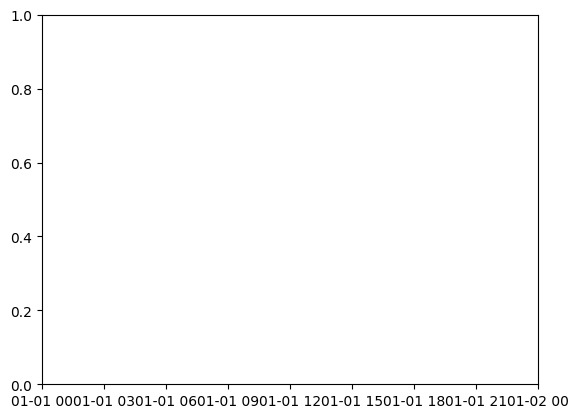

In [114]:
# To plot the test data prediction against time we get the timestamp column for the data
predictions_descaled = descale(descaler, predictions)
labels_descaled = descale(descaler, labels)
test_data = pd.DataFrame(columns=df.columns)

plt.plot(df, predictions_descaled)
plt.plot(df, labels_descaled)